YF.download() has changed argument auto_adjust default to True
Correlation Matrix:
               ^CNXIT  ^CNXAUTO  ^NSEBANK  ^CNXFMCG  ^CNXMEDIA  ^CNXMETAL  \
^CNXIT       1.000000  0.404432  0.334210  0.338896   0.325327   0.380451   
^CNXAUTO     0.404432  1.000000  0.617034  0.476604   0.555814   0.574411   
^NSEBANK     0.334210  0.617034  1.000000  0.382157   0.458654   0.548483   
^CNXFMCG     0.338896  0.476604  0.382157  1.000000   0.358991   0.339022   
^CNXMEDIA    0.325327  0.555814  0.458654  0.358991   1.000000   0.532415   
^CNXMETAL    0.380451  0.574411  0.548483  0.339022   0.532415   1.000000   
^CNXPSE      0.301490  0.579845  0.543091  0.335449   0.565058   0.726259   
^CNXMNC      0.484265  0.766108  0.587850  0.727051   0.590294   0.651544   
^CNXINFRA    0.444132  0.723874  0.680565  0.486953   0.608260   0.725256   
^CNXREALTY   0.352500  0.613872  0.585867  0.406681   0.576859   0.581164   
^CNXENERGY   0.323629  0.587851  0.559459  0.366966   0.540557   0.679

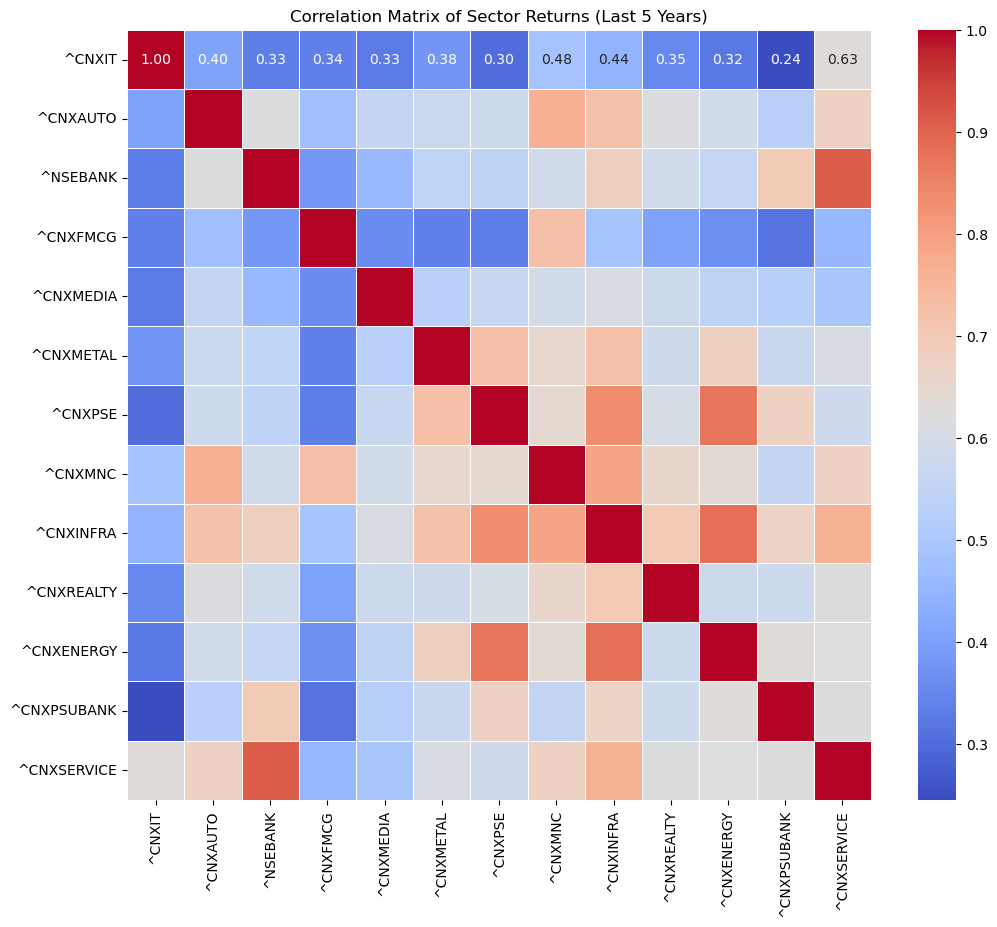

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# -----------------------------
# 1. Define Parameters & Tickers
# -----------------------------
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define time period: last 5 years
end_date = datetime.today()
start_date = end_date - timedelta(days=5 * 365)

# -----------------------------
# 2. Download Sector Data
# -----------------------------
data_dict = {}
for ticker in sector_tickers:
    # Using auto_adjust=True (default), so we use the "Close" column as our adjusted price.
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if not df.empty and 'Close' in df.columns:
        price_data = df['Close']
        # If price_data is a DataFrame, squeeze it to convert into a Series.
        if isinstance(price_data, pd.DataFrame):
            price_data = price_data.squeeze()
        data_dict[ticker] = price_data
    else:
        print(f"Data for {ticker} is missing 'Close'.")

if not data_dict:
    raise ValueError("No sector data downloaded. Check ticker symbols or network connection.")

# Create a DataFrame from the downloaded data and drop rows with missing values
prices = pd.DataFrame(data_dict).dropna()

# -----------------------------
# 3. Calculate Daily Returns
# -----------------------------
returns = prices.pct_change().dropna()

# -----------------------------
# 4. Compute the Correlation Matrix
# -----------------------------
correlation_matrix = returns.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# -----------------------------
# 5. Visualize the Correlation Matrix
# -----------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Sector Returns (Last 5 Years)")
plt.show()

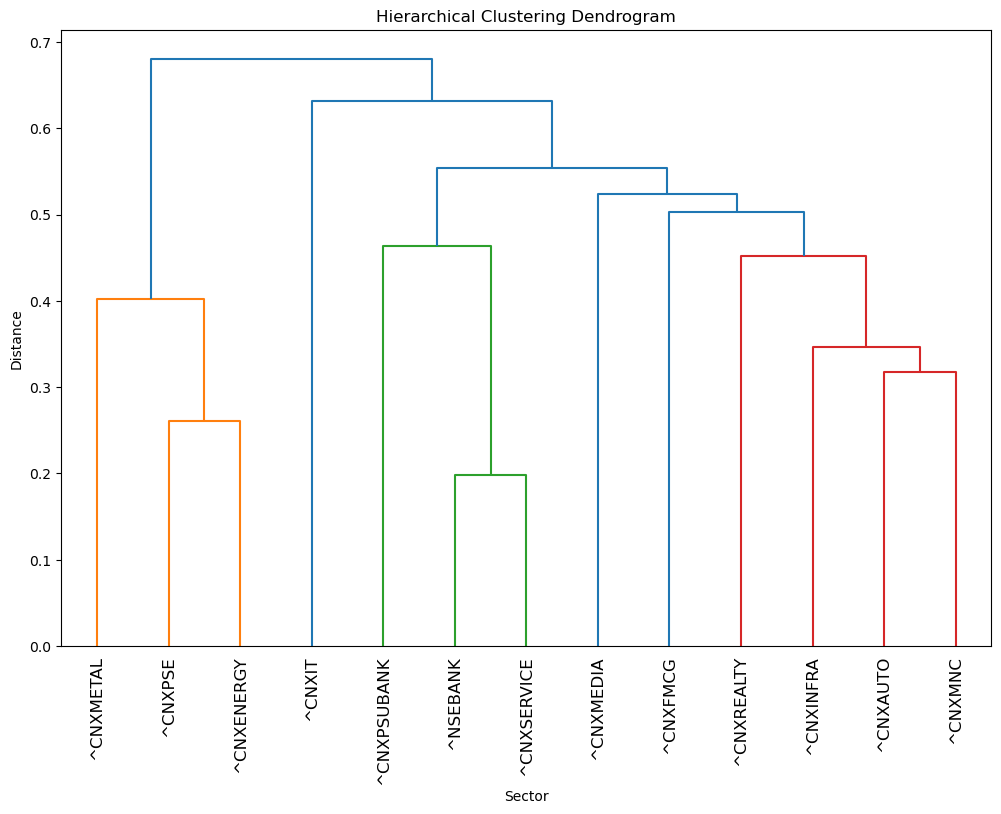


=== Sector Cluster Memberships (Threshold = 0.15) ===
     Ticker  Cluster
    ^CNXPSE        1
 ^CNXENERGY        2
  ^CNXMETAL        3
   ^NSEBANK        4
^CNXSERVICE        5
^CNXPSUBANK        6
   ^CNXAUTO        7
    ^CNXMNC        8
  ^CNXINFRA        9
 ^CNXREALTY       10
   ^CNXFMCG       11
  ^CNXMEDIA       12
     ^CNXIT       13

=== Linkage Matrix (First 10 rows) ===
   Sector1_idx  Sector2_idx  Distance  SampleCount
0          2.0         12.0  0.197963          2.0
1          6.0         10.0  0.260483          2.0
2          1.0          7.0  0.317659          2.0
3          8.0         15.0  0.347017          3.0
4          5.0         14.0  0.402329          3.0
5          9.0         16.0  0.452116          4.0
6         11.0         13.0  0.462966          3.0
7          3.0         18.0  0.502737          5.0
8          4.0         20.0  0.524161          6.0
9         19.0         21.0  0.553972          9.0


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# -----------------------------
# 1. Define Parameters & Tickers
# -----------------------------
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
]

# Define time period: last 10 years for broader analysis
end_date = datetime.today()
start_date = end_date - timedelta(days=10 * 365)

# -----------------------------
# 2. Download Sector Data
# -----------------------------
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if not df.empty and 'Close' in df.columns:
        price_data = df['Close']
        # Squeeze in case it's a DataFrame
        if isinstance(price_data, pd.DataFrame):
            price_data = price_data.squeeze()
        data_dict[ticker] = price_data
    else:
        print(f"Data for {ticker} is missing 'Close'.")

if not data_dict:
    raise ValueError("No sector data downloaded. Check ticker symbols or network connection.")

prices = pd.DataFrame(data_dict).dropna()

# -----------------------------
# 3. Calculate Daily Returns & Correlation Matrix
# -----------------------------
returns = prices.pct_change().dropna()
correlation_matrix = returns.corr()

# -----------------------------
# 4. Transform Correlations into Distances
# -----------------------------
# Using the metric: d = sqrt(0.5 * (1 - corr))
distance_matrix = np.sqrt(0.5 * (1 - correlation_matrix))

# For hierarchical clustering we need the condensed distance matrix.
condensed_dist = squareform(distance_matrix)

# -----------------------------
# 5. Hierarchical Clustering and Dendrogram
# -----------------------------
# Compute linkage matrix using Ward's method
Z = linkage(condensed_dist, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(Z, labels=correlation_matrix.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sector")
plt.ylabel("Distance")
plt.show()

# -----------------------------
# 6. Determine Cluster Memberships
# -----------------------------
# Set a threshold to form flat clusters; adjust this threshold to see different levels.
# Lower threshold: more clusters (sectors need to be very similar to be grouped)
threshold = 0.15  # you can experiment with this value
clusters = fcluster(Z, t=threshold, criterion='distance')

# Map tickers to clusters
cluster_df = pd.DataFrame({'Ticker': correlation_matrix.index, 'Cluster': clusters})
print("\n=== Sector Cluster Memberships (Threshold = {:.2f}) ===".format(threshold))
print(cluster_df.sort_values('Cluster').to_string(index=False))

# -----------------------------
# 7. Interpret Cluster Levels
# -----------------------------
# Optionally, print out the linkage matrix to see at what distances clusters merge.
linkage_df = pd.DataFrame(Z, columns=['Sector1_idx', 'Sector2_idx', 'Distance', 'SampleCount'])
print("\n=== Linkage Matrix (First 10 rows) ===")
print(linkage_df.head(10))

Below is an enhanced explanation focused solely on the sectoral part, with the understanding that we are directly investing in the sector tickers rather than in the individual stocks within those sectors.

Enter the number of years for simulation (1-15):  4



Correlation Matrix of Sector Returns (Last 4 Years):
                           ^CNXIT  ^CNXAUTO  ^NSEBANK  ^CNXFMCG ^CNXMEDIA  \
Ticker                     ^CNXIT  ^CNXAUTO  ^NSEBANK  ^CNXFMCG ^CNXMEDIA   
            Ticker                                                          
^CNXIT      ^CNXIT       1.000000  0.364742  0.349408  0.346862  0.321398   
^CNXAUTO    ^CNXAUTO     0.364742  1.000000  0.607015  0.508620  0.519235   
^NSEBANK    ^NSEBANK     0.349408  0.607015  1.000000  0.419604  0.431365   
^CNXFMCG    ^CNXFMCG     0.346862  0.508620  0.419604  1.000000  0.349781   
^CNXMEDIA   ^CNXMEDIA    0.321398  0.519235  0.431365  0.349781  1.000000   
^CNXMETAL   ^CNXMETAL    0.364683  0.534661  0.542602  0.307151  0.522988   
^CNXPSE     ^CNXPSE      0.282840  0.569562  0.537292  0.307660  0.543550   
^CNXMNC     ^CNXMNC      0.474414  0.775322  0.618531  0.718776  0.572585   
^CNXINFRA   ^CNXINFRA    0.451605  0.711744  0.692162  0.496106  0.577366   
^CNXREALTY  ^CNXREALTY

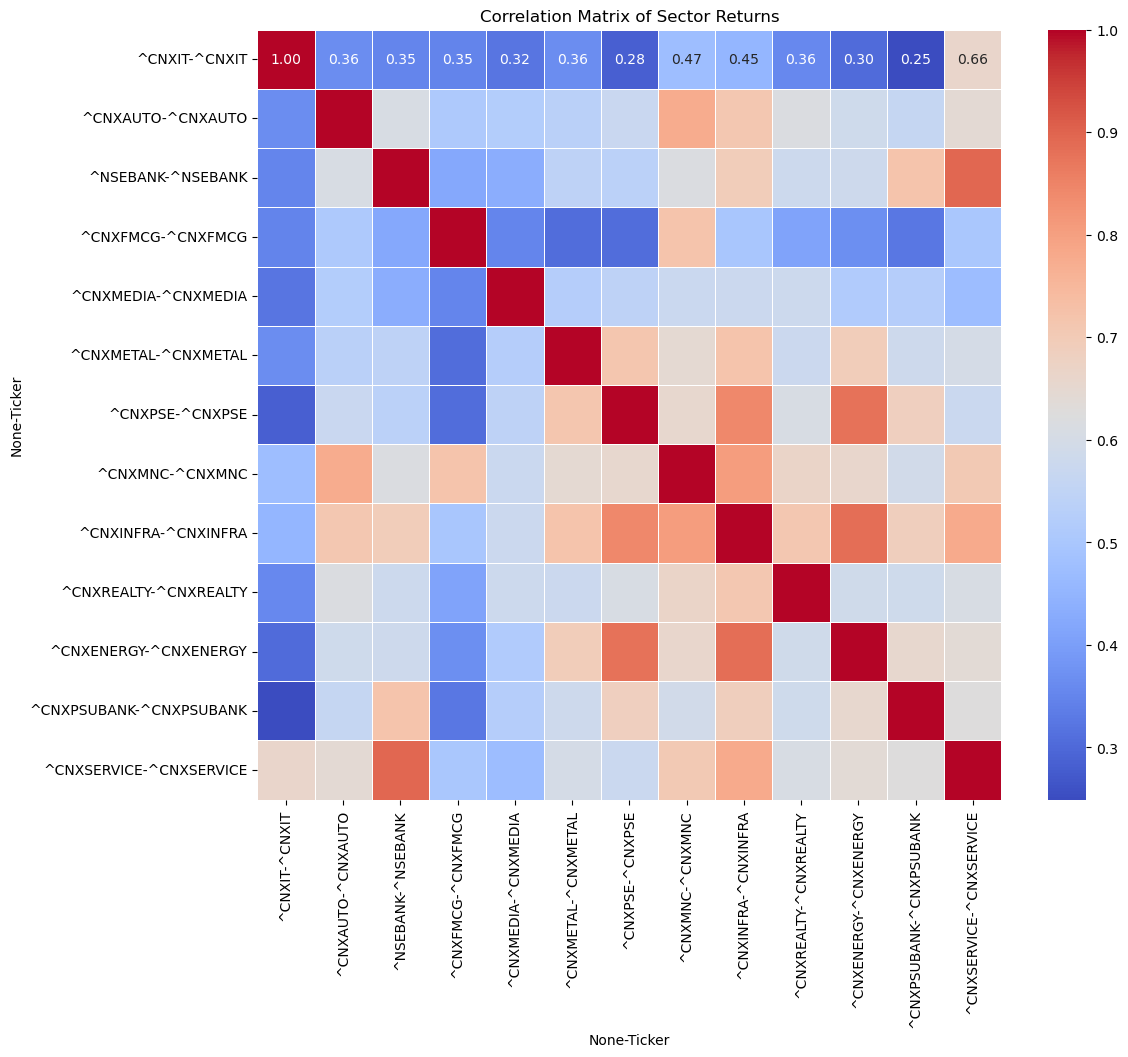

C:\Users\sarda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size



Sector Cluster Mapping (for Diversification):
  ('^CNXIT', '^CNXIT'): Cluster 2
  ('^CNXAUTO', '^CNXAUTO'): Cluster 1
  ('^NSEBANK', '^NSEBANK'): Cluster 1
  ('^CNXFMCG', '^CNXFMCG'): Cluster 1
  ('^CNXMEDIA', '^CNXMEDIA'): Cluster 0
  ('^CNXMETAL', '^CNXMETAL'): Cluster 1
  ('^CNXPSE', '^CNXPSE'): Cluster 1
  ('^CNXMNC', '^CNXMNC'): Cluster 1
  ('^CNXINFRA', '^CNXINFRA'): Cluster 1
  ('^CNXREALTY', '^CNXREALTY'): Cluster 1
  ('^CNXENERGY', '^CNXENERGY'): Cluster 1
  ('^CNXPSUBANK', '^CNXPSUBANK'): Cluster 0
  ('^CNXSERVICE', '^CNXSERVICE'): Cluster 1

--- Quarterly Rebalancing Simulation with Enhanced Risk Management ---


===== Simulating for Top 3 Sectors =====

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 12.50%
    ('^CNXMEDIA', '^CNXMEDIA'): 50.00%
    ('^CNXIT', '^CNXIT'): 37.50%
  Raw Portfolio Return: 19.07%
  Risk Factor: 1.00
  Effective Portfolio R

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 12.50%
    ('^CNXIT', '^CNXIT'): 37.50%
    ('^CNXMEDIA', '^CNXMEDIA'): 50.00%
  Raw Portfolio Return: -20.21%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.99
  Effective Portfolio Return: -4.95%
  Cumulative Value after Transaction Costs: ₹114,206.07
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 12.50%
    ('^CNXMEDIA', '^CNXMEDIA'): 50.00%
    ('^CNXIT', '^CNXIT'): 37.50%
  Raw Portfolio Return: 3.30%
  Risk Factor: 0.89
  Effective Portfolio Return: 2.95%
  Cumulative Value after Transaction Costs: ₹117,395.22
-------------------------------------------------------------

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: [('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT')]
  HRP Weights:
    ('^CNXPSUBANK', '^CNXPSUBANK'): 12.50%
    ('^CNXENERGY', '^CNXENERGY'): 50.00%
    ('^CNXIT', '^CNXIT'): 37.50%
  Raw Portfolio Return: -8.05%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 1.00
  Effective Portfolio Return: -5.00%
  Cumulative Value after Transaction Costs: ₹141,289.00
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT')]
  HRP Weights:
    ('^CNXFMCG', '^CNXFMCG'): 12.50%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 37.50%
    ('^CNXIT', '^CNXIT'): 50.00%
  Raw Portfolio Return: 6.93%
  Risk Factor: 0.95
  Effective Portfolio Return: 6.61%
  Cumulative Value after Transaction Costs: ₹150,404.10
------------------------------------------------------

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\U

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 12.50%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 50.00%
    ('^CNXIT', '^CNXIT'): 37.50%
  Raw Portfolio Return: 11.56%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 1.00
  Effective Portfolio Return: -5.00%
  Cumulative Value after Transaction Costs: ₹160,324.29
--------------------------------------------------------------------------------
Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 12.50%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 50.00%
    ('^CNXIT', '^CNXIT'): 37.50%
  Raw Portfolio Return: 12.56%
  Risk Factor: 1.00
  Effective Portfolio Return: 12.56%
  Cumulative Value after Transaction Costs: ₹180,197.43
--------------------------------------------------------------------

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 12.50%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 50.00%
    ('^CNXIT', '^CNXIT'): 37.50%
  Raw Portfolio Return: 4.84%
  Risk Factor: 1.00
  Effective Portfolio Return: 4.84%
  Cumulative Value after Transaction Costs: ₹188,641.44
--------------------------------------------------------------------------------
Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 12.50%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 50.00%
    ('^CNXIT', '^CNXIT'): 37.50%
  Raw Portfolio Return: 2.02%
  Risk Factor: 1.00
  Effective Portfolio Return: 2.02%
  Cumulative Value after Transaction Costs: ₹192,161.47
--------------------------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 12.50%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 50.00%
    ('^CNXIT', '^CNXIT'): 37.50%
  Raw Portfolio Return: -2.74%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 1.00
  Effective Portfolio Return: -5.00%
  Cumulative Value after Transaction Costs: ₹182,279.67
--------------------------------------------------------------------------------
Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 12.50%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 50.00%
    ('^CNXIT', '^CNXIT'): 37.50%
  Raw Portfolio Return: -9.33%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.92
  Effective Portfolio Return: -4.58%
  Cumulative Value after Transaction Costs: ₹173,665.23
-----------------------

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'), ('^CNXMNC', '^CNXMNC')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 10.53%
    ('^CNXMEDIA', '^CNXMEDIA'): 10.53%
    ('^CNXIT', '^CNXIT'): 31.58%
    ('^CNXMNC', '^CNXMNC'): 47.37%
  Raw Portfolio Return: 14.66%
  Risk Factor: 1.00
  Effective Portfolio Return: 14.66%
  Cumulative Value after Transaction Costs: ₹114,484.53
--------------------------------------------------------------------------------
Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: [('^CNXMNC', '^CNXMNC'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXFMCG', '^CNXFMCG')]
  HRP Weights:
    ('^CNXMNC', '^CNXMNC'): 10.53%
    ('^CNXIT', '^CNXIT'): 10.53%
    ('^CNXMEDIA', '^CNXMEDIA'): 31.58%
    ('^CNXFMCG', '^CNXFMCG'): 47.37%
  Raw Portfolio Return: -1.13%
  Risk Factor: 1.00
  Effective Portfolio Return: -1.13%
  Cumulative Value after Transaction Costs: ₹113,021.79
-------

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXMETAL', '^CNXMETAL')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 10.53%
    ('^CNXIT', '^CNXIT'): 31.58%
    ('^CNXMEDIA', '^CNXMEDIA'): 10.53%
    ('^CNXMETAL', '^CNXMETAL'): 47.37%
  Raw Portfolio Return: -23.48%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.99
  Effective Portfolio Return: -4.95%
  Cumulative Value after Transaction Costs: ₹101,799.75
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 31.58%
    ('^CNXMEDIA', '^CNXMEDIA'): 10.53%
    ('^CNXIT', '^CNXIT'): 47.37%
    ('^CNXPSE', '^CNXPSE'): 10.53%
  Raw Portfolio Return: 1.65%
  Risk Factor: 0.89
  Effective Portfolio Retur

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: [('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE')]
  HRP Weights:
    ('^CNXPSUBANK', '^CNXPSUBANK'): 10.53%
    ('^CNXENERGY', '^CNXENERGY'): 10.53%
    ('^CNXIT', '^CNXIT'): 31.58%
    ('^CNXPSE', '^CNXPSE'): 47.37%
  Raw Portfolio Return: -2.39%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 1.00
  Effective Portfolio Return: -5.00%
  Cumulative Value after Transaction Costs: ₹104,942.64
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE')]
  HRP Weights:
    ('^CNXFMCG', '^CNXFMCG'): 10.53%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 31.58%
    ('^CNXIT', '^CNXIT'): 47.37%
    ('^CNXPSE', '^CNXPSE'): 10.53%
  Raw Portfolio Return: 7.40%
  Risk Factor: 0.95
  Effective Portfolio Return

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE')]
  HRP Weights:
    ('^CNXFMCG', '^CNXFMCG'): 10.53%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 31.58%
    ('^CNXIT', '^CNXIT'): 47.37%
    ('^CNXPSE', '^CNXPSE'): 10.53%
  Raw Portfolio Return: 12.79%
  Risk Factor: 1.00
  Effective Portfolio Return: 12.79%
  Cumulative Value after Transaction Costs: ₹126,341.44
--------------------------------------------------------------------------------
Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXFMCG', '^CNXFMCG')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 31.58%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 10.53%
    ('^CNXIT', '^CNXIT'): 10.53%
    ('^CNXFMCG', '^CNXFMCG'): 47.37%
  Raw Portfolio Return: 17.25%
  Risk Factor: 1.00
  Effective Portfolio Return: 17.25%
  Cumulative Value after Transaction Costs:

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 10.53%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 10.53%
    ('^CNXIT', '^CNXIT'): 31.58%
    ('^CNXINFRA', '^CNXINFRA'): 47.37%
  Raw Portfolio Return: 6.95%
  Risk Factor: 1.00
  Effective Portfolio Return: 6.95%
  Cumulative Value after Transaction Costs: ₹174,219.18
--------------------------------------------------------------------------------
Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 10.53%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 47.37%
    ('^CNXIT', '^CNXIT'): 31.58%
    ('^CNXAUTO', '^CNXAUTO'): 10.53%
  Raw Portfolio Return: 2.01%
  Risk Factor: 1.00
  Effective Portfolio Return: 2.01%
  Cumulative Value after Transaction Costs:

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 10.53%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 47.37%
    ('^CNXIT', '^CNXIT'): 31.58%
    ('^CNXAUTO', '^CNXAUTO'): 10.53%
  Raw Portfolio Return: -4.13%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 1.00
  Effective Portfolio Return: -5.00%
  Cumulative Value after Transaction Costs: ₹168,327.80
--------------------------------------------------------------------------------
Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 10.53%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 47.37%
    ('^CNXIT', '^CNXIT'): 31.58%
    ('^CNXAUTO', '^CNXAUTO'): 10.53%
  Raw Portfolio Return: -9.31%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Fac

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'), ('^CNXMNC', '^CNXMNC'), ('^CNXMETAL', '^CNXMETAL')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 8.41%
    ('^CNXMEDIA', '^CNXMEDIA'): 9.35%
    ('^CNXIT', '^CNXIT'): 28.04%
    ('^CNXMNC', '^CNXMNC'): 9.35%
    ('^CNXMETAL', '^CNXMETAL'): 44.86%
  Raw Portfolio Return: 13.16%
  Risk Factor: 1.00
  Effective Portfolio Return: 13.16%
  Cumulative Value after Transaction Costs: ₹112,987.16
--------------------------------------------------------------------------------
Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: [('^CNXMNC', '^CNXMNC'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXMNC', '^CNXMNC'): 8.41%
    ('^CNXIT', '^CNXIT'): 9.35%
    ('^CNXMEDIA', '^CNXMEDIA'): 28.04%
    ('^CNXFMCG', '^CNXFMCG'): 9.35%
    ('^CNXINFRA', '^CNXINFRA'): 44.86%
  Raw Portfolio Return:

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXMETAL', '^CNXMETAL'), ('^CNXPSE', '^CNXPSE')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 8.41%
    ('^CNXIT', '^CNXIT'): 28.04%
    ('^CNXMEDIA', '^CNXMEDIA'): 9.35%
    ('^CNXMETAL', '^CNXMETAL'): 9.35%
    ('^CNXPSE', '^CNXPSE'): 44.86%
  Raw Portfolio Return: -15.87%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.99
  Effective Portfolio Return: -4.95%
  Cumulative Value after Transaction Costs: ₹102,249.04
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXAUTO', '^CNXAUTO')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 9.35%
    ('^CNXMEDIA', '^CNXMEDIA'): 8.41%
    ('^CNXIT', '^CNXIT'): 28.04%
    ('^CNXPSE', '^CNXPSE'): 9.35

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: [('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXFMCG', '^CNXFMCG')]
  HRP Weights:
    ('^CNXPSUBANK', '^CNXPSUBANK'): 28.04%
    ('^CNXENERGY', '^CNXENERGY'): 9.35%
    ('^CNXIT', '^CNXIT'): 8.41%
    ('^CNXPSE', '^CNXPSE'): 9.35%
    ('^CNXFMCG', '^CNXFMCG'): 44.86%
  Raw Portfolio Return: -3.41%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 1.00
  Effective Portfolio Return: -5.00%
  Cumulative Value after Transaction Costs: ₹107,584.67
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXFMCG', '^CNXFMCG'): 8.41%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 28.04%
    ('^CNXIT', '^CNXIT'): 44.86%
    ('^CNXPSE', '^CNXPSE')

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXMNC', '^CNXMNC')]
  HRP Weights:
    ('^CNXFMCG', '^CNXFMCG'): 8.41%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 28.04%
    ('^CNXIT', '^CNXIT'): 9.35%
    ('^CNXPSE', '^CNXPSE'): 9.35%
    ('^CNXMNC', '^CNXMNC'): 44.86%
  Raw Portfolio Return: 9.13%
  Risk Factor: 1.00
  Effective Portfolio Return: 9.13%
  Cumulative Value after Transaction Costs: ₹125,641.93
--------------------------------------------------------------------------------
Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 9.35%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 28.04%
    ('^CNXIT', '^CNXIT'): 8.41%
    ('^CNXFMCG', '^CNXFMCG'): 44.86%
    ('^CNXINFRA', '^CNXINFRA'): 9.35%
  Raw Portfol

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\U

Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXAUTO', '^CNXAUTO')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 8.41%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 9.35%
    ('^CNXIT', '^CNXIT'): 28.04%
    ('^CNXINFRA', '^CNXINFRA'): 44.86%
    ('^CNXAUTO', '^CNXAUTO'): 9.35%
  Raw Portfolio Return: 7.94%
  Risk Factor: 1.00
  Effective Portfolio Return: 7.94%
  Cumulative Value after Transaction Costs: ₹161,186.83
--------------------------------------------------------------------------------
Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXMNC', '^CNXMNC')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 8.41%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 44.86%
    ('^CNXIT', '^CNXIT'): 28.04%
    ('^CNXAUTO', '^CNXAUTO'): 9.35%
    ('^CNXMNC', '^CNXMNC'): 9.35%
  Raw Portfol

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'), ('^CNXMNC', '^CNXMNC'), ('^CNXMETAL', '^CNXMETAL'), ('^CNXPSUBANK', '^CNXPSUBANK')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 6.84%
    ('^CNXMEDIA', '^CNXMEDIA'): 8.55%
    ('^CNXIT', '^CNXIT'): 25.64%
    ('^CNXMNC', '^CNXMNC'): 7.69%
    ('^CNXMETAL', '^CNXMETAL'): 8.55%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 42.74%
  Raw Portfolio Return: 8.65%
  Risk Factor: 1.00
  Effective Portfolio Return: 8.65%
  Cumulative Value after Transaction Costs: ₹108,486.76
--------------------------------------------------------------------------------
Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: [('^CNXMNC', '^CNXMNC'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXPSE', '^CNXPSE')]
  HRP Weights:
    ('^CNXMNC', '^CNXMNC'): 6.84%
    ('^CNXIT', '^CNXIT'): 25.64%
    ('^CNXMEDIA', '^CNXMEDIA'): 8.55%
  

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXMETAL', '^CNXMETAL'), ('^CNXPSE', '^CNXPSE'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 6.84%
    ('^CNXIT', '^CNXIT'): 25.64%
    ('^CNXMEDIA', '^CNXMEDIA'): 8.55%
    ('^CNXMETAL', '^CNXMETAL'): 8.55%
    ('^CNXPSE', '^CNXPSE'): 42.74%
    ('^CNXINFRA', '^CNXINFRA'): 7.69%
  Raw Portfolio Return: -15.35%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.99
  Effective Portfolio Return: -4.95%
  Cumulative Value after Transaction Costs: ₹98,975.13
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 8.55%
    ('^CNX

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXMNC', '^CNXMNC'), ('^CNXPSE', '^CNXPSE')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 8.55%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 25.64%
    ('^CNXIT', '^CNXIT'): 7.69%
    ('^CNXFMCG', '^CNXFMCG'): 6.84%
    ('^CNXMNC', '^CNXMNC'): 42.74%
    ('^CNXPSE', '^CNXPSE'): 8.55%
  Raw Portfolio Return: 14.83%
  Risk Factor: 1.00
  Effective Portfolio Return: 14.83%
  Cumulative Value after Transaction Costs: ₹118,344.84
--------------------------------------------------------------------------------
Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: [('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXMETAL', '^CNXMETAL')]
  HRP Weights:
    ('^CNXPSUBANK', '^CNXPSUBANK'): 25.64%
    ('^CNXENERGY', '^CNXENERGY'): 8.55%
    ('^CNXIT

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXMNC', '^CNXMNC')]
  HRP Weights:
    ('^CNXFMCG', '^CNXFMCG'): 8.55%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 8.55%
    ('^CNXIT', '^CNXIT'): 25.64%
    ('^CNXPSE', '^CNXPSE'): 7.69%
    ('^CNXINFRA', '^CNXINFRA'): 6.84%
    ('^CNXMNC', '^CNXMNC'): 42.74%
  Raw Portfolio Return: 10.42%
  Risk Factor: 0.95
  Effective Portfolio Return: 9.94%
  Cumulative Value after Transaction Costs: ₹123,233.34
--------------------------------------------------------------------------------
Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXMNC', '^CNXMNC'), ('^CNXAUTO', '^CNXAUTO')]
  HRP Weights:
    ('^CNXFMCG', '^CNXFMCG'): 8.55%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 6.84%
    ('^CNXIT', '^CNXIT'): 25.6

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\U

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXAUTO', '^CNXAUTO')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 8.55%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 25.64%
    ('^CNXIT', '^CNXIT'): 6.84%
    ('^CNXINFRA', '^CNXINFRA'): 7.69%
    ('^CNXFMCG', '^CNXFMCG'): 42.74%
    ('^CNXAUTO', '^CNXAUTO'): 8.55%
  Raw Portfolio Return: 7.02%
  Risk Factor: 1.00
  Effective Portfolio Return: 7.02%
  Cumulative Value after Transaction Costs: ₹164,694.03
--------------------------------------------------------------------------------
Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXENERGY', '^CNXENERGY')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 8.55%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 6.84%
    ('^CNXIT', '^CNXI

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXMNC', '^CNXMNC'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 6.84%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 7.69%
    ('^CNXIT', '^CNXIT'): 25.64%
    ('^CNXAUTO', '^CNXAUTO'): 8.55%
    ('^CNXMNC', '^CNXMNC'): 8.55%
    ('^CNXINFRA', '^CNXINFRA'): 42.74%
  Raw Portfolio Return: 6.48%
  Risk Factor: 1.00
  Effective Portfolio Return: 6.48%
  Cumulative Value after Transaction Costs: ₹194,311.91
--------------------------------------------------------------------------------
Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXMNC', '^CNXMNC'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 6.84%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 7.69%
    ('^CNXIT', '^CNXIT'): 25.64

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 8.55%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 8.55%
    ('^CNXIT', '^CNXIT'): 25.64%
    ('^CNXAUTO', '^CNXAUTO'): 6.84%
    ('^CNXREALTY', '^CNXREALTY'): 42.74%
    ('^CNXINFRA', '^CNXINFRA'): 7.69%
  Raw Portfolio Return: -14.14%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.92
  Effective Portfolio Return: -4.58%
  Cumulative Value after Transaction Costs: ₹175,608.67
--------------------------------------------------------------------------------

===== Simulating for Top 7 Sectors =====

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'), ('^CNXMNC', '^CNXMNC'), ('^CNXMETAL', '^CNXMETAL'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXENERGY', '^

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: [('^CNXMNC', '^CNXMNC'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXPSE', '^CNXPSE'), ('^CNXENERGY', '^CNXENERGY')]
  HRP Weights:
    ('^CNXMNC', '^CNXMNC'): 5.69%
    ('^CNXIT', '^CNXIT'): 23.89%
    ('^CNXMEDIA', '^CNXMEDIA'): 7.96%
    ('^CNXFMCG', '^CNXFMCG'): 7.96%
    ('^CNXINFRA', '^CNXINFRA'): 40.96%
    ('^CNXPSE', '^CNXPSE'): 7.17%
    ('^CNXENERGY', '^CNXENERGY'): 6.37%
  Raw Portfolio Return: 1.22%
  Risk Factor: 1.00
  Effective Portfolio Return: 1.22%
  Cumulative Value after Transaction Costs: ₹113,705.59
--------------------------------------------------------------------------------
Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: [('^CNXIT', '^CNXIT'), ('^CNXMNC', '^CNXMNC'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXSERVICE', '^CNXSERVICE')]
  HRP Weights:
    ('^

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXREALTY', '^CNXREALTY')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 7.96%
    ('^CNXMEDIA', '^CNXMEDIA'): 6.37%
    ('^CNXIT', '^CNXIT'): 23.89%
    ('^CNXPSE', '^CNXPSE'): 7.96%
    ('^CNXAUTO', '^CNXAUTO'): 5.69%
    ('^CNXINFRA', '^CNXINFRA'): 7.17%
    ('^CNXREALTY', '^CNXREALTY'): 40.96%
  Raw Portfolio Return: 5.17%
  Risk Factor: 0.89
  Effective Portfolio Return: 4.62%
  Cumulative Value after Transaction Costs: ₹106,982.85
--------------------------------------------------------------------------------
Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXMNC', '^CNXMNC'), ('^CNXPSE', '^CNXPSE'), ('^CNXAUTO', '^CNXAUTO')]
  HRP Weights:
    (

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: [('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXMETAL', '^CNXMETAL'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXPSUBANK', '^CNXPSUBANK'): 23.89%
    ('^CNXENERGY', '^CNXENERGY'): 7.17%
    ('^CNXIT', '^CNXIT'): 5.69%
    ('^CNXPSE', '^CNXPSE'): 7.96%
    ('^CNXFMCG', '^CNXFMCG'): 40.96%
    ('^CNXMETAL', '^CNXMETAL'): 7.96%
    ('^CNXINFRA', '^CNXINFRA'): 6.37%
  Raw Portfolio Return: -4.55%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 1.00
  Effective Portfolio Return: -5.00%
  Cumulative Value after Transaction Costs: ₹115,427.65
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXMNC', '^CNXMNC'

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXMNC', '^CNXMNC'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXFMCG', '^CNXFMCG'): 7.17%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 7.96%
    ('^CNXIT', '^CNXIT'): 23.89%
    ('^CNXPSE', '^CNXPSE'): 7.96%
    ('^CNXMNC', '^CNXMNC'): 5.69%
    ('^CNXAUTO', '^CNXAUTO'): 6.37%
    ('^CNXINFRA', '^CNXINFRA'): 40.96%
  Raw Portfolio Return: 8.74%
  Risk Factor: 1.00
  Effective Portfolio Return: 8.74%
  Cumulative Value after Transaction Costs: ₹138,719.75
--------------------------------------------------------------------------------
Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXMNC', '^CNXMNC')]
  HRP Weights:
    ('^CNXPSE', '^C

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXENERGY', '^CNXENERGY')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 23.89%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 7.17%
    ('^CNXIT', '^CNXIT'): 5.69%
    ('^CNXINFRA', '^CNXINFRA'): 7.96%
    ('^CNXFMCG', '^CNXFMCG'): 40.96%
    ('^CNXAUTO', '^CNXAUTO'): 6.37%
    ('^CNXENERGY', '^CNXENERGY'): 7.96%
  Raw Portfolio Return: 6.27%
  Risk Factor: 1.00
  Effective Portfolio Return: 6.27%
  Cumulative Value after Transaction Costs: ₹166,220.57
--------------------------------------------------------------------------------
Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXREALTY', '^CNXREALTY')]
  HRP Weight

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXMNC', '^CNXMNC'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXREALTY', '^CNXREALTY')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 7.96%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 7.96%
    ('^CNXIT', '^CNXIT'): 23.89%
    ('^CNXAUTO', '^CNXAUTO'): 5.69%
    ('^CNXMNC', '^CNXMNC'): 40.96%
    ('^CNXINFRA', '^CNXINFRA'): 7.17%
    ('^CNXREALTY', '^CNXREALTY'): 6.37%
  Raw Portfolio Return: 6.37%
  Risk Factor: 1.00
  Effective Portfolio Return: 6.37%
  Cumulative Value after Transaction Costs: ₹196,499.80
--------------------------------------------------------------------------------
Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXMNC', '^CNXMNC'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXFMCG', '^CNXFMCG')]
  HRP Weights:
    ('^CNXP

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXMNC', '^CNXMNC')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 7.96%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 7.96%
    ('^CNXIT', '^CNXIT'): 23.89%
    ('^CNXAUTO', '^CNXAUTO'): 5.69%
    ('^CNXREALTY', '^CNXREALTY'): 6.37%
    ('^CNXINFRA', '^CNXINFRA'): 7.17%
    ('^CNXMNC', '^CNXMNC'): 40.96%
  Raw Portfolio Return: -10.06%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.92
  Effective Portfolio Return: -4.58%
  Cumulative Value after Transaction Costs: ₹177,585.98
--------------------------------------------------------------------------------

===== Simulating for Top 8 Sectors =====

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'), ('^CNXMNC', '^CNXMNC'), ('^CNXMETAL', '^CNX

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: [('^CNXMNC', '^CNXMNC'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXPSE', '^CNXPSE'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXREALTY', '^CNXREALTY')]
  HRP Weights:
    ('^CNXMNC', '^CNXMNC'): 6.01%
    ('^CNXIT', '^CNXIT'): 22.54%
    ('^CNXMEDIA', '^CNXMEDIA'): 4.83%
    ('^CNXFMCG', '^CNXFMCG'): 7.51%
    ('^CNXINFRA', '^CNXINFRA'): 5.37%
    ('^CNXPSE', '^CNXPSE'): 7.51%
    ('^CNXENERGY', '^CNXENERGY'): 6.76%
    ('^CNXREALTY', '^CNXREALTY'): 39.45%
  Raw Portfolio Return: -0.21%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 1.00
  Effective Portfolio Return: -5.00%
  Cumulative Value after Transaction Costs: ₹103,851.52
--------------------------------------------------------------------------------
Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: [('^CNXIT', '^CNXIT'), ('^CNXMNC', '^CNXMNC'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXENERGY', '^CNXENERG

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXMETAL', '^CNXMETAL'), ('^CNXPSE', '^CNXPSE'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXSERVICE', '^CNXSERVICE')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 7.51%
    ('^CNXIT', '^CNXIT'): 6.76%
    ('^CNXMEDIA', '^CNXMEDIA'): 6.01%
    ('^CNXMETAL', '^CNXMETAL'): 22.54%
    ('^CNXPSE', '^CNXPSE'): 7.51%
    ('^CNXINFRA', '^CNXINFRA'): 4.83%
    ('^CNXREALTY', '^CNXREALTY'): 5.37%
    ('^CNXSERVICE', '^CNXSERVICE'): 39.45%
  Raw Portfolio Return: -17.09%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.99
  Effective Portfolio Return: -4.95%
  Cumulative Value after Transaction Costs: ₹93,540.00
--------------------------------------------------------------------------------
Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'),

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXMNC', '^CNXMNC'), ('^CNXPSE', '^CNXPSE'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXINFRA', '^CNXINFRA')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 7.51%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 22.54%
    ('^CNXIT', '^CNXIT'): 6.01%
    ('^CNXFMCG', '^CNXFMCG'): 4.83%
    ('^CNXMNC', '^CNXMNC'): 39.45%
    ('^CNXPSE', '^CNXPSE'): 7.51%
    ('^CNXAUTO', '^CNXAUTO'): 5.37%
    ('^CNXINFRA', '^CNXINFRA'): 6.76%
  Raw Portfolio Return: 13.53%
  Risk Factor: 1.00
  Effective Portfolio Return: 13.53%
  Cumulative Value after Transaction Costs: ₹111,399.00
--------------------------------------------------------------------------------
Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: [('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXMETA

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXMNC', '^CNXMNC'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXREALTY', '^CNXREALTY')]
  HRP Weights:
    ('^CNXFMCG', '^CNXFMCG'): 6.76%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 7.51%
    ('^CNXIT', '^CNXIT'): 22.54%
    ('^CNXPSE', '^CNXPSE'): 7.51%
    ('^CNXMNC', '^CNXMNC'): 4.83%
    ('^CNXAUTO', '^CNXAUTO'): 5.37%
    ('^CNXINFRA', '^CNXINFRA'): 39.45%
    ('^CNXREALTY', '^CNXREALTY'): 6.01%
  Raw Portfolio Return: 8.86%
  Risk Factor: 1.00
  Effective Portfolio Return: 8.86%
  Cumulative Value after Transaction Costs: ₹127,683.28
--------------------------------------------------------------------------------
Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXAUTO', '

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXREALTY', '^CNXREALTY')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 22.54%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 6.76%
    ('^CNXIT', '^CNXIT'): 4.83%
    ('^CNXINFRA', '^CNXINFRA'): 7.51%
    ('^CNXFMCG', '^CNXFMCG'): 39.45%
    ('^CNXAUTO', '^CNXAUTO'): 6.01%
    ('^CNXENERGY', '^CNXENERGY'): 7.51%
    ('^CNXREALTY', '^CNXREALTY'): 5.37%
  Raw Portfolio Return: 6.72%
  Risk Factor: 1.00
  Effective Portfolio Return: 6.72%
  Cumulative Value after Transaction Costs: ₹153,560.53
--------------------------------------------------------------------------------
Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXAUTO', '^CNXAUTO'), ('

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXMNC', '^CNXMNC'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXENERGY', '^CNXENERGY')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 5.37%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 6.01%
    ('^CNXIT', '^CNXIT'): 22.54%
    ('^CNXAUTO', '^CNXAUTO'): 7.51%
    ('^CNXMNC', '^CNXMNC'): 6.76%
    ('^CNXINFRA', '^CNXINFRA'): 4.83%
    ('^CNXREALTY', '^CNXREALTY'): 7.51%
    ('^CNXENERGY', '^CNXENERGY'): 39.45%
  Raw Portfolio Return: 6.40%
  Risk Factor: 1.00
  Effective Portfolio Return: 6.40%
  Cumulative Value after Transaction Costs: ₹176,249.62
--------------------------------------------------------------------------------
Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXMNC', '^CNXMNC'), ('^CNXINFR

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXMNC', '^CNXMNC'), ('^CNXFMCG', '^CNXFMCG')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 7.51%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 22.54%
    ('^CNXIT', '^CNXIT'): 4.83%
    ('^CNXAUTO', '^CNXAUTO'): 6.01%
    ('^CNXREALTY', '^CNXREALTY'): 6.76%
    ('^CNXINFRA', '^CNXINFRA'): 7.51%
    ('^CNXMNC', '^CNXMNC'): 5.37%
    ('^CNXFMCG', '^CNXFMCG'): 39.45%
  Raw Portfolio Return: -7.59%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.92
  Effective Portfolio Return: -4.58%
  Cumulative Value after Transaction Costs: ₹159,284.95
--------------------------------------------------------------------------------

===== Simulating for Top 9 Sectors =====

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXMEDIA', '^CNXMEDIA'), ('^C

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: [('^CNXMNC', '^CNXMNC'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXPSE', '^CNXPSE'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXSERVICE', '^CNXSERVICE')]
  HRP Weights:
    ('^CNXMNC', '^CNXMNC'): 4.17%
    ('^CNXIT', '^CNXIT'): 21.47%
    ('^CNXMEDIA', '^CNXMEDIA'): 7.16%
    ('^CNXFMCG', '^CNXFMCG'): 7.16%
    ('^CNXINFRA', '^CNXINFRA'): 38.17%
    ('^CNXPSE', '^CNXPSE'): 5.72%
    ('^CNXENERGY', '^CNXENERGY'): 5.11%
    ('^CNXREALTY', '^CNXREALTY'): 6.44%
    ('^CNXSERVICE', '^CNXSERVICE'): 4.60%
  Raw Portfolio Return: 0.85%
  Risk Factor: 1.00
  Effective Portfolio Return: 0.85%
  Cumulative Value after Transaction Costs: ₹109,453.53
--------------------------------------------------------------------------------
Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: [('^CNXIT', '^CNXIT'), ('^CNXMNC', '^CNXMNC'), ('^CNXMEDIA', '^CNXMEDIA')

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXMNC', '^CNXMNC')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 7.16%
    ('^CNXMEDIA', '^CNXMEDIA'): 4.60%
    ('^CNXIT', '^CNXIT'): 6.44%
    ('^CNXPSE', '^CNXPSE'): 21.47%
    ('^CNXAUTO', '^CNXAUTO'): 4.17%
    ('^CNXINFRA', '^CNXINFRA'): 7.16%
    ('^CNXREALTY', '^CNXREALTY'): 38.17%
    ('^CNXFMCG', '^CNXFMCG'): 5.72%
    ('^CNXMNC', '^CNXMNC'): 5.11%
  Raw Portfolio Return: 7.64%
  Risk Factor: 0.89
  Effective Portfolio Return: 6.82%
  Cumulative Value after Transaction Costs: ₹105,151.98
--------------------------------------------------------------------------------
Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: [('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXMETAL', '^CNXMETAL'), ('^CNXINFRA', '^CNXINFRA'), ('^NSEBANK', '^NSEBANK'), ('^CNXMNC', '^CNXMNC')]
  HRP Weights:
    ('^CNXPSUBANK', '^CNXPSUBANK'): 6.44%
    ('^CNXENERGY', '^CNXENERGY'): 4.17%
    ('^CNXIT', '^CNXIT'): 21.47%
    ('^CNXPSE', '^CNXPSE'): 4.60%
    ('^CNXFMCG', '^CNXFMCG'): 7.16%
    ('^CNXMETAL', '^CNXMETAL'): 5.11%
    ('^CNXINFRA', '^CNXINFRA'): 38.17%
    ('^NSEBANK', '^NSEBANK'): 5.72%
    ('^CNXMNC', '^CNXMNC'): 7.16%
  Raw Portfolio Return: -4.21%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 1.00
  Effective Portfolio Return: -5.00%
  Cumulative Value after Transaction Costs: ₹104,959.35
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXP

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\U

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXMNC', '^CNXMNC'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXREALTY', '^CNXREALTY')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 21.47%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 6.44%
    ('^CNXIT', '^CNXIT'): 5.11%
    ('^CNXFMCG', '^CNXFMCG'): 4.60%
    ('^CNXINFRA', '^CNXINFRA'): 7.16%
    ('^CNXAUTO', '^CNXAUTO'): 4.17%
    ('^CNXMNC', '^CNXMNC'): 38.17%
    ('^CNXENERGY', '^CNXENERGY'): 7.16%
    ('^CNXREALTY', '^CNXREALTY'): 5.72%
  Raw Portfolio Return: 18.13%
  Risk Factor: 1.00
  Effective Portfolio Return: 18.13%
  Cumulative Value after Transaction Costs: ₹152,720.06
--------------------------------------------------------------------------------
Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXMNC', '^CNXMNC'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXFMCG', '^CNXFMCG')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 7.16%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 21.47%
    ('^CNXIT', '^CNXIT'): 5.72%
    ('^CNXAUTO', '^CNXAUTO'): 4.17%
    ('^CNXMNC', '^CNXMNC'): 38.17%
    ('^CNXINFRA', '^CNXINFRA'): 7.16%
    ('^CNXREALTY', '^CNXREALTY'): 4.60%
    ('^CNXENERGY', '^CNXENERGY'): 6.44%
    ('^CNXFMCG', '^CNXFMCG'): 5.11%
  Raw Portfolio Return: 3.66%
  Risk Factor: 1.00
  Effective Portfolio Return: 3.66%
  Cumulative Value after Transaction Costs: ₹197,083.65
--------------------------------------------------------------------------------
Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT')

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: [('^CNXMNC', '^CNXMNC'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXPSE', '^CNXPSE'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXSERVICE', '^CNXSERVICE'), ('^CNXMETAL', '^CNXMETAL')]
  HRP Weights:
    ('^CNXMNC', '^CNXMNC'): 4.90%
    ('^CNXIT', '^CNXIT'): 20.58%
    ('^CNXMEDIA', '^CNXMEDIA'): 6.86%
    ('^CNXFMCG', '^CNXFMCG'): 6.86%
    ('^CNXINFRA', '^CNXINFRA'): 4.41%
    ('^CNXPSE', '^CNXPSE'): 3.66%
    ('^CNXENERGY', '^CNXENERGY'): 37.05%
    ('^CNXREALTY', '^CNXREALTY'): 6.18%
    ('^CNXSERVICE', '^CNXSERVICE'): 5.49%
    ('^CNXMETAL', '^CNXMETAL'): 4.00%
  Raw Portfolio Return: 0.81%
  Risk Factor: 1.00
  Effective Portfolio Return: 0.81%
  Cumulative Value after Transaction Costs: ₹112,067.20
--------------------------------------------------------------------------------
Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: [('^CNX

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: [('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXMEDIA', '^CNXMEDIA'), ('^CNXMETAL', '^CNXMETAL'), ('^CNXPSE', '^CNXPSE'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXSERVICE', '^CNXSERVICE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXMNC', '^CNXMNC')]
  HRP Weights:
    ('^CNXENERGY', '^CNXENERGY'): 6.86%
    ('^CNXIT', '^CNXIT'): 20.58%
    ('^CNXMEDIA', '^CNXMEDIA'): 5.49%
    ('^CNXMETAL', '^CNXMETAL'): 6.86%
    ('^CNXPSE', '^CNXPSE'): 6.18%
    ('^CNXINFRA', '^CNXINFRA'): 3.66%
    ('^CNXREALTY', '^CNXREALTY'): 4.41%
    ('^CNXSERVICE', '^CNXSERVICE'): 4.00%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 4.90%
    ('^CNXMNC', '^CNXMNC'): 37.05%
  Raw Portfolio Return: -12.63%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.99
  Effective Portfolio Return: -4.95%
  Cumulative Value after Transaction Costs: ₹100,939.94
--------------------------------------------------------------------------------
Q

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\U

Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: [('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXMETAL', '^CNXMETAL'), ('^CNXINFRA', '^CNXINFRA'), ('^NSEBANK', '^NSEBANK'), ('^CNXMNC', '^CNXMNC'), ('^CNXAUTO', '^CNXAUTO')]
  HRP Weights:
    ('^CNXPSUBANK', '^CNXPSUBANK'): 4.90%
    ('^CNXENERGY', '^CNXENERGY'): 6.86%
    ('^CNXIT', '^CNXIT'): 5.49%
    ('^CNXPSE', '^CNXPSE'): 6.86%
    ('^CNXFMCG', '^CNXFMCG'): 4.00%
    ('^CNXMETAL', '^CNXMETAL'): 20.58%
    ('^CNXINFRA', '^CNXINFRA'): 6.18%
    ('^NSEBANK', '^NSEBANK'): 4.41%
    ('^CNXMNC', '^CNXMNC'): 3.66%
    ('^CNXAUTO', '^CNXAUTO'): 37.05%
  Raw Portfolio Return: -7.35%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 1.00
  Effective Portfolio Return: -5.00%
  Cumulative Value after Transaction Costs: ₹107,756.24
--------------------------------------------------------------------------------
Quarter 2023-04-01 to 2023

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: [('^CNXFMCG', '^CNXFMCG'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXPSE', '^CNXPSE'), ('^CNXMNC', '^CNXMNC'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXREALTY', '^CNXREALTY'), ('^NSEBANK', '^NSEBANK'), ('^CNXENERGY', '^CNXENERGY')]
  HRP Weights:
    ('^CNXFMCG', '^CNXFMCG'): 4.00%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 5.49%
    ('^CNXIT', '^CNXIT'): 4.41%
    ('^CNXPSE', '^CNXPSE'): 20.58%
    ('^CNXMNC', '^CNXMNC'): 3.66%
    ('^CNXAUTO', '^CNXAUTO'): 37.05%
    ('^CNXINFRA', '^CNXINFRA'): 6.86%
    ('^CNXREALTY', '^CNXREALTY'): 6.18%
    ('^NSEBANK', '^NSEBANK'): 4.90%
    ('^CNXENERGY', '^CNXENERGY'): 6.86%
  Raw Portfolio Return: 9.49%
  Risk Factor: 1.00
  Effective Portfolio Return: 9.49%
  Cumulative Value after Transaction Costs: ₹134,161.71
--------------------------------------------------------------------------------
Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: [('^CNXPSE', '^

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXMNC', '^CNXMNC'), ('^CNXMETAL', '^CNXMETAL')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 6.86%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 5.49%
    ('^CNXIT', '^CNXIT'): 4.41%
    ('^CNXINFRA', '^CNXINFRA'): 6.86%
    ('^CNXFMCG', '^CNXFMCG'): 4.00%
    ('^CNXAUTO', '^CNXAUTO'): 3.66%
    ('^CNXENERGY', '^CNXENERGY'): 6.18%
    ('^CNXREALTY', '^CNXREALTY'): 4.90%
    ('^CNXMNC', '^CNXMNC'): 37.05%
    ('^CNXMETAL', '^CNXMETAL'): 20.58%
  Raw Portfolio Return: 8.57%
  Risk Factor: 1.00
  Effective Portfolio Return: 8.57%
  Cumulative Value after Transaction Costs: ₹168,506.95
--------------------------------------------------------------------------------
Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: [('^CNXPSE'

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: [('^CNXPSE', '^CNXPSE'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXAUTO', '^CNXAUTO'), ('^CNXREALTY', '^CNXREALTY'), ('^CNXINFRA', '^CNXINFRA'), ('^CNXMNC', '^CNXMNC'), ('^CNXFMCG', '^CNXFMCG'), ('^CNXENERGY', '^CNXENERGY'), ('^CNXSERVICE', '^CNXSERVICE')]
  HRP Weights:
    ('^CNXPSE', '^CNXPSE'): 6.86%
    ('^CNXPSUBANK', '^CNXPSUBANK'): 20.58%
    ('^CNXIT', '^CNXIT'): 5.49%
    ('^CNXAUTO', '^CNXAUTO'): 3.66%
    ('^CNXREALTY', '^CNXREALTY'): 4.00%
    ('^CNXINFRA', '^CNXINFRA'): 6.86%
    ('^CNXMNC', '^CNXMNC'): 37.05%
    ('^CNXFMCG', '^CNXFMCG'): 4.41%
    ('^CNXENERGY', '^CNXENERGY'): 6.18%
    ('^CNXSERVICE', '^CNXSERVICE'): 4.90%
  Raw Portfolio Return: -7.38%
  STOPLOSS Triggered: Capped Return = -5.00%
  Risk Factor: 0.92
  Effective Portfolio Return: -4.58%
  Cumulative Value after Transaction Costs: ₹177,695.26
--------------------------------------------------------------------------------

=== Simul

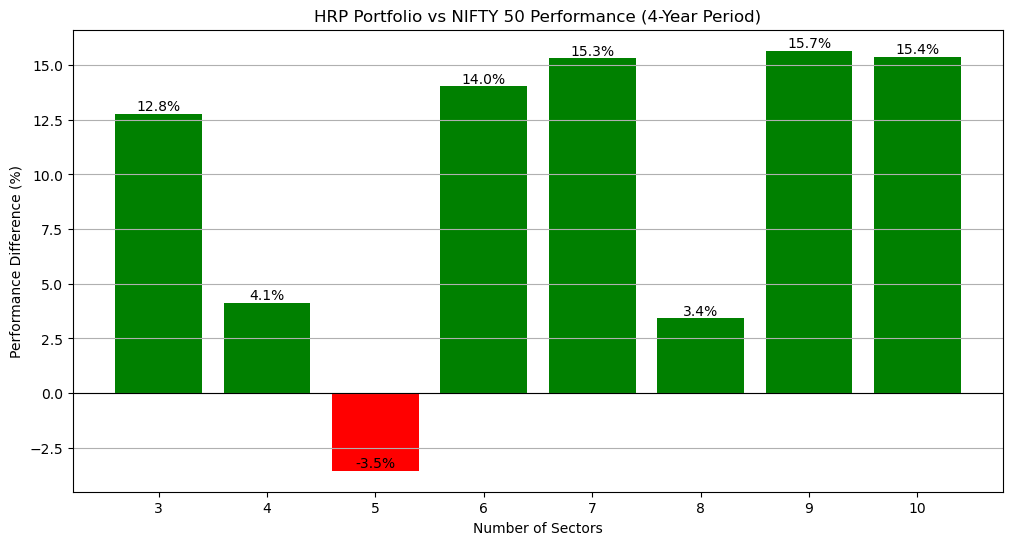


--- Investment Advice as of 2025-04-06 ---
Using training data from 2024-07-27 to 2025-04-05:

--- Top 3 Sectors Recommendation ---
Selected Sectors: [('^NSEBANK', '^NSEBANK'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT')]
Recommended HRP Weights:
  ('^NSEBANK', '^NSEBANK'): 12.50%
  ('^CNXPSUBANK', '^CNXPSUBANK'): 50.00%
  ('^CNXIT', '^CNXIT'): 37.50%
------------------------------------------------------------
--- Top 4 Sectors Recommendation ---
Selected Sectors: [('^NSEBANK', '^NSEBANK'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXSERVICE', '^CNXSERVICE')]
Recommended HRP Weights:
  ('^NSEBANK', '^NSEBANK'): 10.53%
  ('^CNXPSUBANK', '^CNXPSUBANK'): 10.53%
  ('^CNXIT', '^CNXIT'): 31.58%
  ('^CNXSERVICE', '^CNXSERVICE'): 47.37%
------------------------------------------------------------
--- Top 5 Sectors Recommendation ---
Selected Sectors: [('^NSEBANK', '^NSEBANK'), ('^CNXPSUBANK', '^CNXPSUBANK'), ('^CNXIT', '^CNXIT'), ('^CNXSERVICE', '^CNXSERVICE'), ('^CN

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\2951988779.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\U

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd

# =============================================================================
# User Input: Number of Years for Simulation (between 1 and 15)
# =============================================================================
while True:
    try:
        num_years = int(input("Enter the number of years for simulation (1-15): "))
        if 1 <= num_years <= 15:
            break
        else:
            print("Please enter a number between 1 and 15.")
    except ValueError:
        print("Invalid input. Please enter an integer between 1 and 15.")

# =============================================================================
# 1. Data Download and Preprocessing
# =============================================================================
# Define sector tickers
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE"
    # "^CNXCONSUM","NIFTY_MIDCAP_100.NS"    #can be changed
]

# Define the time period based on user input
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * num_years)

# Download data for each sector (using auto-adjusted prices)
data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    if not df.empty and 'Close' in df.columns:
        data_dict[ticker] = df['Close']
    else:
        print(f"Data for {ticker} is missing or incomplete.")

if not data_dict:
    raise ValueError("No sector data downloaded. Check ticker symbols or network connection.")

# Create a DataFrame with aligned dates and drop missing values
prices = pd.concat(data_dict, axis=1).dropna()
returns = prices.pct_change().dropna()

# =============================================================================
# Download Benchmark Data for Trend/Stoploss Analysis (NIFTY 50)
# =============================================================================
benchmark_ticker = "^NSEI"
benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
if benchmark_data.empty:
    raise ValueError("No benchmark data downloaded for trend analysis.")
benchmark_series = benchmark_data['Close'].squeeze()

# =============================================================================
# 2. Correlation Analysis & Clustering for Diversification
# =============================================================================
correlation_matrix = returns.corr()
print(f"\nCorrelation Matrix of Sector Returns (Last {num_years} Years):")
print(correlation_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Sector Returns")
plt.show()

# Use KMeans clustering to assign each sector a cluster (3 clusters chosen here)
kmeans = KMeans(n_clusters=3, random_state=42)
sector_features = correlation_matrix.values
sector_labels = kmeans.fit_predict(sector_features)
sector_cluster_map = dict(zip(correlation_matrix.columns, sector_labels))
print("\nSector Cluster Mapping (for Diversification):")
for sector, cluster in sector_cluster_map.items():
    print(f"  {sector}: Cluster {cluster}")

# =============================================================================
# 3. HRP Weight Calculation Function (with Numerical Stability Fixes)
# =============================================================================
def get_hrp_weights(returns_df):
    """
    Calculate Hierarchical Risk Parity (HRP) weights.
    """
    if returns_df.shape[1] < 2:
        return pd.Series(1.0, index=returns_df.columns)
    
    corr = returns_df.corr().fillna(0)
    corr = 0.5 * (corr + corr.T)
    np.fill_diagonal(corr.values, 1.0)
    dist = np.sqrt(np.clip(0.5 * (1 - corr), 0.0, 1.0))
    dist = 0.5 * (dist + dist.T)
    dist = np.nan_to_num(dist, nan=0.0, posinf=0.0, neginf=0.0)
    
    condensed_dist = ssd.squareform(dist, checks=False)
    link = sch.linkage(condensed_dist, method='ward')
    sorted_indices = sch.leaves_list(link)
    ordered_tickers = returns_df.columns[sorted_indices]
    
    weights = pd.Series(1, index=ordered_tickers)
    cluster_sizes = pd.Series(1, index=ordered_tickers)
    
    for i in range(len(ordered_tickers) - 1):
        left, right = ordered_tickers[i], ordered_tickers[i+1]
        total_size = cluster_sizes[left] + cluster_sizes[right]
        weights[left] *= cluster_sizes[right] / total_size
        weights[right] *= cluster_sizes[left] / total_size
        cluster_sizes[left] = total_size
        cluster_sizes[right] = total_size
    
    return weights / weights.sum()

# =============================================================================
# 4. Diversified Sector Selection Function
# =============================================================================
def select_diversified_sectors(sharpe_scores, n, cluster_map):
    """
    Select top-n sectors based on Sharpe ratio while ensuring diversification.
    """
    sorted_sectors = sharpe_scores.sort_values(ascending=False).index.tolist()
    unique_selected = []
    used_clusters = set()
    for s in sorted_sectors:
        if cluster_map[s] not in used_clusters:
            unique_selected.append(s)
            used_clusters.add(cluster_map[s])
    selected = unique_selected.copy()
    for s in sorted_sectors:
        if len(selected) >= n:
            break
        if s not in selected:
            selected.append(s)
    return selected[:n]

# =============================================================================
# 5. Quarterly Rebalancing Simulation with Enhanced Risk Management & Transaction Costs
# =============================================================================
print("\n--- Quarterly Rebalancing Simulation with Enhanced Risk Management ---\n")
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
stoploss_pct = 0.05  # 5% stoploss threshold
transaction_cost_rate = 0.00075  # 0.15% per trade (0.075% per buying and selling)

results_summary = []
all_quarterly_results = {}

# Updated risk factor function: use a continuous measure.
def get_previous_quarter_risk_factor(i, benchmark_series, quarter_end_dates):
    if i == 0:
        return 1.0
    prev_q_start = prices.index[0] if i-1 == 0 else quarter_end_dates[i-2] + pd.Timedelta(days=1)
    prev_q_end = quarter_end_dates[i-1]
    benchmark_prev = benchmark_series[(benchmark_series.index >= prev_q_start) & (benchmark_series.index <= prev_q_end)]
    if benchmark_prev.empty:
        return 1.0
    prev_return = (benchmark_prev.iloc[-1] / benchmark_prev.iloc[0]) - 1
    risk_factor = np.clip(1 + prev_return, 0.5, 1.0)
    return risk_factor

for n in range(3, 11):
    cumulative_value = initial_capital
    quarterly_returns = []
    quarterly_results = []
    
    print(f"\n===== Simulating for Top {n} Sectors =====\n")
    
    for i, q_end in enumerate(quarter_end_dates):
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            break
        
        # Use ~1 year of training data prior to quarter start
        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]
        if training_prices.empty:
            continue
        training_returns = training_prices.pct_change().dropna()
        if training_returns.empty:
            continue
        
        sharpe_scores = training_returns.mean() / training_returns.std()
        selected_sectors = select_diversified_sectors(sharpe_scores, n, sector_cluster_map)
        if len(selected_sectors) == 0:
            continue
        
        selected_training_returns = training_returns[selected_sectors]
        hrp_weights = get_hrp_weights(selected_training_returns)
        
        period_prices = prices.loc[(prices.index >= q_start) & (prices.index <= q_end), selected_sectors]
        if period_prices.empty or len(period_prices) < 2:
            continue
        
        # Compute raw quarterly return from first to last day
        start_prices = period_prices.iloc[0]
        end_prices = period_prices.iloc[-1]
        sector_period_returns = (end_prices / start_prices) - 1
        raw_portfolio_return = np.dot(hrp_weights.loc[selected_sectors], sector_period_returns)
        
        # --- Intraperiod Stoploss Check --- 
        daily_returns = period_prices.pct_change().dropna()
        daily_portfolio_returns = daily_returns.apply(lambda row: np.dot(hrp_weights.loc[selected_sectors], row), axis=1)
        cum_daily = (1 + daily_portfolio_returns).cumprod()
        if cum_daily.min() < (1 - stoploss_pct):
            stoploss_triggered = True
            stoploss_return = -stoploss_pct
        else:
            stoploss_triggered = False
            stoploss_return = raw_portfolio_return
        
        # Use the updated risk factor function
        risk_factor = get_previous_quarter_risk_factor(i, benchmark_series, quarter_end_dates)
        effective_portfolio_return = risk_factor * stoploss_return
        
        # Incorporate transaction costs on entry and exit:
        # Entry: subtract 0.1% of cumulative_value, Exit: subtract 0.1% of new value.
        net_value_entry = cumulative_value * (1 - transaction_cost_rate)
        new_value = net_value_entry * (1 + effective_portfolio_return)
        net_value_exit = new_value * (1 - transaction_cost_rate)
        
        cumulative_value = net_value_exit
        quarterly_returns.append(effective_portfolio_return)
        
        quarterly_results.append({
            'quarter_start': q_start,
            'quarter_end': q_end,
            'selected_sectors': selected_sectors,
            'hrp_weights': hrp_weights.to_dict(),
            'raw_portfolio_return': raw_portfolio_return,
            'stoploss_triggered': stoploss_triggered,
            'stoploss_return': stoploss_return,
            'risk_factor': risk_factor,
            'effective_portfolio_return': effective_portfolio_return,
            'sector_returns': sector_period_returns.to_dict(),
            'cumulative_value': cumulative_value
        })
        
        print(f"Quarter {q_start.date()} to {q_end.date()}:")
        print(f"  Selected Sectors: {selected_sectors}")
        print("  HRP Weights:")
        for sector in selected_sectors:
            print(f"    {sector}: {hrp_weights[sector]:.2%}")
        print(f"  Raw Portfolio Return: {raw_portfolio_return:.2%}")
        if stoploss_triggered:
            print(f"  STOPLOSS Triggered: Capped Return = {stoploss_return:.2%}")
        print(f"  Risk Factor: {risk_factor:.2f}")
        print(f"  Effective Portfolio Return: {effective_portfolio_return:.2%}")
        print(f"  Cumulative Value after Transaction Costs: ₹{cumulative_value:,.2f}")
        print("-" * 80)
    
    annualized_vol = np.std(quarterly_returns) * np.sqrt(4) if len(quarterly_returns) > 1 else np.nan
    results_summary.append({
        'Number of Sectors': n,
        'HRP Portfolio Value': cumulative_value,
        'Annualized Volatility': annualized_vol
    })
    all_quarterly_results[n] = quarterly_results

hrp_results_df = pd.DataFrame(results_summary)
print("\n=== Simulation Summary for HRP Portfolios (Top N Sectors) ===")
print(hrp_results_df)

# =============================================================================
# Fixed Benchmark Analysis (NIFTY 50)
# =============================================================================
initial_capital_bench = 100000
benchmark_results = []

filtered_data = benchmark_series[benchmark_series.index >= pd.Timestamp(start_date)]
if len(filtered_data) < 2:
    raise ValueError("Not enough benchmark data for the selected period.")

start_price = float(filtered_data.iloc[0])
end_price = float(filtered_data.iloc[-1])
total_return = (end_price / start_price) - 1
cagr = ((1 + total_return) ** (1/num_years)) - 1
final_value = initial_capital_bench * (1 + total_return)

benchmark_results.append({
    'Time Period': f"{num_years} Years",
    'Total Return (%)': round(total_return * 100, 2),
    'CAGR (%)': round(cagr * 100, 2),
    'Final Portfolio Value': round(final_value, 2)
})

benchmark_results_df = pd.DataFrame(benchmark_results)
print(f"\n=== NIFTY 50 Benchmark Performance ({num_years} Years) ===")
print(benchmark_results_df.to_string(index=False))

nifty_final = final_value
comparison_df = hrp_results_df.copy()
comparison_df['NIFTY Value'] = nifty_final
comparison_df['Outperformance (%)'] = (
    (comparison_df['HRP Portfolio Value'] - nifty_final) / nifty_final * 100
).round(2)

print(f"\n=== Final Performance Comparison ({num_years}-Year Period) ===")
print(comparison_df[['Number of Sectors', 'HRP Portfolio Value', 'NIFTY Value', 'Outperformance (%)']].to_string(index=False))

plt.figure(figsize=(12, 6))
bars = plt.bar(
    comparison_df['Number of Sectors'],
    comparison_df['Outperformance (%)'],
    color=np.where(comparison_df['Outperformance (%)'] > 0, 'g', 'r')
)
plt.title(f"HRP Portfolio vs NIFTY 50 Performance ({num_years}-Year Period)")
plt.xlabel("Number of Sectors")
plt.ylabel("Performance Difference (%)")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom')
plt.show()

# =============================================================================
# Investment Advice Based on Last 1 Year Data
# =============================================================================
advice_date = datetime.today()
advice_training_end = advice_date - timedelta(days=1)
advice_training_start = advice_training_end - timedelta(days=252)
if advice_training_start < prices.index[0]:
    advice_training_start = prices.index[0]

advice_training_prices = prices.loc[advice_training_start:advice_training_end].ffill()
advice_training_returns = advice_training_prices.pct_change().dropna()

print(f"\n--- Investment Advice as of {advice_date.date()} ---")
print(f"Using training data from {advice_training_start.date()} to {advice_training_end.date()}:\n")
for n in range(3, 11):
    sharpe_scores = advice_training_returns.mean() / advice_training_returns.std()
    top_n_sectors = select_diversified_sectors(sharpe_scores, n, sector_cluster_map)
    if not top_n_sectors:
        continue
    selected_training_returns = advice_training_returns[top_n_sectors]
    hrp_weights = get_hrp_weights(selected_training_returns)
    print(f"--- Top {n} Sectors Recommendation ---")
    print("Selected Sectors:", top_n_sectors)
    print("Recommended HRP Weights:")
    for sector in top_n_sectors:
        print(f"  {sector}: {hrp_weights[sector]:.2%}")
    print("-" * 60)

PASTE THE BELOW IN CHAT GPT TO UNDERSTAND THE EXPLANATION

COMPONENT EXTRACTION PART

In [1]:
import requests

# Mapping of file identifiers to URLs
files = {
    "^CNXIT": "https://www.niftyindices.com/IndexConstituent/ind_niftyitlist.csv",
    "^CNXAUTO": "https://www.niftyindices.com/IndexConstituent/ind_niftyautolist.csv",
    "^NSEBANK": "https://www.niftyindices.com/IndexConstituent/ind_niftybanklist.csv",
    "^CNXFMCG": "https://www.niftyindices.com/IndexConstituent/ind_niftyfmcglist.csv",
    "^CNXMEDIA": "https://www.niftyindices.com/IndexConstituent/ind_niftymedialist.csv",
    "^CNXMETAL": "https://www.niftyindices.com/IndexConstituent/ind_niftymetallist.csv",
    "^CNXPSE": "https://www.niftyindices.com/IndexConstituent/ind_niftypselist.csv",
    "^CNXMNC": "https://www.niftyindices.com/IndexConstituent/ind_niftymnclist.csv",
    "^CNXINFRA": "https://www.niftyindices.com/IndexConstituent/ind_niftyinfralist.csv",
    "^CNXREALTY": "https://www.niftyindices.com/IndexConstituent/ind_niftyrealtylist.csv",
    "^CNXENERGY": "https://www.niftyindices.com/IndexConstituent/ind_niftyenergylist.csv",
    "^CNXPSUBANK": "https://www.niftyindices.com/IndexConstituent/ind_niftypsubanklist.csv",
    "^CNXSERVICE": "https://www.niftyindices.com/IndexConstituent/ind_niftyfinancelist.csv",
    "^CNXCONSUM": "https://www.niftyindices.com/IndexConstituent/ind_niftyconsumptionlist.csv",
    "NIFTY_MIDCAP_100.NS": "https://www.niftyindices.com/IndexConstituent/ind_niftymidcap100list.csv"
}

# Common headers to mimic a browser
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/115.0.0.0 Safari/537.36"
}

# Download each file
for name, url in files.items():
    print(f"Downloading {name} from {url}...")
    try:
        with requests.get(url, headers=headers, timeout=15, stream=True) as response:
            response.raise_for_status()  # Raises an HTTPError for bad responses
            filename = f"{name}.csv"
            with open(filename, "wb") as file:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:  # Filter out keep-alive chunks
                        file.write(chunk)
        print(f"{filename} downloaded successfully!")
    except requests.exceptions.Timeout:
        print(f"Timeout error: Could not download {name} within the specified time.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {name}: {e}")

^CNXIT.csv downloaded successfully!
^CNXAUTO.csv downloaded successfully!
^NSEBANK.csv downloaded successfully!
^CNXFMCG.csv downloaded successfully!
^CNXMEDIA.csv downloaded successfully!
^CNXMETAL.csv downloaded successfully!
^CNXPSE.csv downloaded successfully!
^CNXMNC.csv downloaded successfully!
^CNXINFRA.csv downloaded successfully!
^CNXREALTY.csv downloaded successfully!
^CNXENERGY.csv downloaded successfully!
^CNXPSUBANK.csv downloaded successfully!
^CNXSERVICE.csv downloaded successfully!
^CNXCONSUM.csv downloaded successfully!
NIFTY_MIDCAP_100.NS.csv downloaded successfully!


In [3]:
import pandas as pd

# Dictionary of sector identifiers to CSV file names
# (Matches the naming convention from the previous download code)
sector_files = {
    "^CNXIT": "^CNXIT.csv",
    "^CNXAUTO": "^CNXAUTO.csv",
    "^NSEBANK": "^NSEBANK.csv",
    "^CNXFMCG": "^CNXFMCG.csv",
    "^CNXMEDIA": "^CNXMEDIA.csv",
    "^CNXMETAL": "^CNXMETAL.csv",
    "^CNXPSE": "^CNXPSE.csv",
    "^CNXMNC": "^CNXMNC.csv",
    "^CNXINFRA": "^CNXINFRA.csv",
    "^CNXREALTY": "^CNXREALTY.csv",
    "^CNXENERGY": "^CNXENERGY.csv",
    "^CNXPSUBANK": "^CNXPSUBANK.csv",
    "^CNXSERVICE": "^CNXSERVICE.csv",
    "^CNXCONSUM": "^CNXCONSUM.csv",
    "NIFTY_MIDCAP_100.NS": "NIFTY_MIDCAP_100.NS.csv"
}

# Dictionary to hold symbols for each sector
all_symbols = {}

for sector, filename in sector_files.items():
    try:
        # Read the CSV into a DataFrame
        df = pd.read_csv(filename)
        
        # Extract the 'Symbol' column as a list
        symbols = df['Symbol'].tolist()
        
        # Store the list of symbols in a dictionary
        all_symbols[sector] = symbols
        
        # Print or otherwise use the symbols
        print(f"Symbols for {sector}:")
        print(symbols)
        print("----------")
    except FileNotFoundError:
        print(f"File not found: {filename}. Please ensure it is downloaded.")
    except KeyError:
        print(f"'Symbol' column not found in {filename}. Check the CSV structure.")
    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")

# Now all_symbols dictionary holds all sector symbols

Symbols for ^CNXIT:
['COFORGE', 'HCLTECH', 'INFY', 'LTIM', 'MPHASIS', 'OFSS', 'PERSISTENT', 'TCS', 'TECHM', 'WIPRO']
----------
Symbols for ^CNXAUTO:
['ASHOKLEY', 'BAJAJ-AUTO', 'BALKRISIND', 'BHARATFORG', 'BOSCHLTD', 'EICHERMOT', 'EXIDEIND', 'HEROMOTOCO', 'MRF', 'M&M', 'MARUTI', 'MOTHERSON', 'TVSMOTOR', 'TATAMOTORS', 'TIINDIA']
----------
Symbols for ^NSEBANK:
['AUBANK', 'AXISBANK', 'BANKBARODA', 'CANBK', 'FEDERALBNK', 'HDFCBANK', 'ICICIBANK', 'IDFCFIRSTB', 'INDUSINDBK', 'KOTAKBANK', 'PNB', 'SBIN']
----------
Symbols for ^CNXFMCG:
['BRITANNIA', 'COLPAL', 'DABUR', 'EMAMILTD', 'GODREJCP', 'HINDUNILVR', 'ITC', 'MARICO', 'NESTLEIND', 'PATANJALI', 'RADICO', 'TATACONSUM', 'UBL', 'UNITDSPR', 'VBL']
----------
Symbols for ^CNXMEDIA:
['DBCORP', 'DISHTV', 'HATHWAY', 'NAZARA', 'NETWORK18', 'PVRINOX', 'SAREGAMA', 'SUNTV', 'TIPSMUSIC', 'ZEEL']
----------
Symbols for ^CNXMETAL:
['APLAPOLLO', 'ADANIENT', 'HINDALCO', 'HINDCOPPER', 'HINDZINC', 'JSWSTEEL', 'JSL', 'JINDALSTEL', 'LLOYDSME', 'NMDC', 'NATIO

In [22]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import time
from pytz import UTC

# Configuration
MIN_YEARS_HISTORY = 10
MIN_DATA_POINTS = 2000
REQUEST_INTERVAL = 1
MAX_RETRIES = 3

# Full sector files dictionary
sector_files = {
    "^CNXIT": "^CNXIT.csv",
    "^CNXAUTO": "^CNXAUTO.csv",
    "^NSEBANK": "^NSEBANK.csv",
    "^CNXFMCG": "^CNXFMCG.csv",
    "^CNXMEDIA": "^CNXMEDIA.csv",
    "^CNXMETAL": "^CNXMETAL.csv",
    "^CNXPSE": "^CNXPSE.csv",
    "^CNXMNC": "^CNXMNC.csv",
    "^CNXINFRA": "^CNXINFRA.csv",
    "^CNXREALTY": "^CNXREALTY.csv",
    "^CNXENERGY": "^CNXENERGY.csv",
    "^CNXPSUBANK": "^CNXPSUBANK.csv",
    "^CNXSERVICE": "^CNXSERVICE.csv",
    "^CNXCONSUM": "^CNXCONSUM.csv",
    "NIFTY_MIDCAP_100.NS": "NIFTY_MIDCAP_100.NS.csv"
}

# Dictionary to hold symbols for each sector (with .NS extension)
all_symbols = {}

# Read CSV files and collect symbols
for sector, filename in sector_files.items():
    try:
        df = pd.read_csv(filename)
        symbols = df['Symbol'].tolist()
        symbols_with_ns = [f"{symbol}.NS" for symbol in symbols]
        all_symbols[sector] = symbols_with_ns
        print(f"Processed {sector} with {len(symbols_with_ns)} symbols")
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        all_symbols[sector] = []

def get_historical_data(symbol, retries=MAX_RETRIES):
    """Get historical data with retry logic"""
    for attempt in range(retries):
        try:
            ticker = yf.Ticker(symbol)
            hist = ticker.history(
                period="max",
                interval="1d",
                actions=False,
                timeout=10
            )
            return hist
        except Exception as e:
            if attempt < retries - 1:
                time.sleep(2)
                continue
            return None

def is_valid_stock(symbol):
    """Validation with listing date tracking"""
    try:
        hist = get_historical_data(symbol)
        listing_date = None
        
        if hist is None or hist.empty:
            return False, None  # No history at all
            
        # Ensure tz-aware index
        if not hist.index.tz:
            hist.index = hist.index.tz_localize(UTC)
            
        # Find first valid date with closing price
        valid_dates = hist[hist['Close'].notna()].index
        if not valid_dates.empty:
            listing_date = valid_dates[0].date()
        else:
            return False, None  # No valid closing prices
            
        # Calculate cutoff date (UTC)
        cutoff_date = pd.Timestamp.now(tz=UTC) - pd.DateOffset(years=MIN_YEARS_HISTORY)
        
        # Check history length
        if valid_dates[0] > cutoff_date:
            return False, listing_date
            
        # Check data points
        valid_data = hist[hist.index >= valid_dates[0]]
        if len(valid_data) < MIN_DATA_POINTS:
            return False, listing_date
            
        # Check recent data
        recent_data = hist.last('30D')
        if recent_data.empty:
            return False, listing_date
            
        return True, listing_date
        
    except Exception as e:
        return False, None

# Validate symbols
validation_results = {}

for sector, symbols in all_symbols.items():
    print(f"\nValidating {sector}...")
    sector_results = {
        'valid': [],
        'invalid': [],
        'total': len(symbols)
    }
    
    for i, symbol in enumerate(symbols):
        time.sleep(REQUEST_INTERVAL)
        
        valid, listing_date = is_valid_stock(symbol)
        if valid:
            sector_results['valid'].append((symbol, listing_date))
        elif listing_date is not None:  # Only include stocks with some history
            sector_results['invalid'].append({
                'symbol': symbol,
                'listing_date': listing_date
            })
            
    validation_results[sector] = sector_results

# Generate invalidated stocks CSV (only includes stocks with known listing dates)
invalid_data = []
for sector, results in validation_results.items():
    for item in results['invalid']:
        invalid_data.append({
            'Sector': sector,
            'Symbol': item['symbol'],
            'ListingDate': item['listing_date'].isoformat()
        })

invalid_df = pd.DataFrame(invalid_data)
invalid_df.to_csv("invalidated_stocks.csv", index=False)
print("\nSaved invalidated stocks to invalidated_stocks.csv")

# Generate validated stocks CSV
valid_data = []
for sector, results in validation_results.items():
    for symbol, listing_date in results['valid']:
        valid_data.append({
            'Sector': sector,
            'Symbol': symbol,
            'ListingDate': listing_date.isoformat()
        })

pd.DataFrame(valid_data).to_csv("validated_stocks2.csv", index=False)
print("Saved validated stocks to validated_stocks2.csv")

Processed ^CNXIT with 10 symbols
Processed ^CNXAUTO with 15 symbols
Processed ^NSEBANK with 12 symbols
Processed ^CNXFMCG with 15 symbols
Processed ^CNXMEDIA with 10 symbols
Processed ^CNXMETAL with 15 symbols
Processed ^CNXPSE with 20 symbols
Processed ^CNXMNC with 31 symbols
Processed ^CNXINFRA with 31 symbols
Processed ^CNXREALTY with 10 symbols
Processed ^CNXENERGY with 41 symbols
Processed ^CNXPSUBANK with 12 symbols
Processed ^CNXSERVICE with 20 symbols
Processed ^CNXCONSUM with 30 symbols
Processed NIFTY_MIDCAP_100.NS with 100 symbols

Validating ^CNXIT...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXAUTO...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^NSEBANK...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXFMCG...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXMEDIA...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXMETAL...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXPSE...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXMNC...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXINFRA...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXREALTY...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXENERGY...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXPSUBANK...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXSERVICE...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating ^CNXCONSUM...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Validating NIFTY_MIDCAP_100.NS...


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last i


Saved invalidated stocks to invalidated_stocks.csv
Saved validated stocks to validated_stocks2.csv


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\861104693.py:98: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = hist.last('30D')


THE CODE BELOW IS LOOPING THROUGH ALL TOP N SECTORS (from 3 to 10)

Enter the number of years for simulation (1-15):  4



Correlation Matrix of Sector Returns (Last 4 Years):
                       ^CNXIT  ^CNXAUTO  ^NSEBANK  ^CNXFMCG  ^CNXMEDIA  \
^CNXIT               1.000000  0.364742  0.349408  0.346862   0.321398   
^CNXAUTO             0.364742  1.000000  0.607015  0.508620   0.519235   
^NSEBANK             0.349408  0.607015  1.000000  0.419604   0.431365   
^CNXFMCG             0.346862  0.508620  0.419604  1.000000   0.349781   
^CNXMEDIA            0.321398  0.519235  0.431365  0.349781   1.000000   
^CNXMETAL            0.364683  0.534661  0.542602  0.307151   0.522988   
^CNXPSE              0.282840  0.569562  0.537292  0.307660   0.543550   
^CNXMNC              0.474414  0.775322  0.618531  0.718776   0.572585   
^CNXINFRA            0.451605  0.711744  0.692162  0.496106   0.577366   
^CNXREALTY           0.356560  0.616175  0.578279  0.407892   0.577689   
^CNXENERGY           0.304804  0.585775  0.583468  0.366718   0.514287   
^CNXPSUBANK          0.249153  0.561647  0.719785  0.32284

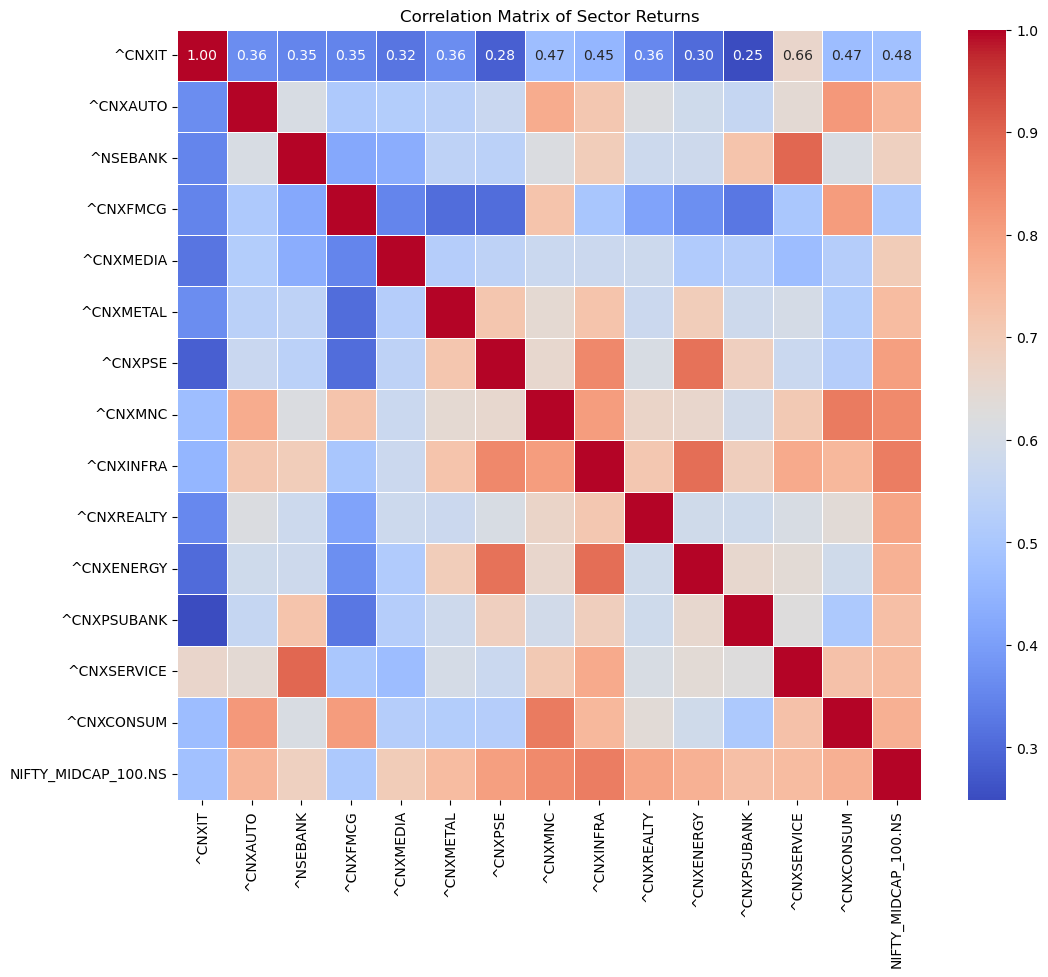

C:\Users\sarda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size



Sector Cluster Mapping (for Diversification):
  ^CNXIT: Cluster 2
  ^CNXAUTO: Cluster 1
  ^NSEBANK: Cluster 0
  ^CNXFMCG: Cluster 1
  ^CNXMEDIA: Cluster 0
  ^CNXMETAL: Cluster 0
  ^CNXPSE: Cluster 0
  ^CNXMNC: Cluster 1
  ^CNXINFRA: Cluster 1
  ^CNXREALTY: Cluster 0
  ^CNXENERGY: Cluster 0
  ^CNXPSUBANK: Cluster 0
  ^CNXSERVICE: Cluster 1
  ^CNXCONSUM: Cluster 1
  NIFTY_MIDCAP_100.NS: Cluster 1
Valid symbols for NIFTY_MIDCAP_100.NS: ['ACC.NS', 'APLAPOLLO.NS', 'ABFRL.NS', 'APOLLOTYRE.NS', 'ASHOKLEY.NS', 'ASTRAL.NS', 'AUROPHARMA.NS', 'BANKINDIA.NS', 'MAHABANK.NS', 'BHARATFORG.NS', 'BHEL.NS', 'BIOCON.NS', 'COFORGE.NS', 'COLPAL.NS', 'CONCOR.NS', 'CUMMINSIND.NS', 'ESCORTS.NS', 'EXIDEIND.NS', 'FEDERALBNK.NS', 'GMRAIRPORT.NS', 'GLENMARK.NS', 'GODREJPROP.NS', 'HINDPETRO.NS', 'HINDZINC.NS', 'IRB.NS', 'INDIANB.NS', 'IGL.NS', 'INDUSTOWER.NS', 'JUBLFOOD.NS', 'LTF.NS', 'LICHSGFIN.NS', 'LUPIN.NS', 'MRF.NS', 'M&MFIN.NS', 'MARICO.NS', 'MFSL.NS', 'MOTILALOFS.NS', 'MPHASIS.NS', 'MUTHOOTFIN.NS', 'NHPC.N

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXMNC', '^CNXIT']
  Sector HRP Weights:
    ^CNXPSE: 12.50%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('HINDPETRO.NS', 'HINDPETRO.NS'): 8.41%
        ('NMDC.NS', 'NMDC.NS'): 9.35%
        ('IOC.NS', 'IOC.NS'): 44.86%
    ^CNXMNC: 50.00%
      Top Stocks & Weights:
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 44.86%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('CRISIL.NS', 'CRISIL.NS'): 9.35%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('WIPRO.NS', 'WIPRO.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
  Raw Portfolio Return: 16.28%
  Benchmark Return: 12.36%
  Risk Factor: 1.00
  Effective Portfolio Return: 16.28%
  Cumul

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXMNC', '^CNXIT', '^CNXPSE']
  Sector HRP Weights:
    ^CNXMNC: 12.50%
      Top Stocks & Weights:
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('UBL.NS', 'UBL.NS'): 28.04%
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 44.86%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 9.35%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 44.86%
    ^CNXPSE: 50.00%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('IOC.NS', 'IOC.NS'): 8.41%
        ('ONGC.NS', 'ONGC.NS'): 44.86%
  Raw Portfolio Return: 5.87%
  Benchmark Return: -1.02%
  Risk Factor: 1.00
  Effective Portfolio Return: 5.87%
  Cumulative 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMNC', '^CNXENERGY']
  Sector HRP Weights:
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
    ^CNXMNC: 12.50%
      Top Stocks & Weights:
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 8.41%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 9.35%
        ('ESCORTS.NS', 'ESCORTS.NS'): 28.04%
        ('UBL.NS', 'UBL.NS'): 9.35%
    ^CNXENERGY: 50.00%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 9.35%
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 28.04%
  Raw Portfolio Return: -4.45%
  STOPLOSS Triggered: Capped Return = -4.45%
  Benchmark 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXENERGY', '^CNXIT', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXENERGY: 12.50%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('CGPOWER.NS', 'CGPOWER.NS'): 44.86%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 28.04%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 28.04%
    ^CNXINFRA: 50.00%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ONGC.NS', 'ONGC.NS'): 9.35%
        ('POWERGRID.NS', 'POWERGRID.NS'): 9.35%
  Raw Portfolio Return: -15.19%
  STOPLOSS Triggered: Capped Return = -5.00%
 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: ['^CNXENERGY', '^CNXAUTO', '^CNXIT']
  Sector HRP Weights:
    ^CNXENERGY: 12.50%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXAUTO: 50.00%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BALKRISIND.NS', 'BALKRISIND.NS'): 28.04%
        ('MARUTI.NS', 'MARUTI.NS'): 9.35%
        ('TATAMOTORS.NS', 'TATAMOTORS.NS'): 44.86%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
  Raw Portfolio Return: 0.24%
  Benchmark Return: 8.52%
  Risk Factor: 0.89


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXCONSUM', '^CNXENERGY', '^CNXIT']
  Sector HRP Weights:
    ^CNXCONSUM: 12.50%
      Top Stocks & Weights:
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 28.04%
        ('ITC.NS', 'ITC.NS'): 9.35%
        ('TRENT.NS', 'TRENT.NS'): 44.86%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
    ^CNXENERGY: 50.00%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 28.04%
        ('INFY.NS', 'INFY.NS'): 9.35%
  Raw Portfolio Return: -3.80%
  Benchmark Return: 7.21%
  Risk Factor: 1.00

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXIT']
  Sector HRP Weights:
    ^CNXPSUBANK: 12.50%
      Top Stocks & Weights:
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('CANBK.NS', 'CANBK.NS'): 44.86%
        ('SBIN.NS', 'SBIN.NS'): 9.35%
    ^CNXFMCG: 50.00%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
        ('MARICO.NS', 'MARICO.NS'): 9.35%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('INFY.NS', 'INFY.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
  Raw Portfolio Return: -7.89%
  Benchmark Return: -4.60%
  Risk Factor: 1.00
  Effective Po

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT']
  Sector HRP Weights:
    ^CNXFMCG: 12.50%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 37.50%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 8.41%
        ('NHPC.NS', 'NHPC.NS'): 44.86%
    ^CNXIT: 50.00%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
  Raw Portfolio Return: 16.09%
  Benchmark Return: 10.29%
  Risk Factor: 0.95
  Effective Portfolio Return: 15.35%
  Cum

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT']
  Sector HRP Weights:
    ^CNXFMCG: 12.50%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 8.41%
        ('RADICO.NS', 'RADICO.NS'): 9.35%
        ('NESTLEIND.NS', 'NESTLEIND.NS'): 28.04%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 37.50%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
    ^CNXIT: 50.00%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
  Raw Portfolio Return: 18.56%
  Benchmark Return: 1.63%
  Risk Factor: 1.00
  Effective Portfolio Ret

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT']
  Sector HRP Weights:
    ^CNXPSE: 12.50%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 50.00%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 44.86%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
  Raw Portfolio Return: 24.92%
  STOPLOSS Triggered: Capped Return = 24.92%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT']
  Sector HRP Weights:
    ^CNXPSE: 12.50%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 50.00%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('PRESTIGE.NS', 'PRESTIGE.NS'): 44.86%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
  Raw Portfolio Return: 13.67%
  Benchmark Return: 2.69%
  Risk Factor: 1.

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXIT']
  Sector HRP Weights:
    ^CNXPSE: 12.50%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXINFRA: 50.00%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
        ('IOC.NS', 'IOC.NS'): 9.35%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
  Raw Portfolio Return: 16.23%
  Benchmark Return: 6.89%
  Risk Factor: 1.00
  Effective Portfolio Retur

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXAUTO', '^CNXIT']
  Sector HRP Weights:
    ^CNXPSE: 12.50%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXAUTO: 50.00%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 9.35%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 44.86%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
  Raw Portfolio Return: 15.85%
  Benchmark Return: 6.91%
  Risk Factor: 1.00
  Effective Portfolio R

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXPSE', '^CNXCONSUM', '^CNXIT']
  Sector HRP Weights:
    ^CNXPSE: 12.50%
      Top Stocks & Weights:
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXCONSUM: 50.00%
      Top Stocks & Weights:
        ('TRENT.NS', 'TRENT.NS'): 8.41%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 44.86%
        ('BHARTIARTL.NS', 'BHARTIARTL.NS'): 9.35%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
  Raw Portfolio Return: 9.44%
  STOPLOSS Triggered: Capped Return = 9.44%
  Benchmark Re

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT']
  Sector HRP Weights:
    ^CNXPSE: 12.50%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 44.86%
        ('OIL.NS', 'OIL.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 50.00%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
  Raw Portfolio Return: -13.05%
  STOPLOSS Triggered: Capped Return = -5.00%
  Benchma

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXMNC', '^CNXIT', '^CNXMETAL']
  Sector HRP Weights:
    ^CNXPSE: 10.53%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('HINDPETRO.NS', 'HINDPETRO.NS'): 8.41%
        ('NMDC.NS', 'NMDC.NS'): 9.35%
        ('IOC.NS', 'IOC.NS'): 44.86%
    ^CNXMNC: 10.53%
      Top Stocks & Weights:
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 44.86%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('CRISIL.NS', 'CRISIL.NS'): 9.35%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('WIPRO.NS', 'WIPRO.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
    ^CNXMETAL: 47.37%
      Top Stocks & Weights:
        ('JSL.NS', 'JSL.NS'): 9.35%
        ('TATASTEEL.NS'

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXMNC', '^CNXIT', '^CNXPSE', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXMNC: 10.53%
      Top Stocks & Weights:
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('UBL.NS', 'UBL.NS'): 28.04%
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 44.86%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 9.35%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 44.86%
    ^CNXPSE: 10.53%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('IOC.NS', 'IOC.NS'): 8.41%
        ('ONGC.NS', 'ONGC.NS'): 44.86%
    ^CNXCONSUM: 47.37%
      Top Stocks & Weights:
        ('TITAN.NS', 'TITAN.NS'): 8.41%
        ('INDHOTEL.NS

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMNC', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
    ^CNXMNC: 10.53%
      Top Stocks & Weights:
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 8.41%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 9.35%
        ('ESCORTS.NS', 'ESCORTS.NS'): 28.04%
        ('UBL.NS', 'UBL.NS'): 9.35%
    ^CNXENERGY: 10.53%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 9.35%
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 47.37%
      Top Stocks & Weights:
     

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXMEDIA']
  Sector HRP Weights:
    ^CNXENERGY: 10.53%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('CGPOWER.NS', 'CGPOWER.NS'): 44.86%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 28.04%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 28.04%
    ^CNXINFRA: 47.37%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ONGC.NS', 'ONGC.NS'): 9.35%
        ('POWERGRID.NS', 'POWERGRID.NS'): 9.35%
    ^CNXMEDIA: 10.53%
      Top Stocks & Weights:
        ('TIPSM

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: ['^CNXENERGY', '^CNXAUTO', '^CNXIT', '^CNXPSE']
  Sector HRP Weights:
    ^CNXENERGY: 10.53%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXAUTO: 10.53%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BALKRISIND.NS', 'BALKRISIND.NS'): 28.04%
        ('MARUTI.NS', 'MARUTI.NS'): 9.35%
        ('TATAMOTORS.NS', 'TATAMOTORS.NS'): 44.86%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSE: 47.37%
      Top Stocks & Weights:
        ('OIL.NS'

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXCONSUM', '^CNXENERGY', '^CNXIT', '^CNXFMCG']
  Sector HRP Weights:
    ^CNXCONSUM: 10.53%
      Top Stocks & Weights:
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 28.04%
        ('ITC.NS', 'ITC.NS'): 9.35%
        ('TRENT.NS', 'TRENT.NS'): 44.86%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
    ^CNXENERGY: 10.53%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 28.04%
        ('INFY.NS', 'INFY.NS'): 9.35%
    ^CNXFMCG: 47.37%
      Top Stocks & Weights:
        ('ITC.N

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXIT', '^CNXENERGY']
  Sector HRP Weights:
    ^CNXPSUBANK: 31.58%
      Top Stocks & Weights:
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('CANBK.NS', 'CANBK.NS'): 44.86%
        ('SBIN.NS', 'SBIN.NS'): 9.35%
    ^CNXFMCG: 10.53%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
        ('MARICO.NS', 'MARICO.NS'): 9.35%
    ^CNXIT: 47.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('INFY.NS', 'INFY.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^CNXENERGY: 10.53%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGP

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXPSUBANK']
  Sector HRP Weights:
    ^CNXFMCG: 10.53%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 31.58%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 8.41%
        ('NHPC.NS', 'NHPC.NS'): 44.86%
    ^CNXIT: 47.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSUBANK: 10.53%
      Top Stocks & Weights:
        ('INDIANB.NS', 'INDIANB.NS'): 8.41%
        (

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXFMCG: 31.58%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 8.41%
        ('RADICO.NS', 'RADICO.NS'): 9.35%
        ('NESTLEIND.NS', 'NESTLEIND.NS'): 28.04%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 10.53%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
    ^CNXIT: 47.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 10.53%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXPSUBANK']
  Sector HRP Weights:
    ^CNXPSE: 10.53%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 47.37%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 44.86%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^CNXPSUBANK: 10.53%
      Top Stocks & Weights:
        (

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXPSE: 10.53%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 10.53%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('PRESTIGE.NS', 'PRESTIGE.NS'): 44.86%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXINFRA: 47.37%
      Top Stocks & Weights:
        ('N

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXIT', '^CNXPSUBANK']
  Sector HRP Weights:
    ^CNXPSE: 10.53%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXINFRA: 47.37%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
        ('IOC.NS', 'IOC.NS'): 9.35%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
    ^CNXPSUBANK: 10.53%
      Top Stocks & Weights:
        ('CANBK.NS', 'CANBK.NS'): 9.3

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXAUTO', '^CNXIT', '^CNXMNC']
  Sector HRP Weights:
    ^CNXPSE: 10.53%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXAUTO: 10.53%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 9.35%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 44.86%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXMNC: 47.37%
      Top Stocks & Weights:
        ('ABB.NS', 'ABB.NS'): 8.41%
     

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXPSE', '^CNXCONSUM', '^CNXIT', '^CNXAUTO']
  Sector HRP Weights:
    ^CNXPSE: 10.53%
      Top Stocks & Weights:
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXCONSUM: 10.53%
      Top Stocks & Weights:
        ('TRENT.NS', 'TRENT.NS'): 8.41%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 44.86%
        ('BHARTIARTL.NS', 'BHARTIARTL.NS'): 9.35%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXAUTO: 47.37%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TV

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXPSE: 10.53%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 44.86%
        ('OIL.NS', 'OIL.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 47.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
    ^CNXIT: 31.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 10.53%
      Top Stocks & Weights:
        ('TRENT.NS', 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXMNC', '^CNXIT', '^CNXMETAL', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXPSE: 9.35%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('HINDPETRO.NS', 'HINDPETRO.NS'): 8.41%
        ('NMDC.NS', 'NMDC.NS'): 9.35%
        ('IOC.NS', 'IOC.NS'): 44.86%
    ^CNXMNC: 8.41%
      Top Stocks & Weights:
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 44.86%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('CRISIL.NS', 'CRISIL.NS'): 9.35%
    ^CNXIT: 28.04%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('WIPRO.NS', 'WIPRO.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
    ^CNXMETAL: 9.35%
      Top Stocks & Weights:
        ('JSL.NS', 'JSL.NS'): 9.35%
   

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXMNC', '^CNXIT', '^CNXPSE', '^CNXCONSUM', '^CNXFMCG']
  Sector HRP Weights:
    ^CNXMNC: 8.41%
      Top Stocks & Weights:
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('UBL.NS', 'UBL.NS'): 28.04%
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 44.86%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 9.35%
    ^CNXIT: 9.35%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 44.86%
    ^CNXPSE: 28.04%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('IOC.NS', 'IOC.NS'): 8.41%
        ('ONGC.NS', 'ONGC.NS'): 44.86%
    ^CNXCONSUM: 44.86%
      Top Stocks & Weights:
        ('TITAN.NS', 'TITAN.NS'): 8.41%
        ('I

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMNC', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXIT: 28.04%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
    ^CNXMNC: 8.41%
      Top Stocks & Weights:
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 8.41%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 9.35%
        ('ESCORTS.NS', 'ESCORTS.NS'): 28.04%
        ('UBL.NS', 'UBL.NS'): 9.35%
    ^CNXENERGY: 9.35%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 9.35%
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 44.86%
      Top Stocks & We

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXMEDIA', '^CNXMETAL']
  Sector HRP Weights:
    ^CNXENERGY: 8.41%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('CGPOWER.NS', 'CGPOWER.NS'): 44.86%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 28.04%
    ^CNXIT: 28.04%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 28.04%
    ^CNXINFRA: 44.86%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ONGC.NS', 'ONGC.NS'): 9.35%
        ('POWERGRID.NS', 'POWERGRID.NS'): 9.35%
    ^CNXMEDIA: 9.35%
      Top Stocks & Weights:
    

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: ['^CNXENERGY', '^CNXAUTO', '^CNXIT', '^CNXPSE', '^CNXMEDIA']
  Sector HRP Weights:
    ^CNXENERGY: 9.35%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXAUTO: 8.41%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BALKRISIND.NS', 'BALKRISIND.NS'): 28.04%
        ('MARUTI.NS', 'MARUTI.NS'): 9.35%
        ('TATAMOTORS.NS', 'TATAMOTORS.NS'): 44.86%
    ^CNXIT: 28.04%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSE: 9.35%
      Top Stocks & Weights:
       

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXCONSUM', '^CNXENERGY', '^CNXIT', '^CNXFMCG', '^CNXMNC']
  Sector HRP Weights:
    ^CNXCONSUM: 8.41%
      Top Stocks & Weights:
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 28.04%
        ('ITC.NS', 'ITC.NS'): 9.35%
        ('TRENT.NS', 'TRENT.NS'): 44.86%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
    ^CNXENERGY: 9.35%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXIT: 28.04%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 28.04%
        ('INFY.NS', 'INFY.NS'): 9.35%
    ^CNXFMCG: 9.35%
      Top Stocks & Weights:
       

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXIT', '^CNXENERGY', '^CNXPSE']
  Sector HRP Weights:
    ^CNXPSUBANK: 28.04%
      Top Stocks & Weights:
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('CANBK.NS', 'CANBK.NS'): 44.86%
        ('SBIN.NS', 'SBIN.NS'): 9.35%
    ^CNXFMCG: 8.41%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
        ('MARICO.NS', 'MARICO.NS'): 9.35%
    ^CNXIT: 44.86%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('INFY.NS', 'INFY.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^CNXENERGY: 9.35%
      Top Stocks & Weights:
        ('CGPOWER.

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXPSUBANK', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXFMCG: 8.41%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 9.35%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 8.41%
        ('NHPC.NS', 'NHPC.NS'): 44.86%
    ^CNXIT: 44.86%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSUBANK: 28.04%
      Top Stocks & Weights:
        ('INDIANB.NS', 'INDIANB.NS'): 8.41

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXCONSUM', '^CNXPSUBANK']
  Sector HRP Weights:
    ^CNXFMCG: 8.41%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 8.41%
        ('RADICO.NS', 'RADICO.NS'): 9.35%
        ('NESTLEIND.NS', 'NESTLEIND.NS'): 28.04%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 28.04%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
    ^CNXIT: 9.35%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 44.86%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG']
  Sector HRP Weights:
    ^CNXPSE: 9.35%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 9.35%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 44.86%
    ^CNXIT: 8.41%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^CNXPSUBANK: 28.04%
      Top Stocks & Weights:


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXINFRA', '^CNXFMCG']
  Sector HRP Weights:
    ^CNXPSE: 28.04%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 9.35%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('PRESTIGE.NS', 'PRESTIGE.NS'): 44.86%
    ^CNXIT: 8.41%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXINFRA: 9.35%
      Top Stocks & Weights:
  

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXIT', '^CNXPSUBANK', '^CNXAUTO']
  Sector HRP Weights:
    ^CNXPSE: 8.41%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXINFRA: 44.86%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
        ('IOC.NS', 'IOC.NS'): 9.35%
    ^CNXIT: 28.04%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
    ^CNXPSUBANK: 9.35%
      Top Stocks & Weights:
        ('CANBK.NS', 'CANBK

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXAUTO', '^CNXIT', '^CNXMNC', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXPSE: 9.35%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXAUTO: 8.41%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 9.35%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 44.86%
    ^CNXIT: 28.04%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXMNC: 44.86%
      Top Stocks & Weights:
        ('ABB.NS', 'ABB.NS'): 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXPSE', '^CNXCONSUM', '^CNXIT', '^CNXAUTO', '^CNXMNC']
  Sector HRP Weights:
    ^CNXPSE: 9.35%
      Top Stocks & Weights:
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXCONSUM: 8.41%
      Top Stocks & Weights:
        ('TRENT.NS', 'TRENT.NS'): 8.41%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 44.86%
        ('BHARTIARTL.NS', 'BHARTIARTL.NS'): 9.35%
    ^CNXIT: 28.04%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXAUTO: 9.35%
      Top Stocks & Weights:
        ('TVSMOTOR.

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXCONSUM', '^CNXAUTO']
  Sector HRP Weights:
    ^CNXPSE: 8.41%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 44.86%
        ('OIL.NS', 'OIL.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 44.86%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
    ^CNXIT: 28.04%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 9.35%
      Top Stocks & Weights:
        ('T

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXMNC', '^CNXIT', '^CNXMETAL', 'NIFTY_MIDCAP_100.NS', '^CNXMEDIA']
  Sector HRP Weights:
    ^CNXPSE: 7.69%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('HINDPETRO.NS', 'HINDPETRO.NS'): 8.41%
        ('NMDC.NS', 'NMDC.NS'): 9.35%
        ('IOC.NS', 'IOC.NS'): 44.86%
    ^CNXMNC: 6.84%
      Top Stocks & Weights:
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 44.86%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('CRISIL.NS', 'CRISIL.NS'): 9.35%
    ^CNXIT: 25.64%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('WIPRO.NS', 'WIPRO.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
    ^CNXMETAL: 8.55%
      Top Stocks & Weights:
        ('JSL.NS', 'JSL.NS

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXMNC', '^CNXIT', '^CNXPSE', '^CNXCONSUM', '^CNXFMCG', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXMNC: 8.55%
      Top Stocks & Weights:
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('UBL.NS', 'UBL.NS'): 28.04%
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 44.86%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 9.35%
    ^CNXIT: 7.69%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 44.86%
    ^CNXPSE: 25.64%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('IOC.NS', 'IOC.NS'): 8.41%
        ('ONGC.NS', 'ONGC.NS'): 44.86%
    ^CNXCONSUM: 6.84%
      Top Stocks & Weights:
        ('TITAN.NS', 'TITAN.NS'): 8.41%

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMNC', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXIT: 25.64%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
    ^CNXMNC: 8.55%
      Top Stocks & Weights:
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 8.41%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 9.35%
        ('ESCORTS.NS', 'ESCORTS.NS'): 28.04%
        ('UBL.NS', 'UBL.NS'): 9.35%
    ^CNXENERGY: 7.69%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 9.35%
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 6.84%
      Top

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXMEDIA', '^CNXMETAL', '^CNXPSE']
  Sector HRP Weights:
    ^CNXENERGY: 6.84%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('CGPOWER.NS', 'CGPOWER.NS'): 44.86%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 28.04%
    ^CNXIT: 25.64%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 28.04%
    ^CNXINFRA: 7.69%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ONGC.NS', 'ONGC.NS'): 9.35%
        ('POWERGRID.NS', 'POWERGRID.NS'): 9.35%
    ^CNXMEDIA: 8.55%
      Top Stocks & Wei

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: ['^CNXENERGY', '^CNXAUTO', '^CNXIT', '^CNXPSE', '^CNXMEDIA', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXENERGY: 25.64%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXAUTO: 6.84%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BALKRISIND.NS', 'BALKRISIND.NS'): 28.04%
        ('MARUTI.NS', 'MARUTI.NS'): 9.35%
        ('TATAMOTORS.NS', 'TATAMOTORS.NS'): 44.86%
    ^CNXIT: 8.55%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSE: 8.55%
      Top Stocks & We

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXCONSUM', '^CNXENERGY', '^CNXIT', '^CNXFMCG', '^CNXMNC', '^CNXPSE']
  Sector HRP Weights:
    ^CNXCONSUM: 6.84%
      Top Stocks & Weights:
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 28.04%
        ('ITC.NS', 'ITC.NS'): 9.35%
        ('TRENT.NS', 'TRENT.NS'): 44.86%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
    ^CNXENERGY: 25.64%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXIT: 8.55%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 28.04%
        ('INFY.NS', 'INFY.NS'): 9.35%
    ^CNXFMCG: 7.69%
      Top Stocks & Weigh

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXMETAL']
  Sector HRP Weights:
    ^CNXPSUBANK: 25.64%
      Top Stocks & Weights:
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('CANBK.NS', 'CANBK.NS'): 44.86%
        ('SBIN.NS', 'SBIN.NS'): 9.35%
    ^CNXFMCG: 6.84%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
        ('MARICO.NS', 'MARICO.NS'): 9.35%
    ^CNXIT: 42.74%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('INFY.NS', 'INFY.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^CNXENERGY: 8.55%
      Top Stocks & Weights:
     

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXPSUBANK', '^CNXINFRA', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXFMCG: 6.84%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 8.55%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 8.41%
        ('NHPC.NS', 'NHPC.NS'): 44.86%
    ^CNXIT: 7.69%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSUBANK: 25.64%
      Top Stocks & Weights:
        ('INDIANB.NS', 'INDIA

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXCONSUM', '^CNXPSUBANK', '^CNXMNC']
  Sector HRP Weights:
    ^CNXFMCG: 7.69%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 8.41%
        ('RADICO.NS', 'RADICO.NS'): 9.35%
        ('NESTLEIND.NS', 'NESTLEIND.NS'): 28.04%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 25.64%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
    ^CNXIT: 8.55%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 6.84%
      Top Stocks & Weights:
        ('ITC.

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXPSE: 8.55%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 8.55%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 44.86%
    ^CNXIT: 6.84%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^CNXPSUBANK: 25.64%
      Top Stock

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXINFRA', '^CNXFMCG', '^CNXPSUBANK']
  Sector HRP Weights:
    ^CNXPSE: 8.55%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 8.55%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('PRESTIGE.NS', 'PRESTIGE.NS'): 44.86%
    ^CNXIT: 6.84%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXINFRA: 7.69%
      Top Stocks

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXIT', '^CNXPSUBANK', '^CNXAUTO', '^CNXENERGY']
  Sector HRP Weights:
    ^CNXPSE: 8.55%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXINFRA: 8.55%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
        ('IOC.NS', 'IOC.NS'): 9.35%
    ^CNXIT: 25.64%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
    ^CNXPSUBANK: 6.84%
      Top Stocks & Weights:
        ('CANB

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXAUTO', '^CNXIT', '^CNXMNC', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXPSE: 8.55%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXAUTO: 8.55%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 9.35%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 44.86%
    ^CNXIT: 25.64%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXMNC: 7.69%
      Top Stocks & Weights:
        

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXPSE', '^CNXCONSUM', '^CNXIT', '^CNXAUTO', '^CNXMNC', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXPSE: 8.55%
      Top Stocks & Weights:
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXCONSUM: 6.84%
      Top Stocks & Weights:
        ('TRENT.NS', 'TRENT.NS'): 8.41%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 44.86%
        ('BHARTIARTL.NS', 'BHARTIARTL.NS'): 9.35%
    ^CNXIT: 25.64%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXAUTO: 7.69%
      Top Stocks & Weigh

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXCONSUM', '^CNXAUTO', '^CNXREALTY']
  Sector HRP Weights:
    ^CNXPSE: 6.84%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 44.86%
        ('OIL.NS', 'OIL.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 42.74%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
    ^CNXIT: 25.64%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 8.55%
      Top Stocks & Weight

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXMNC', '^CNXIT', '^CNXMETAL', 'NIFTY_MIDCAP_100.NS', '^CNXMEDIA', '^CNXPSUBANK']
  Sector HRP Weights:
    ^CNXPSE: 6.37%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('HINDPETRO.NS', 'HINDPETRO.NS'): 8.41%
        ('NMDC.NS', 'NMDC.NS'): 9.35%
        ('IOC.NS', 'IOC.NS'): 44.86%
    ^CNXMNC: 5.69%
      Top Stocks & Weights:
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 44.86%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('CRISIL.NS', 'CRISIL.NS'): 9.35%
    ^CNXIT: 23.89%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('WIPRO.NS', 'WIPRO.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
    ^CNXMETAL: 7.96%
      Top Stocks & Weights:
        ('J

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXMNC', '^CNXIT', '^CNXPSE', '^CNXCONSUM', '^CNXFMCG', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXMNC: 7.96%
      Top Stocks & Weights:
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('UBL.NS', 'UBL.NS'): 28.04%
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 44.86%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 9.35%
    ^CNXIT: 6.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 44.86%
    ^CNXPSE: 23.89%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('IOC.NS', 'IOC.NS'): 8.41%
        ('ONGC.NS', 'ONGC.NS'): 44.86%
    ^CNXCONSUM: 5.69%
      Top Stocks & Weights:
        ('TITAN.

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMNC', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM', '^CNXINFRA', '^CNXREALTY']
  Sector HRP Weights:
    ^CNXIT: 23.89%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
    ^CNXMNC: 7.96%
      Top Stocks & Weights:
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 8.41%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 9.35%
        ('ESCORTS.NS', 'ESCORTS.NS'): 28.04%
        ('UBL.NS', 'UBL.NS'): 9.35%
    ^CNXENERGY: 6.37%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 9.35%
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 5

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXMEDIA', '^CNXMETAL', '^CNXPSE', '^CNXREALTY']
  Sector HRP Weights:
    ^CNXENERGY: 7.17%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('CGPOWER.NS', 'CGPOWER.NS'): 44.86%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 28.04%
    ^CNXIT: 23.89%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 28.04%
    ^CNXINFRA: 7.96%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ONGC.NS', 'ONGC.NS'): 9.35%
        ('POWERGRID.NS', 'POWERGRID.NS'): 9.35%
    ^CNXMEDIA: 5.69%
      To

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: ['^CNXENERGY', '^CNXAUTO', '^CNXIT', '^CNXPSE', '^CNXMEDIA', '^CNXCONSUM', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXENERGY: 7.96%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXAUTO: 5.69%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BALKRISIND.NS', 'BALKRISIND.NS'): 28.04%
        ('MARUTI.NS', 'MARUTI.NS'): 9.35%
        ('TATAMOTORS.NS', 'TATAMOTORS.NS'): 44.86%
    ^CNXIT: 7.17%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSE: 23.89%
      To

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXCONSUM', '^CNXENERGY', '^CNXIT', '^CNXFMCG', '^CNXMNC', '^CNXPSE', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXCONSUM: 5.69%
      Top Stocks & Weights:
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 28.04%
        ('ITC.NS', 'ITC.NS'): 9.35%
        ('TRENT.NS', 'TRENT.NS'): 44.86%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
    ^CNXENERGY: 23.89%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXIT: 7.96%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 28.04%
        ('INFY.NS', 'INFY.NS'): 9.35%
    ^CNXFMCG: 7.17%
 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXMETAL', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXPSUBANK: 23.89%
      Top Stocks & Weights:
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('CANBK.NS', 'CANBK.NS'): 44.86%
        ('SBIN.NS', 'SBIN.NS'): 9.35%
    ^CNXFMCG: 5.69%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
        ('MARICO.NS', 'MARICO.NS'): 9.35%
    ^CNXIT: 6.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('INFY.NS', 'INFY.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^CNXENERGY: 7.96%
      Top Stocks & W

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXPSUBANK', '^CNXINFRA', '^CNXCONSUM', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXFMCG: 5.69%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 7.96%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 8.41%
        ('NHPC.NS', 'NHPC.NS'): 44.86%
    ^CNXIT: 6.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSUBANK: 23.89%
      Top Stocks & Weights:
      

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXCONSUM', '^CNXPSUBANK', '^CNXMNC', '^CNXAUTO']
  Sector HRP Weights:
    ^CNXFMCG: 6.37%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 8.41%
        ('RADICO.NS', 'RADICO.NS'): 9.35%
        ('NESTLEIND.NS', 'NESTLEIND.NS'): 28.04%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 23.89%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
    ^CNXIT: 7.96%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 5.69%
      Top Stocks & Weights:
  

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA', '^CNXAUTO']
  Sector HRP Weights:
    ^CNXPSE: 7.96%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 7.17%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 44.86%
    ^CNXIT: 5.69%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^CNXPSUBANK: 23.89%
   

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXINFRA', '^CNXFMCG', '^CNXPSUBANK', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXPSE: 7.96%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 7.96%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('PRESTIGE.NS', 'PRESTIGE.NS'): 44.86%
    ^CNXIT: 6.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXINFRA: 7.17%
  

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXIT', '^CNXPSUBANK', '^CNXAUTO', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXPSE: 5.69%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXINFRA: 7.17%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
        ('IOC.NS', 'IOC.NS'): 9.35%
    ^CNXIT: 23.89%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
    ^CNXPSUBANK: 7.96%
      Top Stocks & 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXAUTO', '^CNXIT', '^CNXMNC', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXPSE: 7.96%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXAUTO: 6.37%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 9.35%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 44.86%
    ^CNXIT: 23.89%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXMNC: 5.69%
      Top Stocks & Wei

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXPSE', '^CNXCONSUM', '^CNXIT', '^CNXAUTO', '^CNXMNC', 'NIFTY_MIDCAP_100.NS', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXPSE: 7.96%
      Top Stocks & Weights:
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXCONSUM: 5.69%
      Top Stocks & Weights:
        ('TRENT.NS', 'TRENT.NS'): 8.41%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 44.86%
        ('BHARTIARTL.NS', 'BHARTIARTL.NS'): 9.35%
    ^CNXIT: 23.89%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXAUTO: 6.37%
      Top S

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXCONSUM', '^CNXAUTO', '^CNXREALTY', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXPSE: 6.37%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 44.86%
        ('OIL.NS', 'OIL.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 5.69%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
    ^CNXIT: 23.89%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 7.96%
      Top Sto

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXMNC', '^CNXIT', '^CNXMETAL', 'NIFTY_MIDCAP_100.NS', '^CNXMEDIA', '^CNXPSUBANK', '^CNXENERGY']
  Sector HRP Weights:
    ^CNXPSE: 4.83%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('HINDPETRO.NS', 'HINDPETRO.NS'): 8.41%
        ('NMDC.NS', 'NMDC.NS'): 9.35%
        ('IOC.NS', 'IOC.NS'): 44.86%
    ^CNXMNC: 6.76%
      Top Stocks & Weights:
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 44.86%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('CRISIL.NS', 'CRISIL.NS'): 9.35%
    ^CNXIT: 22.54%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('WIPRO.NS', 'WIPRO.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
    ^CNXMETAL: 7.51%
      Top Stocks & Weight

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXMNC', '^CNXIT', '^CNXPSE', '^CNXCONSUM', '^CNXFMCG', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS', '^CNXENERGY']
  Sector HRP Weights:
    ^CNXMNC: 7.51%
      Top Stocks & Weights:
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('UBL.NS', 'UBL.NS'): 28.04%
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 44.86%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 9.35%
    ^CNXIT: 5.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 44.86%
    ^CNXPSE: 22.54%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('IOC.NS', 'IOC.NS'): 8.41%
        ('ONGC.NS', 'ONGC.NS'): 44.86%
    ^CNXCONSUM: 4.83%
      Top Stocks & Weights:
  

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMNC', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM', '^CNXINFRA', '^CNXREALTY', '^CNXSERVICE']
  Sector HRP Weights:
    ^CNXIT: 22.54%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
    ^CNXMNC: 7.51%
      Top Stocks & Weights:
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 8.41%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 9.35%
        ('ESCORTS.NS', 'ESCORTS.NS'): 28.04%
        ('UBL.NS', 'UBL.NS'): 9.35%
    ^CNXENERGY: 5.37%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 9.35%
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 28.04%
    NIFTY_M

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXMEDIA', '^CNXMETAL', '^CNXPSE', '^CNXREALTY', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXENERGY: 4.83%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('CGPOWER.NS', 'CGPOWER.NS'): 44.86%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 28.04%
    ^CNXIT: 22.54%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 28.04%
    ^CNXINFRA: 6.76%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ONGC.NS', 'ONGC.NS'): 9.35%
        ('POWERGRID.NS', 'POWERGRID.NS'): 9.35%
    ^C

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: ['^CNXENERGY', '^CNXAUTO', '^CNXIT', '^CNXPSE', '^CNXMEDIA', '^CNXCONSUM', '^CNXINFRA', '^CNXREALTY']
  Sector HRP Weights:
    ^CNXENERGY: 7.51%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXAUTO: 6.01%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BALKRISIND.NS', 'BALKRISIND.NS'): 28.04%
        ('MARUTI.NS', 'MARUTI.NS'): 9.35%
        ('TATAMOTORS.NS', 'TATAMOTORS.NS'): 44.86%
    ^CNXIT: 22.54%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSE: 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXCONSUM', '^CNXENERGY', '^CNXIT', '^CNXFMCG', '^CNXMNC', '^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXPSUBANK']
  Sector HRP Weights:
    ^CNXCONSUM: 4.83%
      Top Stocks & Weights:
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 28.04%
        ('ITC.NS', 'ITC.NS'): 9.35%
        ('TRENT.NS', 'TRENT.NS'): 44.86%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
    ^CNXENERGY: 7.51%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXIT: 6.76%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 28.04%
        ('INFY.NS', 'INFY.NS'): 9.35%
    ^CN

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXMETAL', '^CNXCONSUM', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXPSUBANK: 22.54%
      Top Stocks & Weights:
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('CANBK.NS', 'CANBK.NS'): 44.86%
        ('SBIN.NS', 'SBIN.NS'): 9.35%
    ^CNXFMCG: 4.83%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
        ('MARICO.NS', 'MARICO.NS'): 9.35%
    ^CNXIT: 5.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('INFY.NS', 'INFY.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^CNXENERGY: 6.76%
      T

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXPSUBANK', '^CNXINFRA', '^CNXCONSUM', 'NIFTY_MIDCAP_100.NS', '^CNXMNC']
  Sector HRP Weights:
    ^CNXFMCG: 5.37%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 7.51%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 8.41%
        ('NHPC.NS', 'NHPC.NS'): 44.86%
    ^CNXIT: 6.01%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSUBANK: 22.54%
      Top Stocks & Weig

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXCONSUM', '^CNXPSUBANK', '^CNXMNC', '^CNXAUTO', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXFMCG: 6.76%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 8.41%
        ('RADICO.NS', 'RADICO.NS'): 9.35%
        ('NESTLEIND.NS', 'NESTLEIND.NS'): 28.04%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 7.51%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
    ^CNXIT: 22.54%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 4.83%
      T

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA', '^CNXAUTO', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXPSE: 7.51%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 6.76%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 44.86%
    ^CNXIT: 5.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^CNXPSUBA

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXINFRA', '^CNXFMCG', '^CNXPSUBANK', '^CNXCONSUM', '^CNXAUTO']
  Sector HRP Weights:
    ^CNXPSE: 7.51%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 6.76%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('PRESTIGE.NS', 'PRESTIGE.NS'): 44.86%
    ^CNXIT: 5.37%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXINF

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXIT', '^CNXPSUBANK', '^CNXAUTO', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXPSE: 4.83%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXINFRA: 6.01%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
        ('IOC.NS', 'IOC.NS'): 9.35%
    ^CNXIT: 22.54%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
    ^CNXPSUBANK: 6.76%
     

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXAUTO', '^CNXIT', '^CNXMNC', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM', '^CNXREALTY']
  Sector HRP Weights:
    ^CNXPSE: 5.37%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXAUTO: 7.51%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 9.35%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 44.86%
    ^CNXIT: 22.54%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXMNC: 7.51%
      To

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXPSE', '^CNXCONSUM', '^CNXIT', '^CNXAUTO', '^CNXMNC', 'NIFTY_MIDCAP_100.NS', '^CNXINFRA', '^CNXFMCG']
  Sector HRP Weights:
    ^CNXPSE: 7.51%
      Top Stocks & Weights:
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXCONSUM: 4.83%
      Top Stocks & Weights:
        ('TRENT.NS', 'TRENT.NS'): 8.41%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 44.86%
        ('BHARTIARTL.NS', 'BHARTIARTL.NS'): 9.35%
    ^CNXIT: 22.54%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXAUTO: 5.37%

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXCONSUM', '^CNXAUTO', '^CNXREALTY', '^CNXINFRA', '^CNXMNC']
  Sector HRP Weights:
    ^CNXPSE: 5.37%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 44.86%
        ('OIL.NS', 'OIL.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 4.83%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
    ^CNXIT: 22.54%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 7.51%
  

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXMNC', '^CNXIT', '^CNXMETAL', 'NIFTY_MIDCAP_100.NS', '^CNXMEDIA', '^CNXPSUBANK', '^CNXENERGY', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXPSE: 4.17%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('HINDPETRO.NS', 'HINDPETRO.NS'): 8.41%
        ('NMDC.NS', 'NMDC.NS'): 9.35%
        ('IOC.NS', 'IOC.NS'): 44.86%
    ^CNXMNC: 6.44%
      Top Stocks & Weights:
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 44.86%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('CRISIL.NS', 'CRISIL.NS'): 9.35%
    ^CNXIT: 21.47%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('WIPRO.NS', 'WIPRO.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
    ^CNXMETAL: 5.11%
      Top S

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXMNC', '^CNXIT', '^CNXPSE', '^CNXCONSUM', '^CNXFMCG', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS', '^CNXENERGY', '^CNXREALTY']
  Sector HRP Weights:
    ^CNXMNC: 6.44%
      Top Stocks & Weights:
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('UBL.NS', 'UBL.NS'): 28.04%
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 44.86%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 9.35%
    ^CNXIT: 4.60%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 44.86%
    ^CNXPSE: 21.47%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('IOC.NS', 'IOC.NS'): 8.41%
        ('ONGC.NS', 'ONGC.NS'): 44.86%
    ^CNXCONSUM: 4.17%
      Top Stocks

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMNC', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM', '^CNXINFRA', '^CNXREALTY', '^CNXSERVICE', '^CNXMEDIA']
  Sector HRP Weights:
    ^CNXIT: 21.47%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
    ^CNXMNC: 7.16%
      Top Stocks & Weights:
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 8.41%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 9.35%
        ('ESCORTS.NS', 'ESCORTS.NS'): 28.04%
        ('UBL.NS', 'UBL.NS'): 9.35%
    ^CNXENERGY: 5.72%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 9.35%
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 28.04

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXMEDIA', '^CNXMETAL', '^CNXPSE', '^CNXREALTY', 'NIFTY_MIDCAP_100.NS', '^CNXSERVICE']
  Sector HRP Weights:
    ^CNXENERGY: 7.16%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('CGPOWER.NS', 'CGPOWER.NS'): 44.86%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 28.04%
    ^CNXIT: 21.47%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 28.04%
    ^CNXINFRA: 4.17%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ONGC.NS', 'ONGC.NS'): 9.35%
        ('POWERGRID.NS', 'POWERGRID.NS'

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: ['^CNXENERGY', '^CNXAUTO', '^CNXIT', '^CNXPSE', '^CNXMEDIA', '^CNXCONSUM', '^CNXINFRA', '^CNXREALTY', '^CNXFMCG']
  Sector HRP Weights:
    ^CNXENERGY: 5.72%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXAUTO: 4.17%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BALKRISIND.NS', 'BALKRISIND.NS'): 28.04%
        ('MARUTI.NS', 'MARUTI.NS'): 9.35%
        ('TATAMOTORS.NS', 'TATAMOTORS.NS'): 44.86%
    ^CNXIT: 21.47%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXCONSUM', '^CNXENERGY', '^CNXIT', '^CNXFMCG', '^CNXMNC', '^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXPSUBANK', '^CNXAUTO']
  Sector HRP Weights:
    ^CNXCONSUM: 4.17%
      Top Stocks & Weights:
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 28.04%
        ('ITC.NS', 'ITC.NS'): 9.35%
        ('TRENT.NS', 'TRENT.NS'): 44.86%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
    ^CNXENERGY: 7.16%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXIT: 6.44%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 28.04%
        ('INFY.NS', 'INFY.NS'): 9

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXMETAL', '^CNXCONSUM', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS']
  Sector HRP Weights:
    ^CNXPSUBANK: 21.47%
      Top Stocks & Weights:
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('CANBK.NS', 'CANBK.NS'): 44.86%
        ('SBIN.NS', 'SBIN.NS'): 9.35%
    ^CNXFMCG: 4.17%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
        ('MARICO.NS', 'MARICO.NS'): 9.35%
    ^CNXIT: 4.60%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('INFY.NS', 'INFY.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
    ^C

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXPSUBANK', '^CNXINFRA', '^CNXCONSUM', 'NIFTY_MIDCAP_100.NS', '^CNXMNC', '^CNXENERGY']
  Sector HRP Weights:
    ^CNXFMCG: 4.60%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 6.44%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 8.41%
        ('NHPC.NS', 'NHPC.NS'): 44.86%
    ^CNXIT: 5.11%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSUBANK: 21.47%
      Top

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXCONSUM', '^CNXPSUBANK', '^CNXMNC', '^CNXAUTO', 'NIFTY_MIDCAP_100.NS', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXFMCG: 4.60%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 8.41%
        ('RADICO.NS', 'RADICO.NS'): 9.35%
        ('NESTLEIND.NS', 'NESTLEIND.NS'): 28.04%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 7.16%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
    ^CNXIT: 5.72%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXCONSUM: 4

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA', '^CNXAUTO', '^CNXCONSUM', '^CNXMNC']
  Sector HRP Weights:
    ^CNXPSE: 4.60%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 4.17%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 44.86%
    ^CNXIT: 21.47%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXINFRA', '^CNXFMCG', '^CNXPSUBANK', '^CNXCONSUM', '^CNXAUTO', '^CNXENERGY']
  Sector HRP Weights:
    ^CNXPSE: 7.16%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 5.72%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('PRESTIGE.NS', 'PRESTIGE.NS'): 44.86%
    ^CNXIT: 4.60%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.0

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXIT', '^CNXPSUBANK', '^CNXAUTO', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM', '^CNXREALTY']
  Sector HRP Weights:
    ^CNXPSE: 4.17%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXINFRA: 5.11%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
        ('IOC.NS', 'IOC.NS'): 9.35%
    ^CNXIT: 21.47%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
    ^CNXPSUBAN

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXAUTO', '^CNXIT', '^CNXMNC', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM', '^CNXREALTY', '^CNXPSUBANK']
  Sector HRP Weights:
    ^CNXPSE: 4.60%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXAUTO: 7.16%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 9.35%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 44.86%
    ^CNXIT: 21.47%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXMNC:

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXPSE', '^CNXCONSUM', '^CNXIT', '^CNXAUTO', '^CNXMNC', 'NIFTY_MIDCAP_100.NS', '^CNXINFRA', '^CNXFMCG', '^CNXREALTY']
  Sector HRP Weights:
    ^CNXPSE: 7.16%
      Top Stocks & Weights:
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXCONSUM: 4.17%
      Top Stocks & Weights:
        ('TRENT.NS', 'TRENT.NS'): 8.41%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 44.86%
        ('BHARTIARTL.NS', 'BHARTIARTL.NS'): 9.35%
    ^CNXIT: 21.47%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXCONSUM', '^CNXAUTO', '^CNXREALTY', '^CNXINFRA', '^CNXMNC', '^CNXPSUBANK']
  Sector HRP Weights:
    ^CNXPSE: 4.60%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 44.86%
        ('OIL.NS', 'OIL.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 4.17%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
    ^CNXIT: 21.47%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
    ^CNXC

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-07-01 to 2021-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXMNC', '^CNXIT', '^CNXMETAL', 'NIFTY_MIDCAP_100.NS', '^CNXMEDIA', '^CNXPSUBANK', '^CNXENERGY', '^CNXCONSUM', '^CNXFMCG']
  Sector HRP Weights:
    ^CNXPSE: 4.90%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('HINDPETRO.NS', 'HINDPETRO.NS'): 8.41%
        ('NMDC.NS', 'NMDC.NS'): 9.35%
        ('IOC.NS', 'IOC.NS'): 44.86%
    ^CNXMNC: 6.86%
      Top Stocks & Weights:
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 44.86%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('CRISIL.NS', 'CRISIL.NS'): 9.35%
    ^CNXIT: 4.00%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('WIPRO.NS', 'WIPRO.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
    ^CNXMETAL: 20.58%

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2021-10-01 to 2021-12-31:
  Selected Sectors: ['^CNXMNC', '^CNXIT', '^CNXPSE', '^CNXCONSUM', '^CNXFMCG', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS', '^CNXENERGY', '^CNXREALTY', '^CNXSERVICE']
  Sector HRP Weights:
    ^CNXMNC: 5.49%
      Top Stocks & Weights:
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('UBL.NS', 'UBL.NS'): 28.04%
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 44.86%
        ('JBCHEPHARM.NS', 'JBCHEPHARM.NS'): 9.35%
    ^CNXIT: 4.00%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 44.86%
    ^CNXPSE: 20.58%
      Top Stocks & Weights:
        ('OIL.NS', 'OIL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('IOC.NS', 'IOC.NS'): 8.41%
        ('ONGC.NS', 'ONGC.NS'): 44.86%
    ^CNXCONSUM: 3.66%
 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-01-01 to 2022-03-31:
  Selected Sectors: ['^CNXIT', '^CNXMNC', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM', '^CNXINFRA', '^CNXREALTY', '^CNXSERVICE', '^CNXMEDIA', '^CNXPSE']
  Sector HRP Weights:
    ^CNXIT: 20.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('TECHM.NS', 'TECHM.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
    ^CNXMNC: 3.66%
      Top Stocks & Weights:
        ('SCHAEFFLER.NS', 'SCHAEFFLER.NS'): 8.41%
        ('SKFINDIA.NS', 'SKFINDIA.NS'): 44.86%
        ('ABB.NS', 'ABB.NS'): 9.35%
        ('ESCORTS.NS', 'ESCORTS.NS'): 28.04%
        ('UBL.NS', 'UBL.NS'): 9.35%
    ^CNXENERGY: 4.90%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 9.35%
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ABB.NS', 'ABB.

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-04-01 to 2022-06-30:
  Selected Sectors: ['^CNXENERGY', '^CNXIT', '^CNXINFRA', '^CNXMEDIA', '^CNXMETAL', '^CNXPSE', '^CNXREALTY', 'NIFTY_MIDCAP_100.NS', '^CNXSERVICE', '^CNXCONSUM']
  Sector HRP Weights:
    ^CNXENERGY: 6.86%
      Top Stocks & Weights:
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('CGPOWER.NS', 'CGPOWER.NS'): 44.86%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 9.35%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 28.04%
    ^CNXIT: 6.18%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 9.35%
        ('WIPRO.NS', 'WIPRO.NS'): 28.04%
    ^CNXINFRA: 3.66%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('TATAPOWER.NS', 'TATAPOWER.NS'): 44.86%
        ('ONGC.NS', 'ONGC.NS'): 9.35%
        ('POWERGRID.NS', '

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: ['^CNXENERGY', '^CNXAUTO', '^CNXIT', '^CNXPSE', '^CNXMEDIA', '^CNXCONSUM', '^CNXINFRA', '^CNXREALTY', '^CNXFMCG', '^CNXMNC']
  Sector HRP Weights:
    ^CNXENERGY: 6.86%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('OIL.NS', 'OIL.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXAUTO: 4.41%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BALKRISIND.NS', 'BALKRISIND.NS'): 28.04%
        ('MARUTI.NS', 'MARUTI.NS'): 9.35%
        ('TATAMOTORS.NS', 'TATAMOTORS.NS'): 44.86%
    ^CNXIT: 4.90%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS')

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXCONSUM', '^CNXENERGY', '^CNXIT', '^CNXFMCG', '^CNXMNC', '^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXPSUBANK', '^CNXAUTO', '^CNXINFRA']
  Sector HRP Weights:
    ^CNXCONSUM: 3.66%
      Top Stocks & Weights:
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 28.04%
        ('ITC.NS', 'ITC.NS'): 9.35%
        ('TRENT.NS', 'TRENT.NS'): 44.86%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
    ^CNXENERGY: 20.58%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 9.35%
        ('JSWENERGY.NS', 'JSWENERGY.NS'): 8.41%
        ('ABB.NS', 'ABB.NS'): 28.04%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 44.86%
        ('RPOWER.NS', 'RPOWER.NS'): 9.35%
    ^CNXIT: 4.41%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 28.04%
        ('INFY.NS',

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXIT', '^CNXENERGY', '^CNXPSE', '^CNXMETAL', '^CNXCONSUM', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS', '^NSEBANK']
  Sector HRP Weights:
    ^CNXPSUBANK: 20.58%
      Top Stocks & Weights:
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('CANBK.NS', 'CANBK.NS'): 44.86%
        ('SBIN.NS', 'SBIN.NS'): 9.35%
    ^CNXFMCG: 3.66%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
        ('MARICO.NS', 'MARICO.NS'): 9.35%
    ^CNXIT: 4.00%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('INFY.NS', 'INFY.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXPSUBANK', '^CNXINFRA', '^CNXCONSUM', 'NIFTY_MIDCAP_100.NS', '^CNXMNC', '^CNXENERGY', '^NSEBANK']
  Sector HRP Weights:
    ^CNXFMCG: 4.00%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('RADICO.NS', 'RADICO.NS'): 8.41%
        ('UBL.NS', 'UBL.NS'): 9.35%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 5.49%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 9.35%
        ('OIL.NS', 'OIL.NS'): 8.41%
        ('NHPC.NS', 'NHPC.NS'): 44.86%
    ^CNXIT: 4.41%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
    ^CNXPSUBANK: 20.5

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSE', '^CNXIT', '^CNXCONSUM', '^CNXPSUBANK', '^CNXMNC', '^CNXAUTO', 'NIFTY_MIDCAP_100.NS', '^CNXINFRA', '^CNXREALTY']
  Sector HRP Weights:
    ^CNXFMCG: 4.00%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 8.41%
        ('RADICO.NS', 'RADICO.NS'): 9.35%
        ('NESTLEIND.NS', 'NESTLEIND.NS'): 28.04%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 9.35%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
    ^CNXPSE: 6.86%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
    ^CNXIT: 4.90%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35%
   

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXPSUBANK', '^CNXFMCG', '^CNXINFRA', '^CNXAUTO', '^CNXCONSUM', '^CNXMNC', '^CNXENERGY']
  Sector HRP Weights:
    ^CNXPSE: 6.86%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 5.49%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 8.41%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 44.86%
    ^CNXIT: 4.41%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXINFRA', '^CNXFMCG', '^CNXPSUBANK', '^CNXCONSUM', '^CNXAUTO', '^CNXENERGY', '^CNXREALTY']
  Sector HRP Weights:
    ^CNXPSE: 20.58%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    NIFTY_MIDCAP_100.NS: 4.90%
      Top Stocks & Weights:
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('SUZLON.NS', 'SUZLON.NS'): 28.04%
        ('SJVN.NS', 'SJVN.NS'): 9.35%
        ('PRESTIGE.NS', 'PRESTIGE.NS'): 44.86%
    ^CNXIT: 4.00%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
        ('OFSS.NS', '

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXPSE', '^CNXINFRA', '^CNXIT', '^CNXPSUBANK', '^CNXAUTO', '^CNXENERGY', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM', '^CNXREALTY', '^CNXMNC']
  Sector HRP Weights:
    ^CNXPSE: 3.66%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXINFRA: 4.41%
      Top Stocks & Weights:
        ('CGPOWER.NS', 'CGPOWER.NS'): 28.04%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 8.41%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
        ('IOC.NS', 'IOC.NS'): 9.35%
    ^CNXIT: 20.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('MPHASIS.NS', 'MPHASIS.NS'): 44.86%
   

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXPSE', '^CNXAUTO', '^CNXIT', '^CNXMNC', '^CNXINFRA', 'NIFTY_MIDCAP_100.NS', '^CNXCONSUM', '^CNXREALTY', '^CNXPSUBANK', '^CNXENERGY']
  Sector HRP Weights:
    ^CNXPSE: 5.49%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXAUTO: 6.86%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 9.35%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 44.86%
    ^CNXIT: 20.58%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'): 9.35

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXPSE', '^CNXCONSUM', '^CNXIT', '^CNXAUTO', '^CNXMNC', 'NIFTY_MIDCAP_100.NS', '^CNXINFRA', '^CNXFMCG', '^CNXREALTY', '^CNXENERGY']
  Sector HRP Weights:
    ^CNXPSE: 20.58%
      Top Stocks & Weights:
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXCONSUM: 3.66%
      Top Stocks & Weights:
        ('TRENT.NS', 'TRENT.NS'): 8.41%
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('INDHOTEL.NS', 'INDHOTEL.NS'): 44.86%
        ('BHARTIARTL.NS', 'BHARTIARTL.NS'): 9.35%
    ^CNXIT: 4.90%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TECHM.NS', 'TECHM.NS'

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: ['^CNXPSE', 'NIFTY_MIDCAP_100.NS', '^CNXIT', '^CNXCONSUM', '^CNXAUTO', '^CNXREALTY', '^CNXINFRA', '^CNXMNC', '^CNXPSUBANK', '^CNXFMCG']
  Sector HRP Weights:
    ^CNXPSE: 6.86%
      Top Stocks & Weights:
        ('BEL.NS', 'BEL.NS'): 8.41%
        ('RECLTD.NS', 'RECLTD.NS'): 9.35%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 44.86%
        ('OIL.NS', 'OIL.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 6.18%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 28.04%
        ('SOLARINDS.NS', 'SOLARINDS.NS'): 9.35%
        ('SUZLON.NS', 'SUZLON.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 44.86%
    ^CNXIT: 4.90%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 9.35

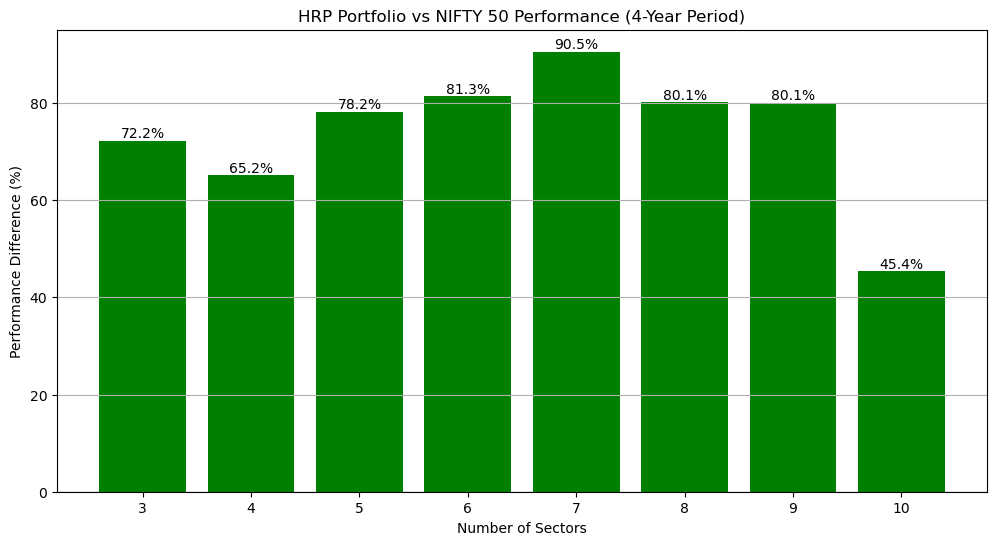


--- Investment Advice as of 2025-04-06 ---
Using training data from 2024-07-27 to 2025-04-05:

--- Top 3 Sectors Recommendation ---
Selected Sectors and Their Top 5 Stocks with Recommended Weights:


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^NSEBANK
  Top Stocks: ['KOTAKBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'FEDERALBNK.NS', 'BANKBARODA.NS']
  Recommended HRP Weights:
    KOTAKBANK.NS: 9.35%
    HDFCBANK.NS: 8.41%
    ICICIBANK.NS: 44.86%
    FEDERALBNK.NS: 28.04%
    BANKBARODA.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXSERVICE
  Top Stocks: ['MUTHOOTFIN.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'BAJAJFINSV.NS', 'HDFCBANK.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    BAJFINANCE.NS: 28.04%
    KOTAKBANK.NS: 8.41%
    BAJAJFINSV.NS: 9.35%
    HDFCBANK.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:5


Sector: ^CNXIT
  Top Stocks: ['COFORGE.NS', 'PERSISTENT.NS', 'WIPRO.NS', 'TECHM.NS', 'HCLTECH.NS']
  Recommended HRP Weights:
    COFORGE.NS: 28.04%
    PERSISTENT.NS: 9.35%
    WIPRO.NS: 9.35%
    TECHM.NS: 8.41%
    HCLTECH.NS: 44.86%
------------------------------------------------------------
--- Top 4 Sectors Recommendation ---
Selected Sectors and Their Top 5 Stocks with Recommended Weights:

Sector: ^NSEBANK
  Top Stocks: ['KOTAKBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'FEDERALBNK.NS', 'BANKBARODA.NS']
  Recommended HRP Weights:
    KOTAKBANK.NS: 9.35%
    HDFCBANK.NS: 8.41%
    ICICIBANK.NS: 44.86%
    FEDERALBNK.NS: 28.04%
    BANKBARODA.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:5


Sector: ^CNXSERVICE
  Top Stocks: ['MUTHOOTFIN.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'BAJAJFINSV.NS', 'HDFCBANK.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    BAJFINANCE.NS: 28.04%
    KOTAKBANK.NS: 8.41%
    BAJAJFINSV.NS: 9.35%
    HDFCBANK.NS: 44.86%

Sector: ^CNXIT
  Top Stocks: ['COFORGE.NS', 'PERSISTENT.NS', 'WIPRO.NS', 'TECHM.NS', 'HCLTECH.NS']
  Recommended HRP Weights:
    COFORGE.NS: 28.04%
    PERSISTENT.NS: 9.35%
    WIPRO.NS: 9.35%
    TECHM.NS: 8.41%
    HCLTECH.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:5


Sector: ^CNXMETAL
  Top Stocks: ['WELCORP.NS', 'JSWSTEEL.NS', 'APLAPOLLO.NS', 'VEDL.NS', 'NATIONALUM.NS']
  Recommended HRP Weights:
    WELCORP.NS: 8.41%
    JSWSTEEL.NS: 28.04%
    APLAPOLLO.NS: 44.86%
    VEDL.NS: 9.35%
    NATIONALUM.NS: 9.35%
------------------------------------------------------------
--- Top 5 Sectors Recommendation ---
Selected Sectors and Their Top 5 Stocks with Recommended Weights:

Sector: ^NSEBANK
  Top Stocks: ['KOTAKBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'FEDERALBNK.NS', 'BANKBARODA.NS']
  Recommended HRP Weights:
    KOTAKBANK.NS: 9.35%
    HDFCBANK.NS: 8.41%
    ICICIBANK.NS: 44.86%
    FEDERALBNK.NS: 28.04%
    BANKBARODA.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:5


Sector: ^CNXSERVICE
  Top Stocks: ['MUTHOOTFIN.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'BAJAJFINSV.NS', 'HDFCBANK.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    BAJFINANCE.NS: 28.04%
    KOTAKBANK.NS: 8.41%
    BAJAJFINSV.NS: 9.35%
    HDFCBANK.NS: 44.86%

Sector: ^CNXIT
  Top Stocks: ['COFORGE.NS', 'PERSISTENT.NS', 'WIPRO.NS', 'TECHM.NS', 'HCLTECH.NS']
  Recommended HRP Weights:
    COFORGE.NS: 28.04%
    PERSISTENT.NS: 9.35%
    WIPRO.NS: 9.35%
    TECHM.NS: 8.41%
    HCLTECH.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXMETAL
  Top Stocks: ['WELCORP.NS', 'JSWSTEEL.NS', 'APLAPOLLO.NS', 'VEDL.NS', 'NATIONALUM.NS']
  Recommended HRP Weights:
    WELCORP.NS: 8.41%
    JSWSTEEL.NS: 28.04%
    APLAPOLLO.NS: 44.86%
    VEDL.NS: 9.35%
    NATIONALUM.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXCONSUM
  Top Stocks: ['BHARTIARTL.NS', 'INDHOTEL.NS', 'EICHERMOT.NS', 'TRENT.NS', 'APOLLOHOSP.NS']
  Recommended HRP Weights:
    BHARTIARTL.NS: 28.04%
    INDHOTEL.NS: 9.35%
    EICHERMOT.NS: 8.41%
    TRENT.NS: 44.86%
    APOLLOHOSP.NS: 9.35%
------------------------------------------------------------
--- Top 6 Sectors Recommendation ---
Selected Sectors and Their Top 5 Stocks with Recommended Weights:


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^NSEBANK
  Top Stocks: ['KOTAKBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'FEDERALBNK.NS', 'BANKBARODA.NS']
  Recommended HRP Weights:
    KOTAKBANK.NS: 9.35%
    HDFCBANK.NS: 8.41%
    ICICIBANK.NS: 44.86%
    FEDERALBNK.NS: 28.04%
    BANKBARODA.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXSERVICE
  Top Stocks: ['MUTHOOTFIN.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'BAJAJFINSV.NS', 'HDFCBANK.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    BAJFINANCE.NS: 28.04%
    KOTAKBANK.NS: 8.41%
    BAJAJFINSV.NS: 9.35%
    HDFCBANK.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXIT
  Top Stocks: ['COFORGE.NS', 'PERSISTENT.NS', 'WIPRO.NS', 'TECHM.NS', 'HCLTECH.NS']
  Recommended HRP Weights:
    COFORGE.NS: 28.04%
    PERSISTENT.NS: 9.35%
    WIPRO.NS: 9.35%
    TECHM.NS: 8.41%
    HCLTECH.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXMETAL
  Top Stocks: ['WELCORP.NS', 'JSWSTEEL.NS', 'APLAPOLLO.NS', 'VEDL.NS', 'NATIONALUM.NS']
  Recommended HRP Weights:
    WELCORP.NS: 8.41%
    JSWSTEEL.NS: 28.04%
    APLAPOLLO.NS: 44.86%
    VEDL.NS: 9.35%
    NATIONALUM.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXCONSUM
  Top Stocks: ['BHARTIARTL.NS', 'INDHOTEL.NS', 'EICHERMOT.NS', 'TRENT.NS', 'APOLLOHOSP.NS']
  Recommended HRP Weights:
    BHARTIARTL.NS: 28.04%
    INDHOTEL.NS: 9.35%
    EICHERMOT.NS: 8.41%
    TRENT.NS: 44.86%
    APOLLOHOSP.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXPSUBANK
  Top Stocks: ['INDIANB.NS', 'UNIONBANK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'SBIN.NS']
  Recommended HRP Weights:
    INDIANB.NS: 9.35%
    UNIONBANK.NS: 8.41%
    BANKBARODA.NS: 28.04%
    BANKINDIA.NS: 44.86%
    SBIN.NS: 9.35%
------------------------------------------------------------
--- Top 7 Sectors Recommendation ---
Selected Sectors and Their Top 5 Stocks with Recommended Weights:


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^NSEBANK
  Top Stocks: ['KOTAKBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'FEDERALBNK.NS', 'BANKBARODA.NS']
  Recommended HRP Weights:
    KOTAKBANK.NS: 9.35%
    HDFCBANK.NS: 8.41%
    ICICIBANK.NS: 44.86%
    FEDERALBNK.NS: 28.04%
    BANKBARODA.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXSERVICE
  Top Stocks: ['MUTHOOTFIN.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'BAJAJFINSV.NS', 'HDFCBANK.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    BAJFINANCE.NS: 28.04%
    KOTAKBANK.NS: 8.41%
    BAJAJFINSV.NS: 9.35%
    HDFCBANK.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXIT
  Top Stocks: ['COFORGE.NS', 'PERSISTENT.NS', 'WIPRO.NS', 'TECHM.NS', 'HCLTECH.NS']
  Recommended HRP Weights:
    COFORGE.NS: 28.04%
    PERSISTENT.NS: 9.35%
    WIPRO.NS: 9.35%
    TECHM.NS: 8.41%
    HCLTECH.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXMETAL
  Top Stocks: ['WELCORP.NS', 'JSWSTEEL.NS', 'APLAPOLLO.NS', 'VEDL.NS', 'NATIONALUM.NS']
  Recommended HRP Weights:
    WELCORP.NS: 8.41%
    JSWSTEEL.NS: 28.04%
    APLAPOLLO.NS: 44.86%
    VEDL.NS: 9.35%
    NATIONALUM.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXCONSUM
  Top Stocks: ['BHARTIARTL.NS', 'INDHOTEL.NS', 'EICHERMOT.NS', 'TRENT.NS', 'APOLLOHOSP.NS']
  Recommended HRP Weights:
    BHARTIARTL.NS: 28.04%
    INDHOTEL.NS: 9.35%
    EICHERMOT.NS: 8.41%
    TRENT.NS: 44.86%
    APOLLOHOSP.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXPSUBANK
  Top Stocks: ['INDIANB.NS', 'UNIONBANK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'SBIN.NS']
  Recommended HRP Weights:
    INDIANB.NS: 9.35%
    UNIONBANK.NS: 8.41%
    BANKBARODA.NS: 28.04%
    BANKINDIA.NS: 44.86%
    SBIN.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: NIFTY_MIDCAP_100.NS
  Top Stocks: ['MUTHOOTFIN.NS', 'UPL.NS', 'JUBLFOOD.NS', 'SRF.NS', 'PATANJALI.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    UPL.NS: 28.04%
    JUBLFOOD.NS: 8.41%
    SRF.NS: 9.35%
    PATANJALI.NS: 44.86%
------------------------------------------------------------
--- Top 8 Sectors Recommendation ---
Selected Sectors and Their Top 5 Stocks with Recommended Weights:


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^NSEBANK
  Top Stocks: ['KOTAKBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'FEDERALBNK.NS', 'BANKBARODA.NS']
  Recommended HRP Weights:
    KOTAKBANK.NS: 9.35%
    HDFCBANK.NS: 8.41%
    ICICIBANK.NS: 44.86%
    FEDERALBNK.NS: 28.04%
    BANKBARODA.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXSERVICE
  Top Stocks: ['MUTHOOTFIN.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'BAJAJFINSV.NS', 'HDFCBANK.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    BAJFINANCE.NS: 28.04%
    KOTAKBANK.NS: 8.41%
    BAJAJFINSV.NS: 9.35%
    HDFCBANK.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXIT
  Top Stocks: ['COFORGE.NS', 'PERSISTENT.NS', 'WIPRO.NS', 'TECHM.NS', 'HCLTECH.NS']
  Recommended HRP Weights:
    COFORGE.NS: 28.04%
    PERSISTENT.NS: 9.35%
    WIPRO.NS: 9.35%
    TECHM.NS: 8.41%
    HCLTECH.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXMETAL
  Top Stocks: ['WELCORP.NS', 'JSWSTEEL.NS', 'APLAPOLLO.NS', 'VEDL.NS', 'NATIONALUM.NS']
  Recommended HRP Weights:
    WELCORP.NS: 8.41%
    JSWSTEEL.NS: 28.04%
    APLAPOLLO.NS: 44.86%
    VEDL.NS: 9.35%
    NATIONALUM.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXCONSUM
  Top Stocks: ['BHARTIARTL.NS', 'INDHOTEL.NS', 'EICHERMOT.NS', 'TRENT.NS', 'APOLLOHOSP.NS']
  Recommended HRP Weights:
    BHARTIARTL.NS: 28.04%
    INDHOTEL.NS: 9.35%
    EICHERMOT.NS: 8.41%
    TRENT.NS: 44.86%
    APOLLOHOSP.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXPSUBANK
  Top Stocks: ['INDIANB.NS', 'UNIONBANK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'SBIN.NS']
  Recommended HRP Weights:
    INDIANB.NS: 9.35%
    UNIONBANK.NS: 8.41%
    BANKBARODA.NS: 28.04%
    BANKINDIA.NS: 44.86%
    SBIN.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: NIFTY_MIDCAP_100.NS
  Top Stocks: ['MUTHOOTFIN.NS', 'UPL.NS', 'JUBLFOOD.NS', 'SRF.NS', 'PATANJALI.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    UPL.NS: 28.04%
    JUBLFOOD.NS: 8.41%
    SRF.NS: 9.35%
    PATANJALI.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXINFRA
  Top Stocks: ['BHARTIARTL.NS', 'INDHOTEL.NS', 'SHREECEM.NS', 'APOLLOHOSP.NS', 'HINDPETRO.NS']
  Recommended HRP Weights:
    BHARTIARTL.NS: 28.04%
    INDHOTEL.NS: 8.41%
    SHREECEM.NS: 9.35%
    APOLLOHOSP.NS: 44.86%
    HINDPETRO.NS: 9.35%
------------------------------------------------------------
--- Top 9 Sectors Recommendation ---
Selected Sectors and Their Top 5 Stocks with Recommended Weights:


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^NSEBANK
  Top Stocks: ['KOTAKBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'FEDERALBNK.NS', 'BANKBARODA.NS']
  Recommended HRP Weights:
    KOTAKBANK.NS: 9.35%
    HDFCBANK.NS: 8.41%
    ICICIBANK.NS: 44.86%
    FEDERALBNK.NS: 28.04%
    BANKBARODA.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXSERVICE
  Top Stocks: ['MUTHOOTFIN.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'BAJAJFINSV.NS', 'HDFCBANK.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    BAJFINANCE.NS: 28.04%
    KOTAKBANK.NS: 8.41%
    BAJAJFINSV.NS: 9.35%
    HDFCBANK.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXIT
  Top Stocks: ['COFORGE.NS', 'PERSISTENT.NS', 'WIPRO.NS', 'TECHM.NS', 'HCLTECH.NS']
  Recommended HRP Weights:
    COFORGE.NS: 28.04%
    PERSISTENT.NS: 9.35%
    WIPRO.NS: 9.35%
    TECHM.NS: 8.41%
    HCLTECH.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXMETAL
  Top Stocks: ['WELCORP.NS', 'JSWSTEEL.NS', 'APLAPOLLO.NS', 'VEDL.NS', 'NATIONALUM.NS']
  Recommended HRP Weights:
    WELCORP.NS: 8.41%
    JSWSTEEL.NS: 28.04%
    APLAPOLLO.NS: 44.86%
    VEDL.NS: 9.35%
    NATIONALUM.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXCONSUM
  Top Stocks: ['BHARTIARTL.NS', 'INDHOTEL.NS', 'EICHERMOT.NS', 'TRENT.NS', 'APOLLOHOSP.NS']
  Recommended HRP Weights:
    BHARTIARTL.NS: 28.04%
    INDHOTEL.NS: 9.35%
    EICHERMOT.NS: 8.41%
    TRENT.NS: 44.86%
    APOLLOHOSP.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXPSUBANK
  Top Stocks: ['INDIANB.NS', 'UNIONBANK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'SBIN.NS']
  Recommended HRP Weights:
    INDIANB.NS: 9.35%
    UNIONBANK.NS: 8.41%
    BANKBARODA.NS: 28.04%
    BANKINDIA.NS: 44.86%
    SBIN.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: NIFTY_MIDCAP_100.NS
  Top Stocks: ['MUTHOOTFIN.NS', 'UPL.NS', 'JUBLFOOD.NS', 'SRF.NS', 'PATANJALI.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    UPL.NS: 28.04%
    JUBLFOOD.NS: 8.41%
    SRF.NS: 9.35%
    PATANJALI.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXINFRA
  Top Stocks: ['BHARTIARTL.NS', 'INDHOTEL.NS', 'SHREECEM.NS', 'APOLLOHOSP.NS', 'HINDPETRO.NS']
  Recommended HRP Weights:
    BHARTIARTL.NS: 28.04%
    INDHOTEL.NS: 8.41%
    SHREECEM.NS: 9.35%
    APOLLOHOSP.NS: 44.86%
    HINDPETRO.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXPSE
  Top Stocks: ['HINDPETRO.NS', 'NTPC.NS', 'BEL.NS', 'NMDC.NS', 'POWERGRID.NS']
  Recommended HRP Weights:
    HINDPETRO.NS: 28.04%
    NTPC.NS: 8.41%
    BEL.NS: 9.35%
    NMDC.NS: 9.35%
    POWERGRID.NS: 44.86%
------------------------------------------------------------
--- Top 10 Sectors Recommendation ---
Selected Sectors and Their Top 5 Stocks with Recommended Weights:


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^NSEBANK
  Top Stocks: ['KOTAKBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'FEDERALBNK.NS', 'BANKBARODA.NS']
  Recommended HRP Weights:
    KOTAKBANK.NS: 9.35%
    HDFCBANK.NS: 8.41%
    ICICIBANK.NS: 44.86%
    FEDERALBNK.NS: 28.04%
    BANKBARODA.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXSERVICE
  Top Stocks: ['MUTHOOTFIN.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'BAJAJFINSV.NS', 'HDFCBANK.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    BAJFINANCE.NS: 28.04%
    KOTAKBANK.NS: 8.41%
    BAJAJFINSV.NS: 9.35%
    HDFCBANK.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXIT
  Top Stocks: ['COFORGE.NS', 'PERSISTENT.NS', 'WIPRO.NS', 'TECHM.NS', 'HCLTECH.NS']
  Recommended HRP Weights:
    COFORGE.NS: 28.04%
    PERSISTENT.NS: 9.35%
    WIPRO.NS: 9.35%
    TECHM.NS: 8.41%
    HCLTECH.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXMETAL
  Top Stocks: ['WELCORP.NS', 'JSWSTEEL.NS', 'APLAPOLLO.NS', 'VEDL.NS', 'NATIONALUM.NS']
  Recommended HRP Weights:
    WELCORP.NS: 8.41%
    JSWSTEEL.NS: 28.04%
    APLAPOLLO.NS: 44.86%
    VEDL.NS: 9.35%
    NATIONALUM.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXCONSUM
  Top Stocks: ['BHARTIARTL.NS', 'INDHOTEL.NS', 'EICHERMOT.NS', 'TRENT.NS', 'APOLLOHOSP.NS']
  Recommended HRP Weights:
    BHARTIARTL.NS: 28.04%
    INDHOTEL.NS: 9.35%
    EICHERMOT.NS: 8.41%
    TRENT.NS: 44.86%
    APOLLOHOSP.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXPSUBANK
  Top Stocks: ['INDIANB.NS', 'UNIONBANK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'SBIN.NS']
  Recommended HRP Weights:
    INDIANB.NS: 9.35%
    UNIONBANK.NS: 8.41%
    BANKBARODA.NS: 28.04%
    BANKINDIA.NS: 44.86%
    SBIN.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: NIFTY_MIDCAP_100.NS
  Top Stocks: ['MUTHOOTFIN.NS', 'UPL.NS', 'JUBLFOOD.NS', 'SRF.NS', 'PATANJALI.NS']
  Recommended HRP Weights:
    MUTHOOTFIN.NS: 9.35%
    UPL.NS: 28.04%
    JUBLFOOD.NS: 8.41%
    SRF.NS: 9.35%
    PATANJALI.NS: 44.86%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXINFRA
  Top Stocks: ['BHARTIARTL.NS', 'INDHOTEL.NS', 'SHREECEM.NS', 'APOLLOHOSP.NS', 'HINDPETRO.NS']
  Recommended HRP Weights:
    BHARTIARTL.NS: 28.04%
    INDHOTEL.NS: 8.41%
    SHREECEM.NS: 9.35%
    APOLLOHOSP.NS: 44.86%
    HINDPETRO.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")



Sector: ^CNXPSE
  Top Stocks: ['HINDPETRO.NS', 'NTPC.NS', 'BEL.NS', 'NMDC.NS', 'POWERGRID.NS']
  Recommended HRP Weights:
    HINDPETRO.NS: 28.04%
    NTPC.NS: 8.41%
    BEL.NS: 9.35%
    NMDC.NS: 9.35%
    POWERGRID.NS: 44.86%

Sector: ^CNXREALTY
  Top Stocks: ['ANANTRAJ.NS', 'PHOENIXLTD.NS', 'OBEROIRLTY.NS', 'RAYMOND.NS', 'BRIGADE.NS']
  Recommended HRP Weights:
    ANANTRAJ.NS: 8.41%
    PHOENIXLTD.NS: 28.04%
    OBEROIRLTY.NS: 44.86%
    RAYMOND.NS: 9.35%
    BRIGADE.NS: 9.35%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\124261850.py:504: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")


In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
import requests
import time

# =============================================================================
# 0. User Input: Number of Years for Simulation (between 1 and 15)
# =============================================================================
while True:
    try:
        num_years = int(input("Enter the number of years for simulation (1-15): "))
        if 1 <= num_years <= 15:
            break
        else:
            print("Please enter a number between 1 and 15.")
    except ValueError:
        print("Invalid input. Please enter an integer between 1 and 15.")

# =============================================================================
# 1. Sector Data Download and Preprocessing (using sector indices)
# =============================================================================
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE",
    "^CNXCONSUM", "NIFTY_MIDCAP_100.NS"
]

end_date = datetime.today()
start_date = end_date - timedelta(days=365 * num_years)

data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    if not df.empty and 'Close' in df.columns:
        data_dict[ticker] = df['Close']
    else:
        print(f"Data for {ticker} is missing or incomplete.")

if not data_dict:
    raise ValueError("No sector data downloaded. Check ticker symbols or network connection.")

prices = pd.concat(data_dict, axis=1).dropna()
# If columns are multi-index, reset to plain tickers.
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = prices.columns.get_level_values(0)
returns = prices.pct_change().dropna()

# =============================================================================
# 2. Download Benchmark Data for Trend/Stoploss Analysis (NIFTY 50)
# =============================================================================
benchmark_ticker = "^NSEI"
benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
if benchmark_data.empty:
    raise ValueError("No benchmark data downloaded for trend analysis.")
benchmark_series = benchmark_data['Close'].squeeze()

# =============================================================================
# 3. Correlation Analysis & Clustering for Diversification (Sector Level)
# =============================================================================
correlation_matrix = returns.corr()
print(f"\nCorrelation Matrix of Sector Returns (Last {num_years} Years):")
print(correlation_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Sector Returns")
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
sector_features = correlation_matrix.values
sector_labels = kmeans.fit_predict(sector_features)
sector_cluster_map = dict(zip(correlation_matrix.columns, sector_labels))
print("\nSector Cluster Mapping (for Diversification):")
for sector, cluster in sector_cluster_map.items():
    print(f"  {sector}: Cluster {cluster}")

# =============================================================================
# 4. Validated Stocks Extraction: Read Valid Stock Components from CSV File
# =============================================================================
# Expect file 'validated_stocks.csv' with columns "Sector" and "Symbol"
try:
    df_valid = pd.read_csv('validated_stocks2.csv')
    all_symbols = {}
    for sector, group in df_valid.groupby('Sector'):
        symbols = group['Symbol'].tolist()
        # Ensure each symbol ends with ".NS"
        symbols = [s if s.endswith('.NS') else s + '.NS' for s in symbols]
        all_symbols[sector] = symbols
        print(f"Valid symbols for {sector}: {symbols}")
        print("----------")
except Exception as e:
    print("Error reading validated stocks file:", e)
    all_symbols = {}

# =============================================================================
# 4a. Read Listing Dates for Stocks from Invalidated Stocks File
# =============================================================================
# Expect file 'invalidated_stocks.csv' with columns "Sector", "Symbol", and "ListingDate"
# Build dictionary mapping each symbol (with .NS appended if needed) to its listing date.
listing_dates = {}
try:
    df_invalid = pd.read_csv('invalidated_stocks.csv')
    df_invalid['ListingDate'] = pd.to_datetime(df_invalid['ListingDate'])
    for idx, row in df_invalid.iterrows():
        symbol = row['Symbol']
        if not symbol.endswith('.NS'):
            symbol += '.NS'
        listing_dates[symbol] = row['ListingDate']
    print("\nListing dates loaded for stocks from invalidated_stocks.csv.")
except Exception as e:
    print("Error reading invalidated stocks file:", e)
    listing_dates = {}

# =============================================================================
# 5. HRP Weight Calculation Function (with Numerical Stability Fixes)
# =============================================================================
def get_hrp_weights(returns_df):
    """
    Calculate Hierarchical Risk Parity (HRP) weights.
    """
    if returns_df.shape[1] < 2:
        return pd.Series(1.0, index=returns_df.columns)
    
    corr = returns_df.corr().fillna(0)
    corr = 0.5 * (corr + corr.T)
    np.fill_diagonal(corr.values, 1.0)
    dist = np.sqrt(np.clip(0.5 * (1 - corr), 0.0, 1.0))
    dist = 0.5 * (dist + dist.T)
    dist = np.nan_to_num(dist, nan=0.0, posinf=0.0, neginf=0.0)
    
    condensed_dist = ssd.squareform(dist, checks=False)
    link = sch.linkage(condensed_dist, method='ward')
    sorted_indices = sch.leaves_list(link)
    ordered_tickers = returns_df.columns[sorted_indices]
    
    weights = pd.Series(1, index=ordered_tickers)
    cluster_sizes = pd.Series(1, index=ordered_tickers)
    
    for i in range(len(ordered_tickers) - 1):
        left, right = ordered_tickers[i], ordered_tickers[i+1]
        total_size = cluster_sizes[left] + cluster_sizes[right]
        weights[left] *= cluster_sizes[right] / total_size
        weights[right] *= cluster_sizes[left] / total_size
        cluster_sizes[left] = total_size
        cluster_sizes[right] = total_size
    
    return weights / weights.sum()

# =============================================================================
# 6. Diversified Sector Selection Function
# =============================================================================
def select_diversified_sectors(sharpe_scores, n, cluster_map):
    """
    Select top-n sectors based on Sharpe ratio while ensuring diversification.
    """
    sorted_sectors = sharpe_scores.sort_values(ascending=False).index.tolist()
    unique_selected = []
    used_clusters = set()
    for s in sorted_sectors:
        if cluster_map[s] not in used_clusters:
            unique_selected.append(s)
            used_clusters.add(cluster_map[s])
    selected = unique_selected.copy()
    for s in sorted_sectors:
        if len(selected) >= n:
            break
        if s not in selected:
            selected.append(s)
    return selected[:n]

# =============================================================================
# 7. Function to Select Top Stocks within a Sector
# =============================================================================
def get_top_stocks(sector, train_start, train_end, top_n=5):
    """
    For a given sector, download historical data for its valid component stocks (from all_symbols)
    over the training period. If a stock was listed after train_start, adjust the start date accordingly.
    Compute Sharpe ratios and return the top 'top_n' stocks along with their HRP weights.
    """
    symbols = all_symbols.get(sector, [])
    if not symbols:
        print(f"No valid symbols available for sector {sector}.")
        return [], pd.Series(dtype=float)
    
    stock_data = {}
    for symbol in symbols:
        # Adjust training start date based on listing date if available.
        adj_train_start = train_start
        if symbol in listing_dates:
            list_date = listing_dates[symbol]
            if list_date > pd.to_datetime(train_start):
                adj_train_start = list_date.strftime("%Y-%m-%d")
        try:
            df = yf.download(symbol, start=adj_train_start, end=train_end, progress=False, auto_adjust=True)
            if not df.empty and 'Close' in df.columns:
                stock_data[symbol] = df['Close']
        except Exception as e:
            print(f"Error downloading data for {symbol}: {e}")
            continue

    if not stock_data:
        print(f"No training data available for stocks in sector {sector}.")
        return [], pd.Series(dtype=float)
    
    prices_stock = pd.concat(stock_data, axis=1).dropna(how='all', axis=0)
    if prices_stock.empty:
        print(f"No overlapping training data for stocks in sector {sector}.")
        return [], pd.Series(dtype=float)
    
    returns_stock = prices_stock.pct_change().dropna()
    if returns_stock.empty:
        print(f"Insufficient returns data for stocks in sector {sector}.")
        return [], pd.Series(dtype=float)
    
    sharpe = returns_stock.mean() / returns_stock.std()
    sharpe = sharpe.dropna()
    if sharpe.empty:
        print(f"Sharpe ratio calculation failed for sector {sector}.")
        return [], pd.Series(dtype=float)
    
    top_stocks = sharpe.sort_values(ascending=False).head(top_n).index.tolist()
    selected_returns = returns_stock[top_stocks]
    hrp_weights_stocks = get_hrp_weights(selected_returns)
    return top_stocks, hrp_weights_stocks

# =============================================================================
# 8. Quarterly Rebalancing Simulation with Enhanced Risk Management & Transaction Costs
# =============================================================================
print("\n--- Quarterly Rebalancing Simulation with Enhanced Risk Management ---\n")
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
stoploss_pct = 0.05  # 5% stoploss threshold
transaction_cost_rate = 0.00075  # 0.15% per trade (0.075% per buy and sell)

results_summary = []
all_quarterly_results = {}

def get_previous_quarter_risk_factor(i, benchmark_series, quarter_end_dates):
    if i == 0:
        return 1.0
    prev_q_start = prices.index[0] if i-1 == 0 else quarter_end_dates[i-2] + pd.Timedelta(days=1)
    prev_q_end = quarter_end_dates[i-1]
    benchmark_prev = benchmark_series[(benchmark_series.index >= prev_q_start) & (benchmark_series.index <= prev_q_end)]
    if benchmark_prev.empty:
        return 1.0
    prev_return = (benchmark_prev.iloc[-1] / benchmark_prev.iloc[0]) - 1
    return np.clip(1 + prev_return, 0.5, 1.0)

# For each simulation run (number of sectors n), also compute annualized alpha and beta.
for n in range(3, 11):
    cumulative_value = initial_capital
    quarterly_results = []  # to store each quarter's results (including returns and quarter_end)
    
    print(f"\n===== Simulating for Top {n} Sectors =====\n")
    
    for i, q_end in enumerate(quarter_end_dates):
        q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
        if q_start >= prices.index[-1]:
            break
        
        training_end = q_start - pd.Timedelta(days=1)
        training_prices = prices[prices.index <= training_end]
        if training_prices.empty:
            continue
        training_returns = training_prices.pct_change().dropna()
        if training_returns.empty:
            continue
        
        sharpe_scores = training_returns.mean() / training_returns.std()
        selected_sectors = select_diversified_sectors(sharpe_scores, n, sector_cluster_map)
        if len(selected_sectors) == 0:
            continue
        
        selected_training_returns = training_returns[selected_sectors]
        sector_hrp_weights = get_hrp_weights(selected_training_returns)
        
        # For each selected sector, determine top 5 stocks and get their HRP weights.
        sector_stock_info = {}
        sector_stock_returns = {}
        sector_weighted_returns = {}
        
        for sector in selected_sectors:
            train_start_str = training_prices.index[0].strftime("%Y-%m-%d")
            train_end_str = training_end.strftime("%Y-%m-%d")
            top_stocks, stock_hrp_weights = get_top_stocks(sector, train_start_str, q_start.strftime("%Y-%m-%d"), top_n=5)
            if not top_stocks:
                continue
            # Ensure tickers are strings.
            top_stocks = [s if isinstance(s, str) else s[0] for s in top_stocks]
            stock_prices = yf.download(top_stocks,
                                       start=q_start.strftime("%Y-%m-%d"),
                                       end=q_end.strftime("%Y-%m-%d"),
                                       progress=False, auto_adjust=True)
            if 'Close' in stock_prices.columns:
                stock_prices = stock_prices['Close']
            stock_prices = stock_prices.dropna(how='all', axis=0)
            if stock_prices.empty or len(stock_prices) < 2:
                continue
            start_prices = stock_prices.iloc[0]
            end_prices = stock_prices.iloc[-1]
            stock_ret = (end_prices / start_prices) - 1
            weighted_return = np.dot(stock_hrp_weights[top_stocks], stock_ret[top_stocks])
            
            sector_stock_info[sector] = {
                'top_stocks': top_stocks,
                'stock_hrp_weights': stock_hrp_weights[top_stocks].to_dict()
            }
            sector_stock_returns[sector] = stock_ret.to_dict()
            sector_weighted_returns[sector] = weighted_return
        
        if not sector_weighted_returns:
            continue
        
        overall_return = 0
        for sector in selected_sectors:
            if sector in sector_weighted_returns:
                overall_return += sector_hrp_weights[sector] * sector_weighted_returns[sector]
        
        # Compute benchmark return for the quarter.
        benchmark_q = benchmark_series[(benchmark_series.index >= q_start) & (benchmark_series.index <= q_end)]
        if benchmark_q.empty:
            bench_return = np.nan
        else:
            bench_return = (benchmark_q.iloc[-1] / benchmark_q.iloc[0]) - 1
        
        # Modified Stoploss: if daily cumulative drop is below threshold.
        period_prices = prices.loc[(prices.index >= q_start) & (prices.index <= q_end), selected_sectors]
        if period_prices.empty or len(period_prices) < 2:
            continue
        daily_returns = period_prices.pct_change().dropna()
        daily_portfolio_returns = daily_returns.apply(lambda row: np.dot([sector_hrp_weights[s] for s in selected_sectors], row[selected_sectors]), axis=1)
        cum_daily = (1 + daily_portfolio_returns).cumprod()
        if cum_daily.min() < (1 - stoploss_pct):
            stoploss_triggered = True
            stoploss_return = overall_return if overall_return > -stoploss_pct else -stoploss_pct
        else:
            stoploss_triggered = False
            stoploss_return = overall_return
        
        risk_factor = get_previous_quarter_risk_factor(i, benchmark_series, quarter_end_dates)
        effective_return = risk_factor * stoploss_return
        
        net_value_entry = cumulative_value * (1 - transaction_cost_rate)
        new_value = net_value_entry * (1 + effective_return)
        net_value_exit = new_value * (1 - transaction_cost_rate)
        cumulative_value = net_value_exit
        
        # Save quarterly data with quarter_end date.
        quarterly_results.append({
            'quarter_end': q_end,  # we'll use this to group by year
            'effective_return': effective_return,
            'benchmark_return': bench_return
        })
        
        print(f"Quarter {q_start.date()} to {q_end.date()}:")
        print(f"  Selected Sectors: {selected_sectors}")
        print("  Sector HRP Weights:")
        for sector in selected_sectors:
            print(f"    {sector}: {sector_hrp_weights[sector]:.2%}")
            if sector in sector_stock_info:
                info = sector_stock_info[sector]
                print("      Top Stocks & Weights:")
                for stock, wt in info['stock_hrp_weights'].items():
                    print(f"        {stock}: {float(wt):.2%}")
        print(f"  Raw Portfolio Return: {overall_return:.2%}")
        if stoploss_triggered:
            print(f"  STOPLOSS Triggered: Capped Return = {stoploss_return:.2%}")
        print(f"  Benchmark Return: {bench_return:.2%}")
        print(f"  Risk Factor: {risk_factor:.2f}")
        print(f"  Effective Portfolio Return: {effective_return:.2%}")
        print(f"  Cumulative Value after Transaction Costs: ₹{cumulative_value:,.2f}")
        print("-" * 80)
    
    # --- Annual Alpha/Beta Calculation ---
    # Group quarterly results by year and compound returns to get annual returns.
    annual_port_returns = {}
    annual_bench_returns = {}
    for res in quarterly_results:
        year = res['quarter_end'].year
        annual_port_returns.setdefault(year, []).append(1 + res['effective_return'])
        annual_bench_returns.setdefault(year, []).append(1 + res['benchmark_return'] if not np.isnan(res['benchmark_return']) else np.nan)
    
    annual_port = []
    annual_bench = []
    for year in sorted(annual_port_returns.keys()):
        # Only include year if all benchmark returns are numbers.
        if np.isnan(annual_bench_returns[year]).any():
            continue
        annual_r = np.prod(annual_port_returns[year]) - 1
        annual_b = np.prod(annual_bench_returns[year]) - 1
        annual_port.append(annual_r)
        annual_bench.append(annual_b)
    annual_port = np.array(annual_port)
    annual_bench = np.array(annual_bench)
    
    if len(annual_bench) >= 2:
        beta, alpha = np.polyfit(annual_bench, annual_port, 1)
    else:
        beta, alpha = np.nan, np.nan

    results_summary.append({
        'Number of Sectors': n,
        'HRP Portfolio Value': cumulative_value,
        'Annualized Volatility': np.std([res['effective_return'] for res in quarterly_results]) * np.sqrt(4) if len(quarterly_results) > 1 else np.nan,
        'Alpha': alpha,
        'Beta': beta
    })
    all_quarterly_results[n] = quarterly_results

hrp_results_df = pd.DataFrame(results_summary)
print("\n=== Simulation Summary for HRP Portfolios (Top N Sectors) ===")
print(hrp_results_df)

# =============================================================================
# 9. Fixed Benchmark Analysis (NIFTY 50)
# =============================================================================
initial_capital_bench = 100000
benchmark_results = []

filtered_data = benchmark_series[benchmark_series.index >= pd.Timestamp(start_date)]
if len(filtered_data) < 2:
    raise ValueError("Not enough benchmark data for the selected period.")

start_price = float(filtered_data.iloc[0])
end_price = float(filtered_data.iloc[-1])
total_return = (end_price / start_price) - 1
cagr = ((1 + total_return) ** (1/num_years)) - 1
final_value = initial_capital_bench * (1 + total_return)

benchmark_results.append({
    'Time Period': f"{num_years} Years",
    'Total Return (%)': round(total_return * 100, 2),
    'CAGR (%)': round(cagr * 100, 2),
    'Final Portfolio Value': round(final_value, 2)
})

benchmark_results_df = pd.DataFrame(benchmark_results)
print(f"\n=== NIFTY 50 Benchmark Performance ({num_years} Years) ===")
print(benchmark_results_df.to_string(index=False))

nifty_final = final_value
comparison_df = hrp_results_df.copy()
comparison_df['NIFTY Value'] = nifty_final
comparison_df['Outperformance (%)'] = (
    (comparison_df['HRP Portfolio Value'] - nifty_final) / nifty_final * 100
).round(2)

print(f"\n=== Final Performance Comparison ({num_years}-Year Period) ===")
print(comparison_df[['Number of Sectors', 'HRP Portfolio Value', 'NIFTY Value', 'Outperformance (%)', 'Alpha', 'Beta']].to_string(index=False))

plt.figure(figsize=(12, 6))
bars = plt.bar(
    comparison_df['Number of Sectors'],
    comparison_df['Outperformance (%)'],
    color=np.where(comparison_df['Outperformance (%)'] > 0, 'g', 'r')
)
plt.title(f"HRP Portfolio vs NIFTY 50 Performance ({num_years}-Year Period)")
plt.xlabel("Number of Sectors")
plt.ylabel("Performance Difference (%)")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom')
plt.show()

# =============================================================================
# 10. Investment Advice Based on Last 1 Year Data (Stock-Level)
# =============================================================================
advice_date = datetime.today()
advice_training_end = advice_date - timedelta(days=1)
advice_training_start = advice_training_end - timedelta(days=252)
if advice_training_start < prices.index[0]:
    advice_training_start = prices.index[0]

advice_training_prices = prices.loc[advice_training_start:advice_training_end].ffill()
advice_training_returns = advice_training_prices.pct_change().dropna()

print(f"\n--- Investment Advice as of {advice_date.date()} ---")
print(f"Using training data from {advice_training_start.date()} to {advice_training_end.date()}:\n")
for n in range(3, 11):
    sharpe_scores = advice_training_returns.mean() / advice_training_returns.std()
    top_n_sectors = select_diversified_sectors(sharpe_scores, n, sector_cluster_map)
    if not top_n_sectors:
        continue
    print(f"--- Top {n} Sectors Recommendation ---")
    print("Selected Sectors and Their Top 5 Stocks with Recommended Weights:")
    for sector in top_n_sectors:
        top_stocks, stock_hrp_weights = get_top_stocks(sector, advice_training_prices.index[0].strftime("%Y-%m-%d"), advice_training_end.strftime("%Y-%m-%d"), top_n=5)
        if top_stocks:
            top_stocks = [s if isinstance(s, str) else s[0] for s in top_stocks]
            print(f"\nSector: {sector}")
            print(f"  Top Stocks: {top_stocks}")
            print("  Recommended HRP Weights:")
            for stock in top_stocks:
                print(f"    {stock}: {float(stock_hrp_weights[stock]):.2%}")
    print("-" * 60)

IN THE CODE BELOW USER HAS AN OPTION TO CHOOSE THE TOP NUMBER OF SECTORS AND THE SIMULATION DATE THEY WANT

Enter the number of years for simulation (1-15):  3
Enter the number of sectors to simulate (3-10):  3



Correlation Matrix of Sector Returns (Last 3 Years):
                       ^CNXIT  ^CNXAUTO  ^NSEBANK  ^CNXFMCG  ^CNXMEDIA  \
^CNXIT               1.000000  0.377598  0.358690  0.316968   0.308869   
^CNXAUTO             0.377598  1.000000  0.559975  0.485275   0.509157   
^NSEBANK             0.358690  0.559975  1.000000  0.371806   0.435181   
^CNXFMCG             0.316968  0.485275  0.371806  1.000000   0.357462   
^CNXMEDIA            0.308869  0.509157  0.435181  0.357462   1.000000   
^CNXMETAL            0.362375  0.569527  0.577334  0.292003   0.562055   
^CNXPSE              0.273345  0.579556  0.565310  0.277552   0.561601   
^CNXMNC              0.455265  0.775364  0.607886  0.687675   0.597357   
^CNXINFRA            0.418337  0.693677  0.695876  0.429996   0.581821   
^CNXREALTY           0.352658  0.599235  0.567427  0.359477   0.567774   
^CNXENERGY           0.287278  0.587320  0.594047  0.319762   0.533754   
^CNXPSUBANK          0.264456  0.522504  0.726395  0.27627

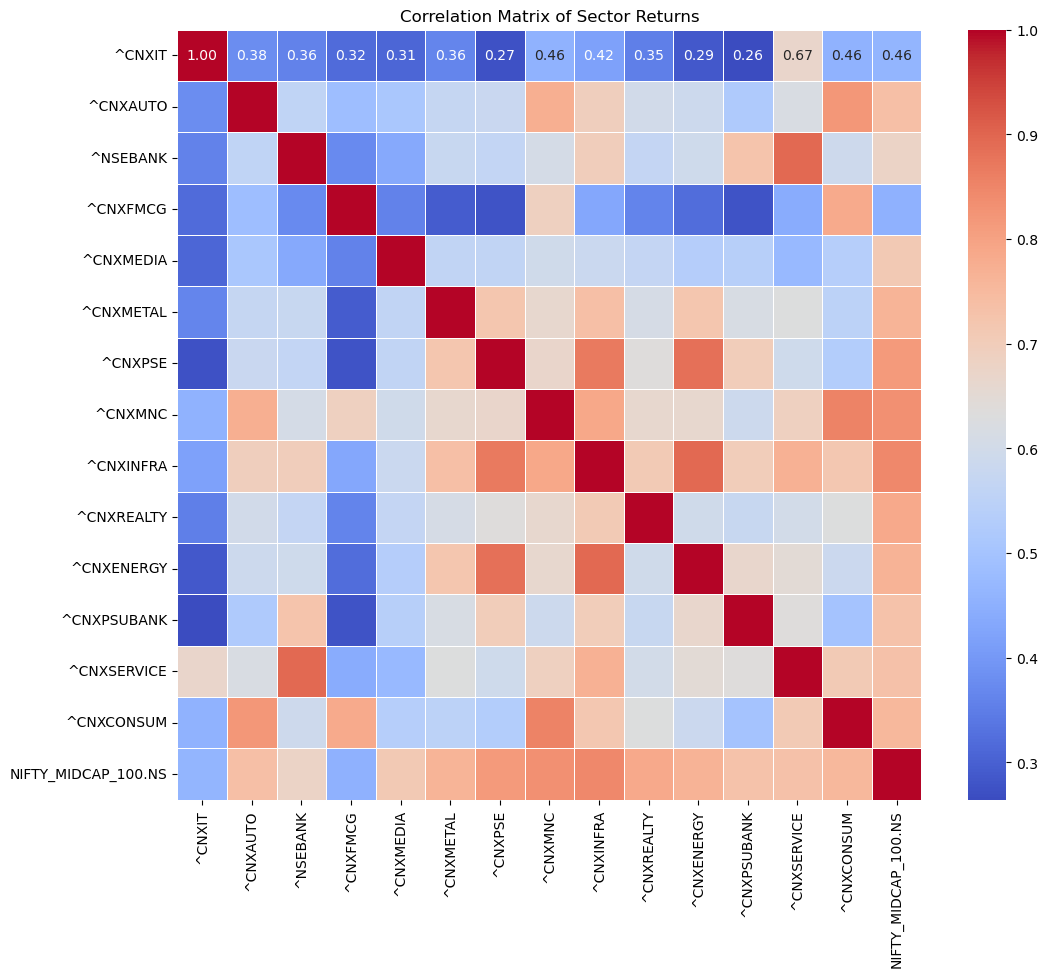

C:\Users\sarda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size



Sector Cluster Mapping (for Diversification):
  ^CNXIT: Cluster 2
  ^CNXAUTO: Cluster 1
  ^NSEBANK: Cluster 0
  ^CNXFMCG: Cluster 1
  ^CNXMEDIA: Cluster 0
  ^CNXMETAL: Cluster 0
  ^CNXPSE: Cluster 0
  ^CNXMNC: Cluster 1
  ^CNXINFRA: Cluster 0
  ^CNXREALTY: Cluster 0
  ^CNXENERGY: Cluster 0
  ^CNXPSUBANK: Cluster 0
  ^CNXSERVICE: Cluster 0
  ^CNXCONSUM: Cluster 1
  NIFTY_MIDCAP_100.NS: Cluster 0
Valid symbols for NIFTY_MIDCAP_100.NS: ['ACC.NS', 'APLAPOLLO.NS', 'ABFRL.NS', 'APOLLOTYRE.NS', 'ASHOKLEY.NS', 'ASTRAL.NS', 'AUROPHARMA.NS', 'BANKINDIA.NS', 'MAHABANK.NS', 'BHARATFORG.NS', 'BHEL.NS', 'BIOCON.NS', 'COFORGE.NS', 'COLPAL.NS', 'CONCOR.NS', 'CUMMINSIND.NS', 'ESCORTS.NS', 'EXIDEIND.NS', 'FEDERALBNK.NS', 'GMRAIRPORT.NS', 'GLENMARK.NS', 'GODREJPROP.NS', 'HINDPETRO.NS', 'HINDZINC.NS', 'IRB.NS', 'INDIANB.NS', 'IGL.NS', 'INDUSTOWER.NS', 'JUBLFOOD.NS', 'LTF.NS', 'LICHSGFIN.NS', 'LUPIN.NS', 'MRF.NS', 'M&MFIN.NS', 'MARICO.NS', 'MFSL.NS', 'MOTILALOFS.NS', 'MPHASIS.NS', 'MUTHOOTFIN.NS', 'NHPC.N

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size


Quarter 2022-07-01 to 2022-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXENERGY', '^CNXIT']
  Sector HRP Weights:
    ^CNXAUTO: 12.50%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('HEROMOTOCO.NS', 'HEROMOTOCO.NS'): 9.35%
        ('ASHOKLEY.NS', 'ASHOKLEY.NS'): 44.86%
        ('MARUTI.NS', 'MARUTI.NS'): 28.04%
    ^CNXENERGY: 37.50%
      Top Stocks & Weights:
        ('PETRONET.NS', 'PETRONET.NS'): 9.35%
        ('ADANIPOWER.NS', 'ADANIPOWER.NS'): 8.41%
        ('THERMAX.NS', 'THERMAX.NS'): 28.04%
        ('ABB.NS', 'ABB.NS'): 44.86%
        ('OIL.NS', 'OIL.NS'): 9.35%
    ^CNXIT: 50.00%
      Top Stocks & Weights:
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('TCS.NS', 'TCS.NS'): 28.04%
        ('OFSS.NS', 'OFSS.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 9.35%
  Raw Portfolio Return: 4.44%
  Risk Factor: 0.89
  Effective Portfolio Return: 3.97%
  Cumulative Val

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2022-10-01 to 2022-12-31:
  Selected Sectors: ['^CNXFMCG', '^NSEBANK', '^CNXIT']
  Sector HRP Weights:
    ^CNXFMCG: 37.50%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('PATANJALI.NS', 'PATANJALI.NS'): 9.35%
        ('HINDUNILVR.NS', 'HINDUNILVR.NS'): 8.41%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 44.86%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
    ^NSEBANK: 12.50%
      Top Stocks & Weights:
        ('FEDERALBNK.NS', 'FEDERALBNK.NS'): 28.04%
        ('ICICIBANK.NS', 'ICICIBANK.NS'): 8.41%
        ('INDUSINDBK.NS', 'INDUSINDBK.NS'): 44.86%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 9.35%
        ('SBIN.NS', 'SBIN.NS'): 9.35%
    ^CNXIT: 50.00%
      Top Stocks & Weights:
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('INFY.NS', 'INFY.NS'): 8.41%
        ('TCS.NS', 'TCS.NS'): 9.35%
        ('HCLTECH.NS', 'HCLTECH.NS'): 44.86%
  Raw Portfolio Return: 8.98%
  Risk Factor: 1.00
  Effective Portfolio Re

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-01-01 to 2023-03-31:
  Selected Sectors: ['^CNXPSUBANK', '^CNXFMCG', '^CNXIT']
  Sector HRP Weights:
    ^CNXPSUBANK: 12.50%
      Top Stocks & Weights:
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('PSB.NS', 'PSB.NS'): 9.35%
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('UNIONBANK.NS', 'UNIONBANK.NS'): 8.41%
        ('BANKINDIA.NS', 'BANKINDIA.NS'): 44.86%
    ^CNXFMCG: 37.50%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 8.41%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 28.04%
        ('PATANJALI.NS', 'PATANJALI.NS'): 44.86%
        ('HINDUNILVR.NS', 'HINDUNILVR.NS'): 9.35%
        ('NESTLEIND.NS', 'NESTLEIND.NS'): 9.35%
    ^CNXIT: 50.00%
      Top Stocks & Weights:
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 44.86%
        ('TCS.NS', 'TCS.NS'): 9.35%
        ('INFY.NS', 'INFY.NS'): 9.35%
  Raw Portfolio Return: -2.89%
  Risk Factor: 1.00
  Effective Portfol

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-04-01 to 2023-06-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSUBANK', '^CNXIT']
  Sector HRP Weights:
    ^CNXFMCG: 37.50%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 9.35%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 8.41%
        ('RADICO.NS', 'RADICO.NS'): 28.04%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
        ('HINDUNILVR.NS', 'HINDUNILVR.NS'): 44.86%
    ^CNXPSUBANK: 12.50%
      Top Stocks & Weights:
        ('INDIANB.NS', 'INDIANB.NS'): 9.35%
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('UNIONBANK.NS', 'UNIONBANK.NS'): 8.41%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 9.35%
        ('BANKINDIA.NS', 'BANKINDIA.NS'): 44.86%
    ^CNXIT: 50.00%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('TCS.NS', 'TCS.NS'): 9.35%
  Raw Portfolio Return: 12.17%
  Risk Factor: 0.95
  Effective P

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-07-01 to 2023-09-30:
  Selected Sectors: ['^CNXFMCG', '^CNXPSUBANK', '^CNXIT']
  Sector HRP Weights:
    ^CNXFMCG: 12.50%
      Top Stocks & Weights:
        ('ITC.NS', 'ITC.NS'): 28.04%
        ('BRITANNIA.NS', 'BRITANNIA.NS'): 9.35%
        ('GODREJCP.NS', 'GODREJCP.NS'): 9.35%
        ('NESTLEIND.NS', 'NESTLEIND.NS'): 8.41%
        ('HINDUNILVR.NS', 'HINDUNILVR.NS'): 44.86%
    ^CNXPSUBANK: 37.50%
      Top Stocks & Weights:
        ('UCOBANK.NS', 'UCOBANK.NS'): 28.04%
        ('INDIANB.NS', 'INDIANB.NS'): 8.41%
        ('BANKBARODA.NS', 'BANKBARODA.NS'): 9.35%
        ('UNIONBANK.NS', 'UNIONBANK.NS'): 44.86%
        ('PSB.NS', 'PSB.NS'): 9.35%
    ^CNXIT: 50.00%
      Top Stocks & Weights:
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('COFORGE.NS', 'COFORGE.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 44.86%
        ('TCS.NS', 'TCS.NS'): 9.35%
  Raw Portfolio Return: 22.46%
  Risk Factor: 1.00
  Effective Portfol

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2023-10-01 to 2023-12-31:
  Selected Sectors: ['^CNXAUTO', '^CNXPSUBANK', '^CNXIT']
  Sector HRP Weights:
    ^CNXAUTO: 12.50%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 28.04%
        ('M&M.NS', 'M&M.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 8.41%
        ('MRF.NS', 'MRF.NS'): 44.86%
        ('MARUTI.NS', 'MARUTI.NS'): 9.35%
    ^CNXPSUBANK: 50.00%
      Top Stocks & Weights:
        ('INDIANB.NS', 'INDIANB.NS'): 28.04%
        ('UCOBANK.NS', 'UCOBANK.NS'): 9.35%
        ('UNIONBANK.NS', 'UNIONBANK.NS'): 8.41%
        ('MAHABANK.NS', 'MAHABANK.NS'): 44.86%
        ('PNB.NS', 'PNB.NS'): 9.35%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('TCS.NS', 'TCS.NS'): 9.35%
  Raw Portfolio Return: 6.57%
  STOPLOSS Triggered: Capped Return = 6.57%
  Risk Factor: 1.00
  

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-01-01 to 2024-03-31:
  Selected Sectors: ['^CNXPSE', '^CNXAUTO', '^CNXIT']
  Sector HRP Weights:
    ^CNXPSE: 12.50%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
        ('BHEL.NS', 'BHEL.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 44.86%
    ^CNXAUTO: 50.00%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 9.35%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 28.04%
        ('MRF.NS', 'MRF.NS'): 8.41%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 44.86%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('TCS.NS', 'TCS.NS'): 9.35%
  Raw Portfolio Return: 15.59%
  Risk Factor: 1.00
  Effective Portfolio Return: 15.59%
  Cumulative Value after Transaction

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-04-01 to 2024-06-30:
  Selected Sectors: ['^CNXAUTO', '^CNXPSE', '^CNXIT']
  Sector HRP Weights:
    ^CNXAUTO: 12.50%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 28.04%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 44.86%
        ('HEROMOTOCO.NS', 'HEROMOTOCO.NS'): 9.35%
    ^CNXPSE: 50.00%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('BHEL.NS', 'BHEL.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TCS.NS', 'TCS.NS'): 9.35%
  Raw Portfolio Return: 9.26%
  Risk Factor: 1.00
  Effective Portfolio Return: 9.26%
  Cumulative

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-07-01 to 2024-09-30:
  Selected Sectors: ['^CNXAUTO', '^CNXPSE', '^CNXIT']
  Sector HRP Weights:
    ^CNXAUTO: 12.50%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 8.41%
        ('M&M.NS', 'M&M.NS'): 44.86%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 28.04%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 9.35%
    ^CNXPSE: 50.00%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('BEL.NS', 'BEL.NS'): 8.41%
        ('BHEL.NS', 'BHEL.NS'): 44.86%
        ('NTPC.NS', 'NTPC.NS'): 9.35%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TCS.NS', 'TCS.NS'): 9.35%
  Raw Portfolio Return: 8.36%
  Risk Factor: 1.00
  Effective Portfolio Return: 8.36%
  Cumulative Value after Tra

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2024-10-01 to 2024-12-31:
  Selected Sectors: ['^CNXAUTO', '^CNXPSE', '^CNXIT']
  Sector HRP Weights:
    ^CNXAUTO: 12.50%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 8.41%
        ('M&M.NS', 'M&M.NS'): 28.04%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 9.35%
        ('HEROMOTOCO.NS', 'HEROMOTOCO.NS'): 44.86%
    ^CNXPSE: 50.00%
      Top Stocks & Weights:
        ('RECLTD.NS', 'RECLTD.NS'): 28.04%
        ('PFC.NS', 'PFC.NS'): 9.35%
        ('NTPC.NS', 'NTPC.NS'): 8.41%
        ('BEL.NS', 'BEL.NS'): 9.35%
        ('COALINDIA.NS', 'COALINDIA.NS'): 44.86%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 8.41%
        ('HCLTECH.NS', 'HCLTECH.NS'): 9.35%
        ('COFORGE.NS', 'COFORGE.NS'): 44.86%
        ('TCS.NS', 'TCS.NS'): 9.35%
  Raw Portfolio Return: -1.77%
  STOPLOSS Triggered: Capped Return = -1.77%
  Risk Factor: 1.00
  Ef

C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\User

Quarter 2025-01-01 to 2025-03-31:
  Selected Sectors: ['^CNXAUTO', 'NIFTY_MIDCAP_100.NS', '^CNXIT']
  Sector HRP Weights:
    ^CNXAUTO: 12.50%
      Top Stocks & Weights:
        ('TVSMOTOR.NS', 'TVSMOTOR.NS'): 9.35%
        ('M&M.NS', 'M&M.NS'): 8.41%
        ('BOSCHLTD.NS', 'BOSCHLTD.NS'): 44.86%
        ('BAJAJ-AUTO.NS', 'BAJAJ-AUTO.NS'): 9.35%
        ('EXIDEIND.NS', 'EXIDEIND.NS'): 28.04%
    NIFTY_MIDCAP_100.NS: 50.00%
      Top Stocks & Weights:
        ('LUPIN.NS', 'LUPIN.NS'): 8.41%
        ('OFSS.NS', 'OFSS.NS'): 9.35%
        ('GLENMARK.NS', 'GLENMARK.NS'): 44.86%
        ('CUMMINSIND.NS', 'CUMMINSIND.NS'): 28.04%
        ('BHEL.NS', 'BHEL.NS'): 9.35%
    ^CNXIT: 37.50%
      Top Stocks & Weights:
        ('OFSS.NS', 'OFSS.NS'): 28.04%
        ('PERSISTENT.NS', 'PERSISTENT.NS'): 9.35%
        ('HCLTECH.NS', 'HCLTECH.NS'): 8.41%
        ('COFORGE.NS', 'COFORGE.NS'): 9.35%
        ('TECHM.NS', 'TECHM.NS'): 44.86%
  Raw Portfolio Return: -14.46%
  STOPLOSS Triggered: Capped Ret

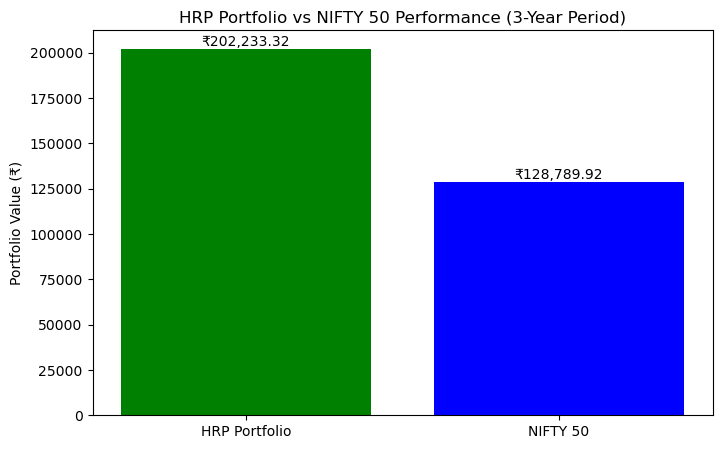


--- Investment Advice as of 2025-04-06 ---
Using training data from 2024-07-27 to 2025-04-05:

--- Top 3 Sectors Recommendation ---
Selected Sectors and Their Top 5 Stocks with Recommended Weights:


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:467: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weight = float(stock_hrp_weights[stock])



Sector: ^NSEBANK
  Top Stocks: ['KOTAKBANK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'FEDERALBNK.NS', 'BANKBARODA.NS']
  Recommended HRP Weights:
    KOTAKBANK.NS: 9.35%
    HDFCBANK.NS: 8.41%
    ICICIBANK.NS: 44.86%
    FEDERALBNK.NS: 28.04%
    BANKBARODA.NS: 9.35%


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:467: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weight = float(stock_hrp_weights[stock])



Sector: ^CNXCONSUM
  Top Stocks: ['BHARTIARTL.NS', 'INDHOTEL.NS', 'EICHERMOT.NS', 'TRENT.NS', 'APOLLOHOSP.NS']
  Recommended HRP Weights:
    BHARTIARTL.NS: 28.04%
    INDHOTEL.NS: 9.35%
    EICHERMOT.NS: 8.41%
    TRENT.NS: 44.86%
    APOLLOHOSP.NS: 9.35%

Sector: ^CNXIT
  Top Stocks: ['COFORGE.NS', 'PERSISTENT.NS', 'WIPRO.NS', 'TECHM.NS', 'HCLTECH.NS']
  Recommended HRP Weights:
    COFORGE.NS: 28.04%
    PERSISTENT.NS: 9.35%
    WIPRO.NS: 9.35%
    TECHM.NS: 8.41%
    HCLTECH.NS: 44.86%
------------------------------------------------------------


C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= cluster_sizes[right] / total_size
C:\Users\sarda\AppData\Local\Temp\ipykernel_15604\377895220.py:467: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weight = float(stock_hrp_weights[stock])


In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
import requests
import time

# =============================================================================
# 0. User Input: Number of Years for Simulation (between 1 and 15)
# =============================================================================
while True:
    try:
        num_years = int(input("Enter the number of years for simulation (1-15): "))
        if 1 <= num_years <= 15:
            break
        else:
            print("Please enter a number between 1 and 15.")
    except ValueError:
        print("Invalid input. Please enter an integer between 1 and 15.")

# =============================================================================
# 0a. User Input: Number of Sectors for Simulation (between 3 and 10)
# =============================================================================
while True:
    try:
        num_sectors = int(input("Enter the number of sectors to simulate (3-10): "))
        if 3 <= num_sectors <= 10:
            break
        else:
            print("Please enter a number between 3 and 10.")
    except ValueError:
        print("Invalid input. Please enter an integer between 3 and 10.")

# =============================================================================
# 1. Sector Data Download and Preprocessing (using sector indices)
# =============================================================================
sector_tickers = [
    "^CNXIT", "^CNXAUTO", "^NSEBANK", "^CNXFMCG", "^CNXMEDIA",
    "^CNXMETAL", "^CNXPSE", "^CNXMNC", "^CNXINFRA",
    "^CNXREALTY", "^CNXENERGY", "^CNXPSUBANK", "^CNXSERVICE", "^CNXCONSUM", "NIFTY_MIDCAP_100.NS"
]

end_date = datetime.today()
start_date = end_date - timedelta(days=365 * num_years)

data_dict = {}
for ticker in sector_tickers:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    if not df.empty and 'Close' in df.columns:
        data_dict[ticker] = df['Close']
    else:
        print(f"Data for {ticker} is missing or incomplete.")

if not data_dict:
    raise ValueError("No sector data downloaded. Check ticker symbols or network connection.")

prices = pd.concat(data_dict, axis=1).dropna()
# If columns are multi-index, reset to plain tickers.
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = prices.columns.get_level_values(0)
returns = prices.pct_change().dropna()

# =============================================================================
# 2. Download Benchmark Data for Trend/Stoploss Analysis (NIFTY 50)
# =============================================================================
benchmark_ticker = "^NSEI"
benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
if benchmark_data.empty:
    raise ValueError("No benchmark data downloaded for trend analysis.")
benchmark_series = benchmark_data['Close'].squeeze()

# =============================================================================
# 3. Correlation Analysis & Clustering for Diversification (Sector Level)
# =============================================================================
correlation_matrix = returns.corr()
print(f"\nCorrelation Matrix of Sector Returns (Last {num_years} Years):")
print(correlation_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Sector Returns")
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
sector_features = correlation_matrix.values
sector_labels = kmeans.fit_predict(sector_features)
sector_cluster_map = dict(zip(correlation_matrix.columns, sector_labels))
print("\nSector Cluster Mapping (for Diversification):")
for sector, cluster in sector_cluster_map.items():
    print(f"  {sector}: Cluster {cluster}")

# =============================================================================
# 4. Validated Stocks Extraction: Read Valid Stock Components from CSV File
# =============================================================================
# Expect 'validated_stocks.csv' with columns "Sector" and "Symbol"
try:
    df_valid = pd.read_csv('validated_stocks2.csv')
    all_symbols = {}
    for sector, group in df_valid.groupby('Sector'):
        symbols = group['Symbol'].tolist()
        # Ensure each symbol ends with ".NS"
        symbols = [s if s.endswith('.NS') else s + '.NS' for s in symbols]
        all_symbols[sector] = symbols
        print(f"Valid symbols for {sector}: {symbols}")
        print("----------")
except Exception as e:
    print("Error reading validated stocks file:", e)
    all_symbols = {}

# =============================================================================
# 4a. Read Listing Dates for Stocks from Invalidated Stocks File
# =============================================================================
# Expect 'invalidated_stocks.csv' with columns "Sector", "Symbol", and "ListingDate"
# Build a dictionary mapping each symbol (with .NS appended if needed) to its listing date.
listing_dates = {}
try:
    df_invalid = pd.read_csv('invalidated_stocks.csv')
    df_invalid['ListingDate'] = pd.to_datetime(df_invalid['ListingDate'])
    for idx, row in df_invalid.iterrows():
        symbol = row['Symbol']
        if not symbol.endswith('.NS'):
            symbol += '.NS'
        listing_dates[symbol] = row['ListingDate']
    print("\nListing dates loaded for stocks from invalidated_stocks.csv.")
except Exception as e:
    print("Error reading invalidated stocks file:", e)
    listing_dates = {}

# =============================================================================
# 5. HRP Weight Calculation Function (with Numerical Stability Fixes)
# =============================================================================
def get_hrp_weights(returns_df):
    """
    Calculate Hierarchical Risk Parity (HRP) weights.
    """
    if returns_df.shape[1] < 2:
        return pd.Series(1.0, index=returns_df.columns)
    
    corr = returns_df.corr().fillna(0)
    corr = 0.5 * (corr + corr.T)
    np.fill_diagonal(corr.values, 1.0)
    dist = np.sqrt(np.clip(0.5 * (1 - corr), 0.0, 1.0))
    dist = 0.5 * (dist + dist.T)
    dist = np.nan_to_num(dist, nan=0.0, posinf=0.0, neginf=0.0)
    
    condensed_dist = ssd.squareform(dist, checks=False)
    link = sch.linkage(condensed_dist, method='ward')
    sorted_indices = sch.leaves_list(link)
    ordered_tickers = returns_df.columns[sorted_indices]
    
    weights = pd.Series(1, index=ordered_tickers)
    cluster_sizes = pd.Series(1, index=ordered_tickers)
    
    for i in range(len(ordered_tickers) - 1):
        left, right = ordered_tickers[i], ordered_tickers[i+1]
        total_size = cluster_sizes[left] + cluster_sizes[right]
        weights[left] *= cluster_sizes[right] / total_size
        weights[right] *= cluster_sizes[left] / total_size
        cluster_sizes[left] = total_size
        cluster_sizes[right] = total_size
    
    return weights / weights.sum()

# =============================================================================
# 6. Diversified Sector Selection Function
# =============================================================================
def select_diversified_sectors(sharpe_scores, n, cluster_map):
    """
    Select top-n sectors based on Sharpe ratio while ensuring diversification.
    """
    sorted_sectors = sharpe_scores.sort_values(ascending=False).index.tolist()
    unique_selected = []
    used_clusters = set()
    for s in sorted_sectors:
        if cluster_map[s] not in used_clusters:
            unique_selected.append(s)
            used_clusters.add(cluster_map[s])
    selected = unique_selected.copy()
    for s in sorted_sectors:
        if len(selected) >= n:
            break
        if s not in selected:
            selected.append(s)
    return selected[:n]

# =============================================================================
# 7. Function to Select Top Stocks within a Sector
# =============================================================================
def get_top_stocks(sector, train_start, train_end, top_n=5):
    """
    For a given sector, download historical data for its valid component stocks (from all_symbols)
    over the training period. If a stock was listed after train_start, adjust the start date accordingly.
    Compute Sharpe ratios, and return the top 'top_n' stocks along with their HRP weights.
    """
    symbols = all_symbols.get(sector, [])
    if not symbols:
        print(f"No valid symbols available for sector {sector}.")
        return [], pd.Series(dtype=float)
    
    stock_data = {}
    for symbol in symbols:
        # Adjust training start date based on listing date if available.
        adj_train_start = train_start
        if symbol in listing_dates:
            list_date = listing_dates[symbol]
            if list_date > pd.to_datetime(train_start):
                adj_train_start = list_date.strftime("%Y-%m-%d")
        # Download data using the adjusted start date.
        try:
            df = yf.download(symbol, start=adj_train_start, end=train_end, progress=False, auto_adjust=True)
            if not df.empty and 'Close' in df.columns:
                stock_data[symbol] = df['Close']
        except Exception as e:
            print(f"Error downloading data for {symbol}: {e}")
            continue

    if not stock_data:
        print(f"No training data available for stocks in sector {sector}.")
        return [], pd.Series(dtype=float)
    
    prices_stock = pd.concat(stock_data, axis=1).dropna(how='all', axis=0)
    if prices_stock.empty:
        print(f"No overlapping training data for stocks in sector {sector}.")
        return [], pd.Series(dtype=float)
    
    returns_stock = prices_stock.pct_change().dropna()
    if returns_stock.empty:
        print(f"Insufficient returns data for stocks in sector {sector}.")
        return [], pd.Series(dtype=float)
    
    sharpe = returns_stock.mean() / returns_stock.std()
    sharpe = sharpe.dropna()
    if sharpe.empty:
        print(f"Sharpe ratio calculation failed for sector {sector}.")
        return [], pd.Series(dtype=float)
    
    top_stocks = sharpe.sort_values(ascending=False).head(top_n).index.tolist()
    selected_returns = returns_stock[top_stocks]
    hrp_weights_stocks = get_hrp_weights(selected_returns)
    return top_stocks, hrp_weights_stocks

# =============================================================================
# 8. Quarterly Rebalancing Simulation with Enhanced Risk Management & Transaction Costs
# =============================================================================
print("\n--- Quarterly Rebalancing Simulation with Enhanced Risk Management ---\n")
quarter_end_dates = pd.date_range(start=prices.index[0], end=prices.index[-1], freq='Q')
initial_capital = 100000
stoploss_pct = 0.05        # 5% stoploss threshold
transaction_cost_rate = 0.00075  # 0.15% per trade (0.075% per buy and sell)

# Since the user now selects a fixed number of sectors, we simulate for that number.
cumulative_value = initial_capital
quarterly_returns = []
quarterly_results = []

def get_previous_quarter_risk_factor(i, benchmark_series, quarter_end_dates):
    if i == 0:
        return 1.0
    prev_q_start = prices.index[0] if i-1 == 0 else quarter_end_dates[i-2] + pd.Timedelta(days=1)
    prev_q_end = quarter_end_dates[i-1]
    benchmark_prev = benchmark_series[(benchmark_series.index >= prev_q_start) & (benchmark_series.index <= prev_q_end)]
    if benchmark_prev.empty:
        return 1.0
    prev_return = (benchmark_prev.iloc[-1] / benchmark_prev.iloc[0]) - 1
    return np.clip(1 + prev_return, 0.5, 1.0)

for i, q_end in enumerate(quarter_end_dates):
    q_start = prices.index[0] if i == 0 else quarter_end_dates[i-1] + pd.Timedelta(days=1)
    if q_start >= prices.index[-1]:
        break

    training_end = q_start - pd.Timedelta(days=1)
    training_prices = prices[prices.index <= training_end]
    if training_prices.empty:
        continue
    training_returns = training_prices.pct_change().dropna()
    if training_returns.empty:
        continue

    sharpe_scores = training_returns.mean() / training_returns.std()
    # Use user-specified number of sectors.
    selected_sectors = select_diversified_sectors(sharpe_scores, num_sectors, sector_cluster_map)
    if len(selected_sectors) == 0:
        continue

    selected_training_returns = training_returns[selected_sectors]
    sector_hrp_weights = get_hrp_weights(selected_training_returns)

    # For each selected sector, determine top 5 stocks and get their HRP weights.
    sector_stock_info = {}
    sector_stock_returns = {}
    sector_weighted_returns = {}

    for sector in selected_sectors:
        # Use the same training period as for sectors.
        train_start = training_prices.index[0].strftime("%Y-%m-%d")
        train_end = training_end.strftime("%Y-%m-%d")
        top_stocks, stock_hrp_weights = get_top_stocks(sector, train_start, q_start.strftime("%Y-%m-%d"), top_n=5)
        if not top_stocks:
            continue
        # Ensure all tickers are strings.
        top_stocks = [s if isinstance(s, str) else s[0] for s in top_stocks]
        # Download stock prices for the top stocks for the quarter.
        stock_prices = yf.download(top_stocks,
                                   start=q_start.strftime("%Y-%m-%d"),
                                   end=q_end.strftime("%Y-%m-%d"),
                                   progress=False, auto_adjust=True)
        if 'Close' in stock_prices.columns:
            stock_prices = stock_prices['Close']
        stock_prices = stock_prices.dropna(how='all', axis=0)
        if stock_prices.empty or len(stock_prices) < 2:
            continue
        start_prices = stock_prices.iloc[0]
        end_prices = stock_prices.iloc[-1]
        stock_ret = (end_prices / start_prices) - 1
        weighted_return = np.dot(stock_hrp_weights[top_stocks], stock_ret[top_stocks])

        sector_stock_info[sector] = {
            'top_stocks': top_stocks,
            'stock_hrp_weights': stock_hrp_weights[top_stocks].to_dict()
        }
        sector_stock_returns[sector] = stock_ret.to_dict()
        sector_weighted_returns[sector] = weighted_return

    if not sector_weighted_returns:
        continue

    overall_return = 0
    for sector in selected_sectors:
        if sector in sector_weighted_returns:
            overall_return += sector_hrp_weights[sector] * sector_weighted_returns[sector]

    # Modified Stoploss: if daily cumulative drop is below threshold, then use effective return = raw return if raw return is better than -stoploss_pct.
    period_prices = prices.loc[(prices.index >= q_start) & (prices.index <= q_end), selected_sectors]
    if period_prices.empty or len(period_prices) < 2:
        continue
    daily_returns = period_prices.pct_change().dropna()
    daily_portfolio_returns = daily_returns.apply(lambda row: np.dot([sector_hrp_weights[s] for s in selected_sectors], row[selected_sectors]), axis=1)
    cum_daily = (1 + daily_portfolio_returns).cumprod()
    if cum_daily.min() < (1 - stoploss_pct):
        stoploss_triggered = True
        stoploss_return = overall_return if overall_return > -stoploss_pct else -stoploss_pct
    else:
        stoploss_triggered = False
        stoploss_return = overall_return

    risk_factor = get_previous_quarter_risk_factor(i, benchmark_series, quarter_end_dates)
    effective_return = risk_factor * stoploss_return

    net_value_entry = cumulative_value * (1 - transaction_cost_rate)
    new_value = net_value_entry * (1 + effective_return)
    net_value_exit = new_value * (1 - transaction_cost_rate)
    cumulative_value = net_value_exit
    quarterly_returns.append(effective_return)

    quarterly_results.append({
        'quarter_start': q_start,
        'quarter_end': q_end,
        'selected_sectors': selected_sectors,
        'sector_hrp_weights': sector_hrp_weights.to_dict(),
        'sector_stock_info': sector_stock_info,
        'sector_stock_returns': sector_stock_returns,
        'sector_weighted_returns': sector_weighted_returns,
        'raw_portfolio_return': overall_return,
        'stoploss_triggered': stoploss_triggered,
        'stoploss_return': stoploss_return,
        'risk_factor': risk_factor,
        'effective_portfolio_return': effective_return,
        'cumulative_value': cumulative_value
    })

    print(f"Quarter {q_start.date()} to {q_end.date()}:")
    print(f"  Selected Sectors: {selected_sectors}")
    print("  Sector HRP Weights:")
    for sector in selected_sectors:
        print(f"    {sector}: {sector_hrp_weights[sector]:.2%}")
        if sector in sector_stock_info:
            info = sector_stock_info[sector]
            print("      Top Stocks & Weights:")
            for stock, wt in info['stock_hrp_weights'].items():
                print(f"        {stock}: {wt:.2%}")
    print(f"  Raw Portfolio Return: {overall_return:.2%}")
    if stoploss_triggered:
        print(f"  STOPLOSS Triggered: Capped Return = {stoploss_return:.2%}")
    print(f"  Risk Factor: {risk_factor:.2f}")
    print(f"  Effective Portfolio Return: {effective_return:.2%}")
    print(f"  Cumulative Value after Transaction Costs: ₹{cumulative_value:,.2f}")
    print("-" * 80)

simulation_summary = {
    'Number of Sectors': num_sectors,
    'HRP Portfolio Value': cumulative_value
}
print("\n=== Simulation Summary for HRP Portfolio ===")
print(pd.DataFrame([simulation_summary]).to_string(index=False))

# =============================================================================
# 9. Fixed Benchmark Analysis (NIFTY 50)
# =============================================================================
initial_capital_bench = 100000
filtered_data = benchmark_series[benchmark_series.index >= pd.Timestamp(start_date)]
if len(filtered_data) < 2:
    raise ValueError("Not enough benchmark data for the selected period.")

start_price = float(filtered_data.iloc[0])
end_price = float(filtered_data.iloc[-1])
total_return = (end_price / start_price) - 1
cagr = ((1 + total_return) ** (1/num_years)) - 1
final_value = initial_capital_bench * (1 + total_return)

benchmark_summary = {
    'Time Period': f"{num_years} Years",
    'Total Return (%)': round(total_return * 100, 2),
    'CAGR (%)': round(cagr * 100, 2),
    'Final Portfolio Value': round(final_value, 2)
}
benchmark_results_df = pd.DataFrame([benchmark_summary])
print(f"\n=== NIFTY 50 Benchmark Performance ({num_years} Years) ===")
print(benchmark_results_df.to_string(index=False))

# Calculate outperformance.
outperformance_pct = ((cumulative_value - final_value) / final_value) * 100
print(f"\n=== Final Performance Comparison ===")
print(f"HRP Portfolio Value: ₹{cumulative_value:,.2f}")
print(f"NIFTY 50 Final Value: ₹{final_value:,.2f}")
print(f"Outperformance: {outperformance_pct:.2f}%")

plt.figure(figsize=(8, 5))
bars = plt.bar(['HRP Portfolio', 'NIFTY 50'], [cumulative_value, final_value],
               color=['green' if cumulative_value > final_value else 'red', 'blue'])
plt.title(f"HRP Portfolio vs NIFTY 50 Performance ({num_years}-Year Period)")
plt.ylabel("Portfolio Value (₹)")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'₹{height:,.2f}', ha='center', va='bottom')
plt.show()

# =============================================================================
# 10. Investment Advice Based on Last 1 Year Data (Stock-Level)
# =============================================================================
advice_date = datetime.today()
advice_training_end = advice_date - timedelta(days=1)
advice_training_start = advice_training_end - timedelta(days=252)
if advice_training_start < prices.index[0]:
    advice_training_start = prices.index[0]

advice_training_prices = prices.loc[advice_training_start:advice_training_end].ffill()
advice_training_returns = advice_training_prices.pct_change().dropna()

print(f"\n--- Investment Advice as of {advice_date.date()} ---")
print(f"Using training data from {advice_training_start.date()} to {advice_training_end.date()}:\n")
print(f"--- Top {num_sectors} Sectors Recommendation ---")
print("Selected Sectors and Their Top 5 Stocks with Recommended Weights:")
for sector in select_diversified_sectors(advice_training_returns.mean() / advice_training_returns.std(), num_sectors, sector_cluster_map):
    top_stocks, stock_hrp_weights = get_top_stocks(sector, advice_training_prices.index[0].strftime("%Y-%m-%d"), advice_training_end.strftime("%Y-%m-%d"), top_n=5)
    if top_stocks:
        top_stocks = [s if isinstance(s, str) else s[0] for s in top_stocks]
        print(f"\nSector: {sector}")
        print(f"  Top Stocks: {top_stocks}")
        print("  Recommended HRP Weights:")
        for stock in top_stocks:
            weight = float(stock_hrp_weights[stock])
            print(f"    {stock}: {weight:.2%}")
print("-" * 60)